In [23]:
# Import basic libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Price Volume data retrieval using Yahoo Finance API

Target tickers:
- S&P 500 Index (SPY)
- VIX Index (^VIX)
- Gold (GC=F)
- Brent Crude (BZ=F)
- WTI (CL=F)

In [24]:
# !apt-get install -y build-essential
# !apt-get install -y wget
# !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
# !tar -xzf ta-lib-0.4.0-src.tar.gz
# %cd ta-lib/
# !./configure --prefix=/usr
# !make
# !make install
!pip uninstall -y numpy
!pip install numpy == 1.20.3
!pip install TA-Lib

import yfinance as yf
import talib

Found existing installation: numpy 1.26.1
Uninstalling numpy-1.26.1:
  Successfully uninstalled numpy-1.26.1
zsh:1: = not found
  Using cached numpy-1.26.1-cp310-cp310-macosx_11_0_arm64.whl (14.0 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.
numba 0.56.4 requires numpy<1.24,>=1.18, but you have numpy 1.26.1 which is incompatible.


In [25]:
# Create price extractor

class price_volume_data:
    """A class for retrieving and analyzing price and volume data."""
    def __init__(self, tickers, start_date, end_date):
        """
        Initializes a new instance of the price_volume_data class.

        Args:
            tickers (list): A list of tickers for the assets to retrieve data for.
            start_date (str): The start date for the data retrieval (format: 'YYYY-MM-DD').
            end_date (str): The end date for the data retrieval (format: 'YYYY-MM-DD').
        """
        self.tickers = tickers
        self.start_date = start_date
        self.end_date = end_date
        self.pv = self.__retrieve_data__()
        
        #self.lp, self.ret = self.__get_daily_returns__()
        
    def __retrieve_data__(self):
        """
        Retrieves price and volume data for the given tickers from Yahoo Finance API.

        Returns:
            dict: A dictionary containing the price and volume data for each ticker.
        """

        data, failed = {}, []
        
        for ticker in self.tickers:
            try:
                df = yf.Ticker(ticker).history(start = self.start_date, end = self.end_date)
                
                
                data[ticker] = df
                
            except:
                failed.append(ticker)
                
        if failed:
            print('Tickers failed to extract: ', failed)
        
        return data
    
    def __get_daily_returns__(self):
        """
        Computes daily returns for the retrieved price data.

        Returns:
            pd.DataFrame: A DataFrame containing the daily price data.
            pd.DataFrame: A DataFrame containing the daily price returns.
        """
        df = pd.DataFrame()
        
        for ticker in self.pv:
            if df.empty:
                df = pd.DataFrame(self.pv[ticker]['Close'].copy())
            else:
                df = df.merge(self.pv[ticker]['Close'], how='outer',left_index=True, right_index=True)

        df.columns = self.tickers
        df = df.fillna(method = 'ffill')
        
        return df, df/df.shift(1) - 1
    
    def get_info(self, ticker = None):
        """
        Prints information about the price and volume data for the specified ticker.
        If no ticker is provided, prints information for all tickers.

        Args:
            ticker (str, optional): The ticker symbol for the asset. Defaults to None.
        """
        if ticker:
            self.pv[ticker].info()
        
        else:
            for ticker in self.pv:
                self.pv[ticker].info()
                
        return None
    
    def plot_price_trends(self, normalize = True, reference = -1):
        """
        Plots the close prices of selected assets over time.

        Args:
            normalize (bool, optional): Indicates whether to normalize the prices. Defaults to True.
            reference (int, optional): Reference point for normalization. Defaults to -1.
        """
        f, ax = plt.subplots(1,1,figsize=(12,5))
        # plot prices
        for key in self.pv:
            last_price = self.pv[key].loc[:, 'Close'].copy()
            if normalize:
                if reference == -1:
                    last_price /= last_price.iloc[0]
                elif reference == 0:
                    midpt = int(last_price.shape[0]/2)
                    last_price /= last_price.iloc[midpt]
                else:
                    last_price /= last_price.iloc[-1]
            last_price.plot(ax = ax, label = key)
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()
        
    def plot_corr(self, method='pearson', output = False, series = 'price'):
        """
        Plots the correlation matrix between asset prices or returns.

        Args:
            method (str, optional): The correlation method to use. Defaults to 'pearson'.
            output (bool, optional): Indicates whether to return the correlation matrix. Defaults to False.
            series (str, optional): Indicates whether to use 'price' or 'returns'. Defaults to 'price'.

        Returns:
            pd.DataFrame or None: The correlation matrix if output=True, None otherwise.
        """
        corr_matrix = self.lp.corr(method) if series == 'price' else self.ret.corr(method)
        mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
        
        f, ax = plt.subplots(figsize=(5, 5))
        sns.heatmap(corr_matrix, mask=mask, vmin=-1, vmax=1, annot=True)
        
        return corr_matrix if output else None
        
        
    def get_technical_indicators(self, indicators = None, normalize = True):
        """
        Computes and adds various technical indicators to the price data.

        Args:
            indicators (list, optional): A list of tuples specifying the indicators and their parameters.
                Defaults to None.
            normalize (bool, optional): Indicates whether to normalize the indicator values. Defaults to True.
        """
        if not indicators:
            indicators = [('SMA', 5), ('SMA', 14), ('ATR', 5), ('ATR', 14), ('ADX', 5),
                         ('ADX', 14), ('RSI', 5), ('RSI', 14), ('MACD', None), ('BBANDS', None)]
        
        for data in self.pv:
            df = self.pv[data]
            for indicator, param in indicators:
                
                
                if indicator == 'SMA':
                    df[f'{indicator}_{param}'] = talib.SMA(df['Close'], param)

                elif indicator == 'ATR':
                    df[f'{indicator}_{param}'] = talib.ATR(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'ADX':
                    df[f'{indicator}_{param}'] = talib.ADX(df['High'], df['Low'], df['Close'], param) 
                    
                elif indicator == 'RSI':
                    df[f'{indicator}_{param}'] = talib.RSI(df['Close'], param) 
                    
                elif indicator == 'MACD':
                    df[f'{indicator}'], df[f'{indicator}_signal'], _ = talib.MACD(df['Close']) 
                    
                    
                elif indicator == 'BBANDS':
                    df[f'{indicator}_upp'], df[f'{indicator}_mid'], df[f'{indicator}_low'] = talib.BBANDS(df['Close'])
                    
                    
                else:
                    print('Indicators not built into the class. Please run TALIB manually!')
            
            df = df.replace([np.inf, -np.inf], np.nan, inplace = True)
            
        return None              

In [26]:
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM
from keras.regularizers import L1, L1L2, L2
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.model_selection import train_test_split, TimeSeriesSplit, cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score

import numpy as np
import tensorflow as tf
import random as python_random

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os

def reset_seeds(SEED = 624):
    np.random.seed(SEED) 
    python_random.seed(SEED)
    tf.random.set_seed(SEED)
    os.environ["PYTHONHASHSEED"] = str(SEED)

tf.config.experimental.enable_op_determinism()

In [51]:
class LSTM_predictor:
    """A class for predicting time series using LSTM (Long Short-Term Memory) models."""
    def __init__(self, X, Y):
        """
        Initializes a new instance of the LSTM_predictor class.

        Args:
            X (ndarray): The input feature matrix.
            Y (ndarray): The target values.
        """
        self.X, self.Y = self.__clean_data__(X, Y)
        self.features_size = X.shape[1]
        self.obs_size = X.shape[0]
        
        
    def __clean_data__(self, X, Y):
        """
        Cleans the input feature matrix and target values by removing rows with NaN values.

        Args:
            X (ndarray): The input feature matrix.
            Y (ndarray): The target values.

        Returns:
            ndarray: The cleaned input feature matrix.
            ndarray: The cleaned target values.
        """
        Z = np.concatenate((X, Y), axis = 1)
        Z = Z[~np.isnan(Z).any(axis=1), :]
        return Z[:, :-1], Z[:, -1]
        
    def prepare_data(self, train_test_split = 0.8, timestep = 1, look_forward = 1, inplace = False, scaled = True):
        """
        Prepares the data for training and testing the LSTM model.

        Args:
            train_test_split (float, optional): The fraction of data to be used for training.
                Defaults to 0.8.
            timestep (int, optional): The number of time steps to consider for each sample.
                Defaults to 3.
            inplace (bool, optional): Indicates whether to store the prepared data in the class
                instance or return it. Defaults to False.
            scaled (bool, optional): Indicates whether to scale the data. Defaults to True.

        Returns:
            tuple or None: If inplace=True, returns None. Otherwise, returns a tuple containing
            the prepared training and testing data as (X_train, Y_train, X_test, Y_test).
        """
        split_idx = int(self.obs_size*0.8)
        train_set = self.X[:-4-look_forward,:], self.Y[timestep+look_forward:-4]
        test_set = self.X[-4-timestep+1:,:], self.Y[-4+look_forward:]
        print(test_set[0])
        
        # Scale factors
        mean_X = np.mean(train_set[0], axis = 0)
        std_X = np.std(train_set[0], axis = 0)
        self.__scale_X__ = (mean_X, std_X)
        
        mean_Y = np.mean(train_set[1], axis = 0)
        std_Y = np.std(train_set[1], axis = 0)
        self.__scale_Y__ = (mean_Y, std_Y)
        
        sampled = []

        for X, Y in [train_set, test_set]:
            X_sampled, Y_sampled = [], []
            #print(X.shape)
            #print(Y.shape)
            print(len(X))

            for i in range(len(X)-timestep-look_forward+1):
                print(i)

                X_sampled.append((X[i:i+timestep] - self.__scale_X__[0])/self.__scale_X__[1])
                Y_sampled.append((Y[i] - self.__scale_Y__[0])/self.__scale_Y__[1])
            
            sampled.append((np.array(X_sampled),np.array(Y_sampled)))
        
        if inplace:
            self.X_train, self.Y_train = sampled[0]
            self.X_test, self.Y_test = sampled[1]
            print("x_train after prepare_data has shape of {}".format(self.X_train.shape))
            print("x_test after prepare_data has shape of {}".format(self.X_test.shape))
            
            return None
        else:
            return sampled
        
    def init_model(self, optimizer='adam', loss='mean_squared_error', kernel_regularizer=None, num_lstm_units = 64, num_lstm_units_2 = 64,num_dense_units = 25, learning_rate=0.001):
        """
        Initializes the LSTM model with the specified optimizer and loss function.

        Args:
            optimizer (str, optional): The optimizer to use. Defaults to 'adam'.
            loss (str, optional): The loss function to use. Defaults to 'mean_squared_error'.
        """
        reset_seeds()
        model = Sequential()
        model.add(LSTM(num_lstm_units, return_sequences=True,\
                       input_shape= (self.X_train.shape[1], self.features_size),\
                      kernel_regularizer=kernel_regularizer, activation = 'relu')) #added activation = "relu"
        model.add(LSTM(num_lstm_units_2, return_sequences=False, kernel_regularizer=kernel_regularizer, activation = 'relu'))
        model.add(Dense(num_dense_units))
        model.add(Dense(1))
        
        
        #opt = Adam(learning_rate=learning_rate) #to remove and default to the code directly below
        
        #if optimizer == 'adam':
            #opt = Adam(learning_rate=learning_rate)
        #elif optimizer == 'SGD':
            #opt = SGD(learning_rate=learning_rate)
        #else:
            #raise ValueError(f"Unsupported optimizer: {optimizer}")
        
        model.compile(optimizer = optimizer, loss = loss) # changed optimizer = optimizer to optimizer = opt
        self.model = model
        
        return None
    
    def fit_model_train(self, batch_size=100, epochs=50, callbacks=None):
        """
        Trains the LSTM model.

        Args:
            batch_size (int, optional): The batch size for training. 
            epochs (int, optional): The number of epochs to train for. 
        """
        self.test_loss_list = []
        self.pred_per_epoch = []
        history_train = self.model.fit(self.X_train, self.Y_train, epochs=epochs, batch_size=batch_size, verbose=1, callbacks = callbacks)
        self.train_loss_list = history_train.history['loss']  # Store loss values in the list 
       
        
    def predict(self):
        """Makes predictions using the trained LSTM model."""
        self.Y_pred = self.model.predict(self.X_test)
        #mse = mean_squared_error(self.Y_test, self.Y_pred)
        #mse_list.append(mse)
        

        
    def key_metrics(self,epoch=None):
        Y_actual = self.Y
        Y_pred = self.Y_pred if epoch == None else self.pred_per_epoch[epoch-1]
        mse = mean_squared_error(self.Y_test, Y_pred)
        mae = mean_absolute_error(self.Y_test, Y_pred)
        exp_ratio = explained_variance_score(self.Y_test, Y_pred)
        
        return Y_actual[-1],(Y_pred[-1]*self.__scale_Y__[1] + self.__scale_Y__[0]), mse, mae, exp_ratio 
    
    def cross_validation(self, n_splits = 5, batch_size=100, epochs=10, callback=False):
        """
        Perform cross-validation for the LSTM model.

        Parameters:
        - n_splits: Number of cross-validation splits (int, default=5)
        - batch_size: Number of samples per gradient update (int, default=100)
        - epochs: Number of epochs to train the model (int, default=50)
        - callback: Flag indicating whether to use custom callback during training (bool, default=True)

        Returns:
        - None
        """
        reset_seeds()
        tscv = TimeSeriesSplit(n_splits=5)
        
        cv_train_scores = []
        cv_val_scores = []
        
        print('Initiate cross-validation')
        i = 1

        for train_index, test_index in tscv.split(self.X_train):
            print(f'Running cross validation round {i}')
            self.temp_val_scores = []

            #print(self.X_train[train_index].shape)
            #print(self.X_train[test_index].shape)
            
            cv_X_train, cv_X_test = self.X_train[train_index], self.X_train[test_index]
            cv_y_train, cv_y_test = self.Y_train[train_index], self.Y_train[test_index]
            
            #print(cv_X_test.shape)
    
            # Fit your model on the training data
            history_train = self.model.fit(cv_X_train, cv_y_train, batch_size=batch_size,\
                                           epochs=epochs,\
                                           verbose = 2)
            cv_train_scores.append(history_train.history['loss'])
            cv_val_scores.append(self.temp_val_scores)
            print('==============================================')
            i+=1
            
        self.cv_train_scores = np.array(cv_train_scores).mean(axis = 0)
        self.cv_val_scores = np.array(cv_val_scores).mean(axis = 0)
        
    def forward_test(self,num_lstm_units, num_lstm_units_2,num_dense_units,kernel_regularizer=None, optimizer='adam', loss='mean_squared_error', batch_size=100, epochs=5, learning_rate = 0.005):
        model = Sequential()
        model.add(LSTM(num_lstm_units, return_sequences=True,\
                       input_shape= (self.X_train.shape[1], self.features_size),\
                      kernel_regularizer=kernel_regularizer))
        model.add(LSTM(num_lstm_units_2, return_sequences=False, kernel_regularizer=kernel_regularizer))
        model.add(Dense(num_dense_units))
        model.add(Dense(1))
        
        if optimizer == 'adam':
            opt = Adam(learning_rate=learning_rate)
        elif optimizer == 'SGD':
            opt = SGD(learning_rate=learning_rate)
        else:
            raise ValueError(f"Unsupported optimizer: {optimizer}")

        model.compile(optimizer = optimizer, loss = loss)
        model = model   

        model.fit(self.X_train, self.Y_train, batch_size=batch_size, epochs=5)

        self.Y_pred = model.predict(self.X_test)
        
        print(self.Y_test.shape)
        print(self.Y_pred.shape)

        mse = mean_squared_error(self.Y_test, self.Y_pred) *-1
        mae = mean_absolute_error(self.Y_test, self.Y_pred)
        exp_ratio = explained_variance_score(self.Y_test, self.Y_pred)

        return mse 

    def plot_prediction(self, epoch = None):
        """Plots the predicted and actual values."""
        if epoch == None:
            Y_pred = self.Y_pred
        else:
            Y_pred = self.pred_per_epoch[epoch - 1]
        actual = np.concatenate((self.Y_train.reshape(-1,1), self.Y_test.reshape(-1,1)))
        actual = actual*self.__scale_Y__[1] + self.__scale_Y__[0]
        prediction = np.concatenate((self.Y_train.reshape(-1,1), Y_pred))
        prediction = prediction*self.__scale_Y__[1] + self.__scale_Y__[0]
        
        f, ax = plt.subplots(figsize=(12,5))
        plt.plot(prediction, label = 'Predicted')
        plt.plot(actual, label = 'Actual')
        
        ax.title.set_text('Close Prices of selected assets')
        ax.set(ylabel = 'Normalized Price to start of observation')
        ax.legend()
        plt.show()

In [33]:
# sheet_name = ['20220524','20220823','20221122','20230221','20230523']
# symbols = pd.read_excel("target_stock_universe.xlsx", sheet_name = sheet_name[0]) # change here to get the other sheet
# symbols['Ticker_Symbol'] = symbols['Ticker'].str.split().str[0]+".L"
# symbols = symbols[symbols['Ticker_Symbol']!='HSV.L']
# symbols = symbols[symbols['Ticker_Symbol']!='HBR.L']

symbols_short = ['IDS.L'] # change here to get the full list of stock
data = price_volume_data(symbols_short, '2017-05-25', '2022-05-31')
data.get_technical_indicators()
technical_indicators = ['Close', 'Volume', 'SMA_5', 'SMA_14', 'ATR_5', 'ATR_14', 'ADX_5', 'ADX_14', 'RSI_5','RSI_14', 'MACD', 'MACD_signal', 'BBANDS_upp', 'BBANDS_mid', 'BBANDS_low']

In [37]:
def get_technicals(technical_indicators, symbols_short, data):
    results = {}
    Y = {}
    X = {}
    for x in range(len(symbols_short)):
        results[x] = data.pv['IDS.L']
        Y[x] = np.array(results[x]['Close']).reshape(-1,1)
        X[x] = np.array(results[x][technical_indicators])
    return results, Y, X

In [39]:
results, Y, X = get_technicals(technical_indicators, symbols_short, data)

[[ 3.16657379e+02  6.98481900e+06  3.11621393e+02  3.14225235e+02
   1.86138805e+01  1.47602912e+01  3.51505377e+01  2.00286170e+01
   5.41273219e+01  4.87753270e+01 -5.23933676e+00 -4.89469974e+00
   3.43627376e+02  3.11621393e+02  2.79615409e+02]
 [ 2.99203094e+02  5.64676600e+06  3.05879596e+02  3.12304036e+02
   1.96981925e+01  1.54228019e+01  3.55356410e+01  2.04501537e+01
   4.05185177e+01  4.20204894e+01 -6.00347866e+00 -5.11645553e+00
   3.34226945e+02  3.05879596e+02  2.77532247e+02]
 [ 2.99203094e+02  3.69597700e+06  3.00404858e+02  3.10709848e+02
   1.79522648e+01  1.51046414e+01  3.64875393e+01  2.09514870e+01
   4.05185177e+01  4.20204894e+01 -6.53374962e+00 -5.39991434e+00
   3.19812149e+02  3.00404858e+02  2.80997568e+02]
 [ 3.12174591e+02  3.51443100e+06  3.05612537e+02  3.10750724e+02
   1.74215633e+01  1.51185068e+01  3.00138117e+01  2.04302350e+01
   5.39599912e+01  4.82031508e+01 -5.83998213e+00 -5.48792790e+00
   3.20313178e+02  3.05612537e+02  2.90911895e+02]
 [ 3

2023-10-26 00:15:50.822136: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [208]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:15:50.822329: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [208]
	 [[{{node Placeholder/_11}}]]


3/3 - 1s - loss: 0.3693 - 993ms/epoch - 331ms/step
Epoch 2/10
3/3 - 0s - loss: 0.2786 - 10ms/epoch - 3ms/step
Epoch 3/10
3/3 - 0s - loss: 0.2021 - 11ms/epoch - 4ms/step
Epoch 4/10
3/3 - 0s - loss: 0.1373 - 11ms/epoch - 4ms/step
Epoch 5/10
3/3 - 0s - loss: 0.1080 - 10ms/epoch - 3ms/step
Epoch 6/10
3/3 - 0s - loss: 0.0920 - 11ms/epoch - 4ms/step
Epoch 7/10
3/3 - 0s - loss: 0.0678 - 11ms/epoch - 4ms/step
Epoch 8/10
3/3 - 0s - loss: 0.0427 - 10ms/epoch - 3ms/step
Epoch 9/10
3/3 - 0s - loss: 0.0273 - 11ms/epoch - 4ms/step
Epoch 10/10
3/3 - 0s - loss: 0.0161 - 12ms/epoch - 4ms/step
Running cross validation round 2
Epoch 1/10
5/5 - 0s - loss: 0.0847 - 19ms/epoch - 4ms/step
Epoch 2/10
5/5 - 0s - loss: 0.0649 - 19ms/epoch - 4ms/step
Epoch 3/10
5/5 - 0s - loss: 0.0489 - 19ms/epoch - 4ms/step
Epoch 4/10
5/5 - 0s - loss: 0.0339 - 20ms/epoch - 4ms/step
Epoch 5/10
5/5 - 0s - loss: 0.0258 - 19ms/epoch - 4ms/step
Epoch 6/10
5/5 - 0s - loss: 0.0197 - 19ms/epoch - 4ms/step
Epoch 7/10
5/5 - 0s - loss: 0.

2023-10-26 00:15:51.959709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [411]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:15:51.959947: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [411]
	 [[{{node Placeholder/_11}}]]


5/5 - 0s - loss: 0.0170 - 20ms/epoch - 4ms/step
Running cross validation round 3
Epoch 1/10
7/7 - 0s - loss: 0.0212 - 29ms/epoch - 4ms/step
Epoch 2/10
7/7 - 0s - loss: 0.0175 - 28ms/epoch - 4ms/step
Epoch 3/10
7/7 - 0s - loss: 0.0165 - 30ms/epoch - 4ms/step
Epoch 4/10
7/7 - 0s - loss: 0.0155 - 30ms/epoch - 4ms/step
Epoch 5/10
7/7 - 0s - loss: 0.0140 - 30ms/epoch - 4ms/step
Epoch 6/10
7/7 - 0s - loss: 0.0136 - 30ms/epoch - 4ms/step
Epoch 7/10


2023-10-26 00:15:52.200473: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [614]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:15:52.200722: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [614]
	 [[{{node Placeholder/_11}}]]


7/7 - 0s - loss: 0.0131 - 31ms/epoch - 4ms/step
Epoch 8/10
7/7 - 0s - loss: 0.0127 - 30ms/epoch - 4ms/step
Epoch 9/10
7/7 - 0s - loss: 0.0121 - 30ms/epoch - 4ms/step
Epoch 10/10
7/7 - 0s - loss: 0.0119 - 31ms/epoch - 4ms/step
Running cross validation round 4
Epoch 1/10
9/9 - 0s - loss: 0.0175 - 39ms/epoch - 4ms/step
Epoch 2/10
9/9 - 0s - loss: 0.0152 - 37ms/epoch - 4ms/step
Epoch 3/10
9/9 - 0s - loss: 0.0128 - 36ms/epoch - 4ms/step
Epoch 4/10
9/9 - 0s - loss: 0.0120 - 35ms/epoch - 4ms/step
Epoch 5/10


2023-10-26 00:15:52.545559: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [817,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:15:52.545749: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [817]
	 [[{{node Placeholder/_11}}]]


9/9 - 0s - loss: 0.0115 - 37ms/epoch - 4ms/step
Epoch 6/10
9/9 - 0s - loss: 0.0109 - 37ms/epoch - 4ms/step
Epoch 7/10
9/9 - 0s - loss: 0.0121 - 36ms/epoch - 4ms/step
Epoch 8/10
9/9 - 0s - loss: 0.0112 - 35ms/epoch - 4ms/step
Epoch 9/10
9/9 - 0s - loss: 0.0108 - 38ms/epoch - 4ms/step
Epoch 10/10
9/9 - 0s - loss: 0.0109 - 37ms/epoch - 4ms/step
Running cross validation round 5
Epoch 1/10
11/11 - 0s - loss: 0.0234 - 46ms/epoch - 4ms/step
Epoch 2/10
11/11 - 0s - loss: 0.0160 - 47ms/epoch - 4ms/step
Epoch 3/10
11/11 - 0s - loss: 0.0141 - 45ms/epoch - 4ms/step
Epoch 4/10


2023-10-26 00:15:52.962073: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1020]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:15:52.962257: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1020]
	 [[{{node Placeholder/_11}}]]


11/11 - 0s - loss: 0.0127 - 45ms/epoch - 4ms/step
Epoch 5/10
11/11 - 0s - loss: 0.0124 - 45ms/epoch - 4ms/step
Epoch 6/10
11/11 - 0s - loss: 0.0118 - 45ms/epoch - 4ms/step
Epoch 7/10
11/11 - 0s - loss: 0.0116 - 45ms/epoch - 4ms/step
Epoch 8/10
11/11 - 0s - loss: 0.0116 - 44ms/epoch - 4ms/step
Epoch 9/10
11/11 - 0s - loss: 0.0126 - 46ms/epoch - 4ms/step
Epoch 10/10
11/11 - 0s - loss: 0.0110 - 45ms/epoch - 4ms/step
Epoch 1/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0167
Epoch 2/30
18/39 [============>.................] - ETA: 0s - loss: 0.0161

2023-10-26 00:15:53.463517: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:15:53.463714: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


39/39 [==============================] - 0s 3ms/step - loss: 0.0158
Epoch 3/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0146
Epoch 4/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 5/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0137
Epoch 6/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0120
Epoch 7/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0126
Epoch 8/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 9/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0109
Epoch 10/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0125
Epoch 11/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0114
Epoch 12/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0106
Epoch 13/30
39/39 [==============================] - 0s 3ms/step - loss: 0.0097
Epoch 14/30
39/39 [==============================] - 0s 3ms

2023-10-26 00:15:56.935779: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:15:56.935940: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


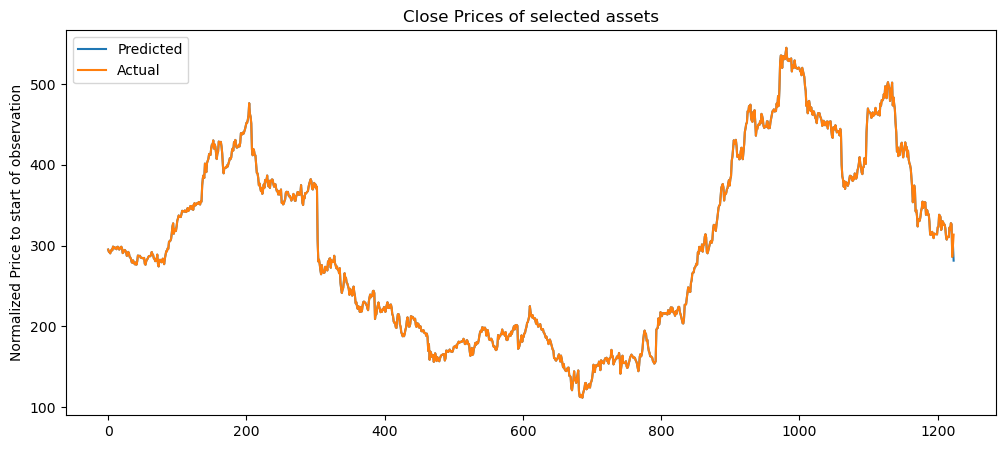

In [52]:
model1 = LSTM_predictor(X[0], Y[0])
model1.prepare_data(train_test_split = 0.8, timestep = 3, look_forward = 3, inplace = True)
model1.init_model(optimizer='adam', loss='mean_squared_error')
model1.cross_validation()
model1.fit_model_train(epochs=30,batch_size=32)
model1.predict()
model1.key_metrics()
model1.plot_prediction()

In [41]:
metrics_copy = pd.DataFrame(metrics)

# Bayesian Optimization

In [53]:
import torch

In [54]:
# generate initial training dataset for optimization
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
dtype = torch.double

num_lstm_units_bound = [32,512] #random_num
num_lstm_units_bound_2 = [32,512] #random_num_2
num_dense_units_bound = [16,256] #random_num_3
batch_size_bound = [100, 200] #random_num_4
learning_rate_bound = [0.005,0.01] #random_num_5
#optimizer_bound = ['adam', 'SGD'] #random_num_6


cpu


In [55]:
import random

n = 5  # Number of random integers to generate

random_nums = []
for _ in range(n):
    random_num = random.randint(num_lstm_units_bound[0], num_lstm_units_bound[1])
    random_nums.append(random_num)
    
random_nums_2 = []
for _ in range(n):
    random_num_2 = random.randint(num_lstm_units_bound_2[0], num_lstm_units_bound_2[1])
    random_nums_2.append(random_num_2)

random_nums_3 = []
for _ in range(n):
    random_num_3 = random.randint(num_dense_units_bound[0], num_dense_units_bound[1])
    random_nums_3.append(random_num_3)
    
random_nums_4 = []
for _ in range(n):
    random_num_4 = random.randint(batch_size_bound[0], batch_size_bound[1])
    random_nums_4.append(random_num_4)
    
random_nums_5 = []
for _ in range(n):
    random_num_5 = random.uniform(learning_rate_bound[0], learning_rate_bound[1])
    random_nums_5.append(random_num_5)
    
# random_nums_6 = []
# for _ in range(n):
#     random_num_6 = random.choice(optimizer_bound)
#     random_nums_6.append(random_num_6)
    
random_nums_tensor = torch.tensor(random_nums, dtype=torch.float64, device = device).reshape(n, 1)
random_nums_2_tensor = torch.tensor(random_nums_2, dtype=torch.float64, device = device).reshape(n, 1)
random_nums_3_tensor = torch.tensor(random_nums_3, dtype=torch.float64, device = device).reshape(n, 1)
random_nums_4_tensor = torch.tensor(random_nums_4, dtype=torch.float64, device = device).reshape(n, 1)
random_nums_5_tensor = torch.tensor(random_nums_5, dtype=torch.float64, device = device).reshape(n, 1)
# label_map = {string: i for i, string in enumerate(random_nums_6)}  # Create a mapping of strings to integer labels
# integer_labels = [label_map[string] for string in random_nums_6]  # Convert strings to integer labels
# random_nums_6_tensor = torch.tensor(integer_labels, dtype=torch.long).reshape(n, 1)


train_x = torch.cat((random_nums_tensor, random_nums_2_tensor,random_nums_3_tensor,random_nums_4_tensor,random_nums_5_tensor), 1)

In [56]:

# obtain the exact value of the objective function and add output dimension
train_y = []
for i in range(len(random_nums)):
    train_y.append(model1.forward_test(num_lstm_units = random_nums[i],num_lstm_units_2 = random_nums_2[i], num_dense_units = random_nums_3[i], batch_size = random_nums_4[i], learning_rate = random_nums_5[i]))


Epoch 1/5


2023-10-26 00:16:18.884995: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:16:18.885195: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 8ms/step - loss: 0.3258
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0437
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0309
Epoch 4/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0213
Epoch 5/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0197


2023-10-26 00:16:21.030567: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:16:21.030749: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 364ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:16:21.756028: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:16:21.756216: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 39ms/step - loss: 0.2409
Epoch 2/5
9/9 [==============================] - 0s 51ms/step - loss: 0.0580
Epoch 3/5
9/9 [==============================] - 0s 47ms/step - loss: 0.0298
Epoch 4/5
9/9 [==============================] - 0s 46ms/step - loss: 0.0248
Epoch 5/5
9/9 [==============================] - 0s 46ms/step - loss: 0.0209


2023-10-26 00:16:25.428199: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:16:25.428440: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:16:26.522454: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:16:26.522651: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 20ms/step - loss: 0.3510
Epoch 2/5
9/9 [==============================] - 0s 34ms/step - loss: 0.0648
Epoch 3/5
9/9 [==============================] - 0s 24ms/step - loss: 0.0390
Epoch 4/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0278
Epoch 5/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0244


2023-10-26 00:16:29.203107: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:16:29.203318: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:16:29.823106: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:16:29.823294: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 14ms/step - loss: 0.4431
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 0.1130
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0642
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0387
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0269


2023-10-26 00:16:31.909575: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:16:31.909783: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:16:32.531979: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:16:32.532168: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 12ms/step - loss: 0.3405
Epoch 2/5
8/8 [==============================] - 0s 12ms/step - loss: 0.0753
Epoch 3/5
8/8 [==============================] - 0s 12ms/step - loss: 0.0411
Epoch 4/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0293
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0233


2023-10-26 00:16:34.652495: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:16:34.652747: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 390ms/step
(1,)
(1, 1)


In [57]:
train_y = torch.tensor(train_y, device=device).to(dtype).unsqueeze(-1)  
# get the current best observed value, i.e., utility of the available dataset
best_observed_value = train_y.max().item()

### Initialize and Optimize GP Model

In [58]:
train_x

tensor([[1.2800e+02, 1.8200e+02, 9.5000e+01, 1.0600e+02, 8.3409e-03],
        [4.9300e+02, 3.2500e+02, 1.4900e+02, 1.4000e+02, 9.7587e-03],
        [4.8000e+01, 4.4000e+02, 1.6700e+02, 1.4900e+02, 8.8862e-03],
        [1.5600e+02, 1.7300e+02, 2.3700e+02, 1.7800e+02, 9.1218e-03],
        [1.4100e+02, 2.0700e+02, 1.8300e+02, 1.6000e+02, 8.7184e-03]],
       dtype=torch.float64)

In [59]:
!pip install botorch

In [60]:
# initialize GP model
from botorch.models import SingleTaskGP
from gpytorch.mlls import ExactMarginalLogLikelihood

def initialize_model(train_x, train_y):
    # create a single-task exact GP model instance
    # use a GP prior with Matern kernel and constant mean function by default
    #train_y = train_y.squeeze(1)
    model = SingleTaskGP(train_X=train_x, train_Y=train_y)
    # mll = ExactMarginalLogLikelihood(model.likelihood, model)

    # noise = torch.randn_like(train_y) * 0.01
    # noisy_train_y = train_y + noise
    # model.likelihood.train_targets = noisy_train_y
    mll = ExactMarginalLogLikelihood(model.likelihood, model)

    return mll, model

mll, model = initialize_model(train_x, train_y)
list(model.named_hyperparameters())

/Users/stevenlee/anaconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([2.0000], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(0., dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[0., 0., 0., 0., 0.]], dtype=torch.float64, requires_grad=True))]

In [63]:
# # optimize GP hyperparameters
# from botorch.fit import fit_gpytorch_mll
# # fit hyperparameters (kernel parameters and noise variance) of a GPyTorch model 
# fit_gpytorch_mll(mll.cuda())
# mll = mll.to(train_x)
# model = model.to(train_x)
# list(model.named_hyperparameters())


# optimize GP hyperparameters
from botorch.fit import fit_gpytorch_mll
# fit hyperparameters (kernel parameters and noise variance) of a GPyTorch model 
fit_gpytorch_mll(mll.cpu())
mll = mll.to(train_x)
model = model.to(train_x)
list(model.named_hyperparameters())

[('likelihood.noise_covar.raw_noise',
  Parameter containing:
  tensor([1.0000e-04], dtype=torch.float64, requires_grad=True)),
 ('mean_module.raw_constant',
  Parameter containing:
  tensor(-0.0036, dtype=torch.float64, requires_grad=True)),
 ('covar_module.raw_outputscale',
  Parameter containing:
  tensor(-9.4916, dtype=torch.float64, requires_grad=True)),
 ('covar_module.base_kernel.raw_lengthscale',
  Parameter containing:
  tensor([[-0.9273, -0.9273, -0.9273, -0.9273, -0.9273]], dtype=torch.float64,
         requires_grad=True))]

In [64]:
# define acquisition function
from botorch.acquisition import ExpectedImprovement
from botorch.acquisition import qExpectedImprovement
from botorch.acquisition import UpperConfidenceBound
from botorch.acquisition.knowledge_gradient import qKnowledgeGradient

# initialize model
train_x_ei = train_x
train_x_qei = train_x
train_x_ucb = train_x
train_x_qkg = train_x
train_y_ei = train_y
train_y_qei = train_y
train_y_ucb = train_y
train_y_qkg = train_y

mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

# EI = ExpectedImprovement(model=model_ei, best_f=best_observed_value)
# qEI = qExpectedImprovement(model=model_qei, best_f=best_observed_value)
# beta = 0.8
# UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
# num_fantasies = 64
# qKG = qKnowledgeGradient(
#     model=model_qkg,
#     num_fantasies=num_fantasies,
#     X_baseline=train_x,
#     q=1
# )

/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


In [65]:
# optimize and get new observation
from botorch.optim import optimize_acqf

# get search bounds
bounds = torch.tensor([[num_lstm_units_bound[0],num_lstm_units_bound_2[0], num_dense_units_bound[0],batch_size_bound[0],learning_rate_bound[0]], [num_lstm_units_bound[1],num_lstm_units_bound_2[1], num_dense_units_bound[1],batch_size_bound[1],learning_rate_bound[1]]], device=device, dtype=dtype)
# parallel candidate locations generated in each iteration
BATCH_SIZE = 1
# number of starting points for multistart optimization
NUM_RESTARTS = 10
# number of samples for initialization
RAW_SAMPLES = 1024

def optimize_acqf_and_get_observation(acq_func):
    """Optimizes the acquisition function, and returns a new candidate and a noisy observation."""
    # optimize
    candidates, value = optimize_acqf(
        acq_function=acq_func,
        bounds=bounds,
        q=BATCH_SIZE,
        num_restarts=NUM_RESTARTS,
        raw_samples=RAW_SAMPLES,  # used for intialization heuristic
    )
    # observe new values 
    new_x = candidates.detach()
    # sample output value
    new_y = model1.forward_test(num_lstm_units = int(new_x.squeeze()[0].item()), num_lstm_units_2 = int(new_x.squeeze()[1].item()), num_dense_units = int(new_x.squeeze()[2].item()),batch_size = int(new_x.squeeze()[3].item()), learning_rate= new_x.squeeze()[4].item())

    # add output dimension
    new_y = torch.tensor([new_y], device=device).to(dtype).unsqueeze(-1)  
    # print("new fn value:", new_y)
    
    return new_x, new_y


In [66]:
def update_random_observations(best_random):
    """Simulates a random policy by drawing a new random points, 
        observing their values, and updating the current best candidate to the running list.
    """
    num_lstm_units_bound = [32,512] #random_num
    num_lstm_units_bound_2 = [32,512] #random_num_2
    num_dense_units_bound = [16,256] #random_num_3
    batch_size_bound = [100, 200] #random_num_4
    learning_rate_bound = [0.005,0.01] #random_num_5
    #optimizer_bound = ['adam', 'SGD'] #random_num_6

    n = 1  # Number of random integers to generate

    random_nums = []
    for _ in range(n):
        random_num = random.randint(num_lstm_units_bound[0], num_lstm_units_bound[1])
        random_nums.append(random_num)

    random_nums_2 = []
    for _ in range(n):
        random_num_2 = random.randint(num_lstm_units_bound_2[0], num_lstm_units_bound_2[1])
        random_nums_2.append(random_num_2)

    random_nums_3 = []
    for _ in range(n):
        random_num_3 = random.randint(num_dense_units_bound[0], num_dense_units_bound[1])
        random_nums_3.append(random_num_3)

    random_nums_4 = []
    for _ in range(n):
        random_num_4 = random.randint(batch_size_bound[0], batch_size_bound[1])
        random_nums_4.append(random_num_4)

    random_nums_5 = []
    for _ in range(n):
        random_num_5 = random.uniform(learning_rate_bound[0], learning_rate_bound[1])
        random_nums_5.append(random_num_5)

    # random_nums_6 = []
    # for _ in range(n):
    #     random_num_6 = random.choice(optimizer_bound)
    #     random_nums_6.append(random_num_6)

    random_nums_tensor = torch.tensor(random_nums, dtype=torch.float64, device = device).reshape(n, 1)
    random_nums_2_tensor = torch.tensor(random_nums_2, dtype=torch.float64, device = device).reshape(n, 1)
    random_nums_3_tensor = torch.tensor(random_nums_3, dtype=torch.float64, device = device).reshape(n, 1)
    random_nums_4_tensor = torch.tensor(random_nums_4, dtype=torch.float64, device = device).reshape(n, 1)
    random_nums_5_tensor = torch.tensor(random_nums_5, dtype=torch.float64, device = device).reshape(n, 1)

    new_x = torch.cat((random_nums_tensor, random_nums_2_tensor,random_nums_3_tensor,random_nums_4_tensor,random_nums_5_tensor), 1)

    new_y = model1.forward_test(num_lstm_units = int(new_x[0,0].item()),num_lstm_units_2 = int(new_x[0,1].item()), num_dense_units = int(new_x[0,2].item()),batch_size = int(new_x[0,3].item()),learning_rate = new_x[0,4].item())

    best_random.append(max(best_random[-1], new_y))       
    return best_random

In [67]:
# single trial
import time
N_ROUND = 20
verbose = True
beta = 0.8

best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg  = [], [], [], [], []
    
best_random.append(best_observed_value)
best_observed_ei.append(best_observed_value)
best_observed_qei.append(best_observed_value)
best_observed_ucb.append(best_observed_value)
best_observed_qkg.append(best_observed_value)

# run N_ROUND rounds of BayesOpt after the initial random batch
for iteration in range(1, N_ROUND + 1):    
    t0 = time.monotonic()
    # fit the models
    fit_gpytorch_mll(mll_ei)
    fit_gpytorch_mll(mll_qei)
    fit_gpytorch_mll(mll_ucb)
    fit_gpytorch_mll(mll_qkg)

    # for best_f, we use the best observed exact values
    EI = ExpectedImprovement(model=model_ei, best_f=train_y_ei.max())
    qEI = qExpectedImprovement(model=model_qei, 
                               best_f=train_y_ei.max(),
                               num_samples=1024
                               )
    UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
    qKG = qKnowledgeGradient(
        model=model_qkg,
        num_fantasies=64,
        objective=None,
        X_baseline=train_x_qkg,
    )
    
    # optimize and get new observation
    new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
    new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
    new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
    new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)
            
    # update training points
    train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
    train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
    train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)
    train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
    train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
    train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
    train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
    train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)

    # update progress
    best_random = update_random_observations(best_random)
    best_value_ei = max(best_observed_ei[-1], new_y_ei.item())  
    best_value_qei = max(best_observed_qei[-1], new_y_qei.item())  
    best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())  
    best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())  

    best_observed_ei.append(best_value_ei)
    best_observed_qei.append(best_value_qei)
    best_observed_ucb.append(best_value_ucb)
    best_observed_qkg.append(best_value_qkg)

    # reinitialize the models so they are ready for fitting on next iteration
    mll_ei, model_ei = initialize_model(
        train_x_ei, 
        train_y_ei
    )
    mll_qei, model_qei = initialize_model(
        train_x_qei, 
        train_y_qei
    )
    mll_ucb, model_ucb = initialize_model(
        train_x_ucb, 
        train_y_ucb
    )
    mll_qkg, model_qkg = initialize_model(
        train_x_qkg, 
        train_y_qkg
    )

    t1 = time.monotonic()

Epoch 1/5


2023-10-26 00:21:49.092943: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:21:49.093163: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 7ms/step - loss: 0.5793
Epoch 2/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0956
Epoch 3/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0510
Epoch 4/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0494
Epoch 5/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0287


2023-10-26 00:21:50.983676: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:21:50.983848: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:21:51.633286: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:21:51.633477: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 12ms/step - loss: 0.4621
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.1044
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0551
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0311
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0248


2023-10-26 00:21:53.872946: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:21:53.873151: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:21:54.539966: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:21:54.540158: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 20ms/step - loss: 0.2484
Epoch 2/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0562
Epoch 3/5
10/10 [==============================] - 0s 33ms/step - loss: 0.0269
Epoch 4/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0224
Epoch 5/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0193


2023-10-26 00:21:57.484864: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:21:57.485085: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:21:58.519768: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:21:58.519957: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 16ms/step - loss: 0.3057
Epoch 2/5
10/10 [==============================] - 0s 16ms/step - loss: 0.0516
Epoch 3/5
10/10 [==============================] - 0s 20ms/step - loss: 0.0367
Epoch 4/5
10/10 [==============================] - 0s 21ms/step - loss: 0.0240
Epoch 5/5
10/10 [==============================] - 0s 17ms/step - loss: 0.0207


2023-10-26 00:22:01.656775: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:01.656981: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:02.348953: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:02.349142: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 25ms/step - loss: 0.3567
Epoch 2/5
7/7 [==============================] - 0s 37ms/step - loss: 0.0757
Epoch 3/5
7/7 [==============================] - 0s 45ms/step - loss: 0.0438
Epoch 4/5
7/7 [==============================] - 0s 48ms/step - loss: 0.0330
Epoch 5/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0262


2023-10-26 00:22:05.327066: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:05.327295: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 387ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:22:06.962957: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:06.963147: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 20ms/step - loss: 0.3614
Epoch 2/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0568
Epoch 3/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0439
Epoch 4/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0281
Epoch 5/5
8/8 [==============================] - 0s 25ms/step - loss: 0.0224


2023-10-26 00:22:09.583404: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:09.583605: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:10.304854: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:10.305045: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 30ms/step - loss: 0.3490
Epoch 2/5
7/7 [==============================] - 0s 51ms/step - loss: 0.0614
Epoch 3/5
7/7 [==============================] - 0s 35ms/step - loss: 0.0391
Epoch 4/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0298
Epoch 5/5
7/7 [==============================] - 0s 38ms/step - loss: 0.0240


2023-10-26 00:22:13.233364: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:13.233601: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:13.896284: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:13.896476: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 16ms/step - loss: 0.3723
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0875
Epoch 3/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0611
Epoch 4/5
7/7 [==============================] - 0s 22ms/step - loss: 0.0320
Epoch 5/5
7/7 [==============================] - 0s 22ms/step - loss: 0.0233


2023-10-26 00:22:16.825600: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:16.825766: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 358ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:22:17.622338: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:17.622525: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 16ms/step - loss: 0.5054
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.1116
Epoch 3/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0595
Epoch 4/5
7/7 [==============================] - 0s 23ms/step - loss: 0.0358
Epoch 5/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0256


2023-10-26 00:22:19.884025: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:19.884242: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:20.559674: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:20.559863: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 18ms/step - loss: 0.2195
Epoch 2/5
12/12 [==============================] - 0s 21ms/step - loss: 0.0470
Epoch 3/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0240
Epoch 4/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0218
Epoch 5/5
12/12 [==============================] - 0s 21ms/step - loss: 0.0186


2023-10-26 00:22:23.388770: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:23.388974: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:22:24.407920: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:24.408110: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 10ms/step - loss: 0.4994
Epoch 2/5
7/7 [==============================] - 0s 10ms/step - loss: 0.1032
Epoch 3/5
7/7 [==============================] - 0s 10ms/step - loss: 0.0709
Epoch 4/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0351
Epoch 5/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0262


2023-10-26 00:22:26.371313: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:26.371496: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:27.045291: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:27.045479: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 18ms/step - loss: 0.3305
Epoch 2/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0511
Epoch 3/5
9/9 [==============================] - 0s 26ms/step - loss: 0.0411
Epoch 4/5
9/9 [==============================] - 0s 24ms/step - loss: 0.0268
Epoch 5/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0220


2023-10-26 00:22:29.626906: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:29.627115: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:31.123564: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:31.123763: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 30ms/step - loss: 0.2107
Epoch 2/5
12/12 [==============================] - 0s 36ms/step - loss: 0.0404
Epoch 3/5
12/12 [==============================] - 0s 33ms/step - loss: 0.0232
Epoch 4/5
12/12 [==============================] - 0s 34ms/step - loss: 0.0191
Epoch 5/5
12/12 [==============================] - 0s 34ms/step - loss: 0.0177


2023-10-26 00:22:34.728947: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:34.729200: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:35.568082: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:35.568272: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 25ms/step - loss: 0.2836
Epoch 2/5
9/9 [==============================] - 0s 36ms/step - loss: 0.0593
Epoch 3/5
9/9 [==============================] - 0s 28ms/step - loss: 0.0405
Epoch 4/5
9/9 [==============================] - 0s 29ms/step - loss: 0.0258
Epoch 5/5
9/9 [==============================] - 0s 29ms/step - loss: 0.0221


2023-10-26 00:22:38.472026: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:38.472239: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:39.100457: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:39.100652: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 12ms/step - loss: 0.3252
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0705
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0433
Epoch 4/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0300
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0239


2023-10-26 00:22:41.222944: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:41.223156: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:22:42.384526: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:42.384722: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 18ms/step - loss: 0.2334
Epoch 2/5
11/11 [==============================] - 0s 21ms/step - loss: 0.0450
Epoch 3/5
11/11 [==============================] - 0s 27ms/step - loss: 0.0249
Epoch 4/5
11/11 [==============================] - 0s 22ms/step - loss: 0.0197
Epoch 5/5
11/11 [==============================] - 0s 23ms/step - loss: 0.0190


2023-10-26 00:22:45.197524: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:45.197729: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:45.852682: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:45.852868: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 13ms/step - loss: 0.2754
Epoch 2/5
12/12 [==============================] - 0s 13ms/step - loss: 0.0504
Epoch 3/5
12/12 [==============================] - 0s 14ms/step - loss: 0.0277
Epoch 4/5
12/12 [==============================] - 0s 16ms/step - loss: 0.0215
Epoch 5/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0193


2023-10-26 00:22:49.004709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:49.006188: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:49.675547: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:49.675736: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


13/13 [==============================] - 2s 13ms/step - loss: 0.2547
Epoch 2/5
13/13 [==============================] - 0s 14ms/step - loss: 0.0571
Epoch 3/5
13/13 [==============================] - 0s 17ms/step - loss: 0.0267
Epoch 4/5
13/13 [==============================] - 0s 15ms/step - loss: 0.0233
Epoch 5/5
13/13 [==============================] - 0s 14ms/step - loss: 0.0207


2023-10-26 00:22:52.201114: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:52.201299: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 363ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:53.536379: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:53.536565: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.3964
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0925
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0489
Epoch 4/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0327
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0245


2023-10-26 00:22:55.666657: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:55.666861: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:22:56.367422: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:22:56.367608: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 31ms/step - loss: 0.2905
Epoch 2/5
8/8 [==============================] - 0s 44ms/step - loss: 0.0695
Epoch 3/5
8/8 [==============================] - 0s 38ms/step - loss: 0.0334
Epoch 4/5
8/8 [==============================] - 0s 39ms/step - loss: 0.0260
Epoch 5/5
8/8 [==============================] - 0s 39ms/step - loss: 0.0213


2023-10-26 00:22:59.535475: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:22:59.535721: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:23:00.311438: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:00.311624: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 8ms/step - loss: 0.3934
Epoch 2/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0882
Epoch 3/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0487
Epoch 4/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0291
Epoch 5/5
9/9 [==============================] - 0s 10ms/step - loss: 0.0244


2023-10-26 00:23:02.278452: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:02.278612: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 360ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:03.675470: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:03.675662: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 15ms/step - loss: 0.3392
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0591
Epoch 3/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0358
Epoch 4/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0273
Epoch 5/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0231


2023-10-26 00:23:05.935716: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:05.935923: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:06.552442: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:06.552635: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 8ms/step - loss: 0.5822
Epoch 2/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0983
Epoch 3/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0466
Epoch 4/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0311
Epoch 5/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0258


2023-10-26 00:23:08.434228: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:08.434385: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 355ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:09.320748: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:09.320938: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 40ms/step - loss: 0.3141
Epoch 2/5
7/7 [==============================] - 0s 55ms/step - loss: 0.0654
Epoch 3/5
7/7 [==============================] - 0s 47ms/step - loss: 0.0391
Epoch 4/5
7/7 [==============================] - 0s 49ms/step - loss: 0.0287
Epoch 5/5
7/7 [==============================] - 0s 49ms/step - loss: 0.0240


2023-10-26 00:23:12.587947: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:12.588188: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:13.355090: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:13.355279: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 48ms/step - loss: 0.2702
Epoch 2/5
7/7 [==============================] - 0s 69ms/step - loss: 0.0639
Epoch 3/5
7/7 [==============================] - 0s 62ms/step - loss: 0.0386
Epoch 4/5
7/7 [==============================] - 0s 63ms/step - loss: 0.0278
Epoch 5/5
7/7 [==============================] - 0s 63ms/step - loss: 0.0225


2023-10-26 00:23:17.104535: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:17.104780: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:23:18.119163: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:18.119353: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 20ms/step - loss: 0.3830
Epoch 2/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0871
Epoch 3/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0485
Epoch 4/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0329
Epoch 5/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0279


2023-10-26 00:23:21.269898: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:21.270113: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:21.998087: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:21.998283: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 29ms/step - loss: 0.2156
Epoch 2/5
12/12 [==============================] - 0s 38ms/step - loss: 0.0419
Epoch 3/5
12/12 [==============================] - 0s 34ms/step - loss: 0.0245
Epoch 4/5
12/12 [==============================] - 0s 35ms/step - loss: 0.0192
Epoch 5/5
12/12 [==============================] - 0s 35ms/step - loss: 0.0178


2023-10-26 00:23:25.625956: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:25.626168: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:26.268143: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:26.268331: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 15ms/step - loss: 0.3335
Epoch 2/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0520
Epoch 3/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0424
Epoch 4/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0271
Epoch 5/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0231


2023-10-26 00:23:28.625733: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:28.625915: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 363ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:23:29.634458: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:29.634646: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 12ms/step - loss: 0.2870
Epoch 2/5
12/12 [==============================] - 0s 12ms/step - loss: 0.0477
Epoch 3/5
12/12 [==============================] - 0s 13ms/step - loss: 0.0315
Epoch 4/5
12/12 [==============================] - 0s 14ms/step - loss: 0.0220
Epoch 5/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0203


2023-10-26 00:23:32.007606: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:32.007808: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:32.715534: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:32.715725: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 38ms/step - loss: 0.3044
Epoch 2/5
7/7 [==============================] - 0s 54ms/step - loss: 0.0738
Epoch 3/5
7/7 [==============================] - 0s 45ms/step - loss: 0.0431
Epoch 4/5
7/7 [==============================] - 0s 47ms/step - loss: 0.0303
Epoch 5/5
7/7 [==============================] - 0s 48ms/step - loss: 0.0229


2023-10-26 00:23:35.921544: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:35.921784: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:23:37.763586: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:37.763791: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 18ms/step - loss: 0.2616
Epoch 2/5
10/10 [==============================] - 0s 20ms/step - loss: 0.0534
Epoch 3/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0367
Epoch 4/5
10/10 [==============================] - 0s 23ms/step - loss: 0.0248
Epoch 5/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0214


2023-10-26 00:23:40.439997: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:40.440209: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:41.166702: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:41.166890: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 30ms/step - loss: 0.2187
Epoch 2/5
11/11 [==============================] - 0s 41ms/step - loss: 0.0433
Epoch 3/5
11/11 [==============================] - 0s 36ms/step - loss: 0.0249
Epoch 4/5
11/11 [==============================] - 0s 37ms/step - loss: 0.0198
Epoch 5/5
11/11 [==============================] - 0s 36ms/step - loss: 0.0185


2023-10-26 00:23:44.722239: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:44.722445: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:45.374207: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:45.374400: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 16ms/step - loss: 0.3753
Epoch 2/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0658
Epoch 3/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0368
Epoch 4/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0269
Epoch 5/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0227


2023-10-26 00:23:47.783429: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:47.783613: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 362ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:48.551540: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:48.551729: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 3ms/step - loss: 0.6203
Epoch 2/5
12/12 [==============================] - 0s 3ms/step - loss: 0.0917
Epoch 3/5
12/12 [==============================] - 0s 3ms/step - loss: 0.0500
Epoch 4/5
12/12 [==============================] - 0s 3ms/step - loss: 0.0352
Epoch 5/5
12/12 [==============================] - 0s 3ms/step - loss: 0.0264


2023-10-26 00:23:50.310202: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:50.310361: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 358ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:51.023146: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:51.023335: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 41ms/step - loss: 0.3050
Epoch 2/5
7/7 [==============================] - 0s 61ms/step - loss: 0.0798
Epoch 3/5
7/7 [==============================] - 0s 50ms/step - loss: 0.0484
Epoch 4/5
7/7 [==============================] - 0s 52ms/step - loss: 0.0298
Epoch 5/5
7/7 [==============================] - 0s 53ms/step - loss: 0.0234


2023-10-26 00:23:55.111157: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:55.111373: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:23:56.111673: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:56.111860: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 20ms/step - loss: 0.2837
Epoch 2/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0585
Epoch 3/5
9/9 [==============================] - 0s 19ms/step - loss: 0.0394
Epoch 4/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0264
Epoch 5/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0212


2023-10-26 00:23:58.727864: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:23:58.728029: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:23:59.460881: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:23:59.461076: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 22ms/step - loss: 0.2622
Epoch 2/5
11/11 [==============================] - 0s 29ms/step - loss: 0.0558
Epoch 3/5
11/11 [==============================] - 0s 28ms/step - loss: 0.0259
Epoch 4/5
11/11 [==============================] - 0s 27ms/step - loss: 0.0224
Epoch 5/5
11/11 [==============================] - 0s 27ms/step - loss: 0.0197


2023-10-26 00:24:02.515728: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:02.515942: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:24:03.180819: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:03.181006: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 15ms/step - loss: 0.3018
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0551
Epoch 3/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0360
Epoch 4/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0281
Epoch 5/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0219


2023-10-26 00:24:05.437483: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:05.437693: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:06.335984: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:06.336178: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 3s 25ms/step - loss: 0.2261
Epoch 2/5
11/11 [==============================] - 0s 33ms/step - loss: 0.0467
Epoch 3/5
11/11 [==============================] - 0s 29ms/step - loss: 0.0249
Epoch 4/5
11/11 [==============================] - 0s 29ms/step - loss: 0.0210
Epoch 5/5
11/11 [==============================] - 0s 30ms/step - loss: 0.0193


2023-10-26 00:24:10.208690: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:10.208898: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:10.897702: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:10.897891: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 29ms/step - loss: 0.2830
Epoch 2/5
8/8 [==============================] - 0s 42ms/step - loss: 0.0680
Epoch 3/5
8/8 [==============================] - 0s 35ms/step - loss: 0.0373
Epoch 4/5
8/8 [==============================] - 0s 35ms/step - loss: 0.0256
Epoch 5/5
8/8 [==============================] - 0s 39ms/step - loss: 0.0219


2023-10-26 00:24:13.926825: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:13.927030: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:24:14.887206: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:14.887396: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 7ms/step - loss: 0.5695
Epoch 2/5
8/8 [==============================] - 0s 7ms/step - loss: 0.0920
Epoch 3/5
8/8 [==============================] - 0s 6ms/step - loss: 0.0455
Epoch 4/5
8/8 [==============================] - 0s 7ms/step - loss: 0.0299
Epoch 5/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0263


2023-10-26 00:24:16.741257: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:16.741421: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 360ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:17.401197: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:17.401382: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 18ms/step - loss: 0.2812
Epoch 2/5
10/10 [==============================] - 0s 23ms/step - loss: 0.0598
Epoch 3/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0279
Epoch 4/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0227
Epoch 5/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0196


2023-10-26 00:24:20.069966: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:20.070173: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:24:20.784929: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:20.785119: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 24ms/step - loss: 0.3007
Epoch 2/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0601
Epoch 3/5
8/8 [==============================] - 0s 33ms/step - loss: 0.0376
Epoch 4/5
8/8 [==============================] - 0s 29ms/step - loss: 0.0275
Epoch 5/5
8/8 [==============================] - 0s 29ms/step - loss: 0.0222


2023-10-26 00:24:23.523146: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:23.523356: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:24:25.234987: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:25.235183: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 10ms/step - loss: 0.4407
Epoch 2/5
8/8 [==============================] - 0s 12ms/step - loss: 0.1072
Epoch 3/5
8/8 [==============================] - 0s 12ms/step - loss: 0.0535
Epoch 4/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0346
Epoch 5/5
8/8 [==============================] - 0s 12ms/step - loss: 0.0256


2023-10-26 00:24:27.268897: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:27.269079: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:27.937817: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:27.938008: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 22ms/step - loss: 0.2579
Epoch 2/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0607
Epoch 3/5
10/10 [==============================] - 0s 30ms/step - loss: 0.0295
Epoch 4/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0212
Epoch 5/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0189


2023-10-26 00:24:30.800625: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:30.800837: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:24:31.940584: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:31.940772: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 17ms/step - loss: 0.3640
Epoch 2/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0635
Epoch 3/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0369
Epoch 4/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0275
Epoch 5/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0226


2023-10-26 00:24:34.518123: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:34.518344: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 415ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:35.313022: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:35.313212: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 28ms/step - loss: 0.2872
Epoch 2/5
9/9 [==============================] - 0s 41ms/step - loss: 0.0719
Epoch 3/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0366
Epoch 4/5
9/9 [==============================] - 0s 36ms/step - loss: 0.0246
Epoch 5/5
9/9 [==============================] - 0s 35ms/step - loss: 0.0213


2023-10-26 00:24:38.486435: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:38.486680: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:39.122473: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:39.122663: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 9ms/step - loss: 0.3419
Epoch 2/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0707
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0396
Epoch 4/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0286
Epoch 5/5
11/11 [==============================] - 0s 12ms/step - loss: 0.0235


2023-10-26 00:24:41.995048: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:41.995271: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 381ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:42.921419: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:42.921611: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 13ms/step - loss: 0.5720
Epoch 2/5
7/7 [==============================] - 0s 14ms/step - loss: 0.1029
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0458
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0397
Epoch 5/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0330


2023-10-26 00:24:45.078647: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:45.078940: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:45.737592: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:45.737782: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 12ms/step - loss: 0.6440
Epoch 2/5
7/7 [==============================] - 0s 12ms/step - loss: 0.1090
Epoch 3/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0580
Epoch 4/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0432
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0371


2023-10-26 00:24:47.887233: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:47.887472: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:24:49.197226: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:49.197417: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 20ms/step - loss: 0.3685
Epoch 2/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0847
Epoch 3/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0556
Epoch 4/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0327
Epoch 5/5
7/7 [==============================] - 0s 23ms/step - loss: 0.0240


2023-10-26 00:24:51.698311: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:51.698523: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:52.382123: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:52.382310: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 19ms/step - loss: 0.3353
Epoch 2/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0524
Epoch 3/5
9/9 [==============================] - 0s 30ms/step - loss: 0.0452
Epoch 4/5
9/9 [==============================] - 0s 28ms/step - loss: 0.0273
Epoch 5/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0241


2023-10-26 00:24:55.818437: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:55.818645: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:24:56.457546: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:56.457733: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 10ms/step - loss: 0.3411
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0488
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0324
Epoch 4/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0235
Epoch 5/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0198


2023-10-26 00:24:58.606290: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:24:58.606452: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:24:59.781366: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:24:59.781557: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 13ms/step - loss: 0.4590
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 0.1109
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0724
Epoch 4/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0344
Epoch 5/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0250


2023-10-26 00:25:01.924701: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:01.924908: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 394ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:25:02.612653: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:02.612837: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 18ms/step - loss: 0.2379
Epoch 2/5
11/11 [==============================] - 0s 18ms/step - loss: 0.0530
Epoch 3/5
11/11 [==============================] - 0s 24ms/step - loss: 0.0285
Epoch 4/5
11/11 [==============================] - 0s 23ms/step - loss: 0.0205
Epoch 5/5
11/11 [==============================] - 0s 20ms/step - loss: 0.0190


2023-10-26 00:25:05.357385: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:05.357592: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:25:06.546519: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:06.546707: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 16ms/step - loss: 0.4467
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.1043
Epoch 3/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0679
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0332
Epoch 5/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0247


2023-10-26 00:25:08.763599: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:08.763762: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:25:09.475534: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:09.475730: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 3s 35ms/step - loss: 0.2389
Epoch 2/5
9/9 [==============================] - 0s 44ms/step - loss: 0.0554
Epoch 3/5
9/9 [==============================] - 0s 40ms/step - loss: 0.0292
Epoch 4/5
9/9 [==============================] - 0s 42ms/step - loss: 0.0242
Epoch 5/5
9/9 [==============================] - 0s 40ms/step - loss: 0.0200


2023-10-26 00:25:13.627825: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:13.628069: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 388ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:25:14.305334: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:14.305523: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 10ms/step - loss: 0.3126
Epoch 2/5
10/10 [==============================] - 0s 10ms/step - loss: 0.0518
Epoch 3/5
10/10 [==============================] - 0s 10ms/step - loss: 0.0359
Epoch 4/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0257
Epoch 5/5
10/10 [==============================] - 0s 13ms/step - loss: 0.0209


2023-10-26 00:25:16.443145: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:16.443336: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:25:17.396234: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:17.396427: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 29ms/step - loss: 0.2433
Epoch 2/5
10/10 [==============================] - 0s 41ms/step - loss: 0.0535
Epoch 3/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0280
Epoch 4/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0248
Epoch 5/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0203


2023-10-26 00:25:20.753907: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:20.754114: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:25:21.498223: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:21.498414: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 46ms/step - loss: 0.2757
Epoch 2/5
7/7 [==============================] - 0s 70ms/step - loss: 0.0837
Epoch 3/5
7/7 [==============================] - 0s 56ms/step - loss: 0.0493
Epoch 4/5
7/7 [==============================] - 1s 82ms/step - loss: 0.0305
Epoch 5/5
7/7 [==============================] - 0s 68ms/step - loss: 0.0227


2023-10-26 00:25:25.378076: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:25.378288: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:25:26.462652: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:26.462840: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 3s 44ms/step - loss: 0.2250
Epoch 2/5
11/11 [==============================] - 1s 78ms/step - loss: 0.0433
Epoch 3/5
11/11 [==============================] - 0s 42ms/step - loss: 0.0264
Epoch 4/5
11/11 [==============================] - 0s 44ms/step - loss: 0.0209
Epoch 5/5
11/11 [==============================] - 0s 44ms/step - loss: 0.0192


2023-10-26 00:25:31.746324: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:31.746548: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 419ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:25:32.452659: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:32.452852: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 8ms/step - loss: 0.3391
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0479
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0298
Epoch 4/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0225
Epoch 5/5
12/12 [==============================] - 0s 11ms/step - loss: 0.0195


2023-10-26 00:25:34.571027: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:34.571208: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:25:35.225868: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:35.226060: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 10ms/step - loss: 0.3012
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0491
Epoch 3/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0352
Epoch 4/5
11/11 [==============================] - 0s 12ms/step - loss: 0.0241
Epoch 5/5
11/11 [==============================] - 0s 15ms/step - loss: 0.0212


2023-10-26 00:25:37.505793: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:37.506054: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 431ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:25:38.567957: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:38.568149: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 72ms/step - loss: 0.3097
Epoch 2/5
7/7 [==============================] - 1s 68ms/step - loss: 0.0915
Epoch 3/5
7/7 [==============================] - 1s 90ms/step - loss: 0.0500
Epoch 4/5
7/7 [==============================] - 1s 97ms/step - loss: 0.0293
Epoch 5/5
7/7 [==============================] - 0s 64ms/step - loss: 0.0244


2023-10-26 00:25:42.994826: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:42.995042: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 384ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:25:43.722869: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:43.723060: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


13/13 [==============================] - 2s 28ms/step - loss: 0.2319
Epoch 2/5
13/13 [==============================] - 0s 29ms/step - loss: 0.0434
Epoch 3/5
13/13 [==============================] - 0s 26ms/step - loss: 0.0288
Epoch 4/5
13/13 [==============================] - 0s 27ms/step - loss: 0.0219
Epoch 5/5
13/13 [==============================] - 0s 27ms/step - loss: 0.0191


2023-10-26 00:25:47.123891: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:47.124101: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:25:48.299431: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:48.299629: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 10ms/step - loss: 0.3782
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0813
Epoch 3/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0410
Epoch 4/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0295
Epoch 5/5
11/11 [==============================] - 0s 12ms/step - loss: 0.0238


2023-10-26 00:25:51.285939: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:51.286137: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 362ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:25:51.973214: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:51.973406: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 25ms/step - loss: 0.2702
Epoch 2/5
9/9 [==============================] - 0s 35ms/step - loss: 0.0688
Epoch 3/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0362
Epoch 4/5
9/9 [==============================] - 0s 30ms/step - loss: 0.0238
Epoch 5/5
9/9 [==============================] - 0s 29ms/step - loss: 0.0214


2023-10-26 00:25:54.930471: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:54.930680: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:25:55.569572: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:55.569762: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 16ms/step - loss: 0.3488
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0840
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0473
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0331
Epoch 5/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0274


2023-10-26 00:25:57.866719: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:25:57.866965: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 386ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:25:58.772921: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:25:58.773112: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.5114
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.1111
Epoch 3/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0531
Epoch 4/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0356
Epoch 5/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0272


2023-10-26 00:26:00.949983: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:00.950189: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:01.587008: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:01.587197: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 14ms/step - loss: 0.3380
Epoch 2/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0765
Epoch 3/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0388
Epoch 4/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0284
Epoch 5/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0226


2023-10-26 00:26:04.544840: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:04.545059: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:26:05.648435: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:05.648627: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 32ms/step - loss: 0.3205
Epoch 2/5
7/7 [==============================] - 0s 53ms/step - loss: 0.0602
Epoch 3/5
7/7 [==============================] - 0s 42ms/step - loss: 0.0359
Epoch 4/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0289
Epoch 5/5
7/7 [==============================] - 0s 44ms/step - loss: 0.0239


2023-10-26 00:26:08.714436: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:08.714643: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:09.411201: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:09.411399: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 28ms/step - loss: 0.3479
Epoch 2/5
7/7 [==============================] - 0s 38ms/step - loss: 0.0605
Epoch 3/5
7/7 [==============================] - 0s 38ms/step - loss: 0.0375
Epoch 4/5
7/7 [==============================] - 0s 35ms/step - loss: 0.0294
Epoch 5/5
7/7 [==============================] - 0s 35ms/step - loss: 0.0235


2023-10-26 00:26:12.217817: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:12.218033: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:12.912528: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:12.912717: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 24ms/step - loss: 0.3400
Epoch 2/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0619
Epoch 3/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0394
Epoch 4/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0298
Epoch 5/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0239


2023-10-26 00:26:15.550065: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:15.550270: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:16.681113: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:16.681307: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 25ms/step - loss: 0.3464
Epoch 2/5
7/7 [==============================] - 0s 45ms/step - loss: 0.0630
Epoch 3/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0432
Epoch 4/5
7/7 [==============================] - 0s 31ms/step - loss: 0.0324
Epoch 5/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0265


2023-10-26 00:26:19.460120: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:19.460328: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:20.815077: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:20.815265: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 11ms/step - loss: 0.4474
Epoch 2/5
7/7 [==============================] - 0s 12ms/step - loss: 0.1051
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0642
Epoch 4/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0340
Epoch 5/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0243


2023-10-26 00:26:22.809432: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:22.809638: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:26:24.119007: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:24.119198: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 16ms/step - loss: 0.4098
Epoch 2/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0767
Epoch 3/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0389
Epoch 4/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0288
Epoch 5/5
9/9 [==============================] - 0s 19ms/step - loss: 0.0233


2023-10-26 00:26:26.552668: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:26.552845: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:27.191915: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:27.192098: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 8ms/step - loss: 0.3481
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0437
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0317
Epoch 4/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0224
Epoch 5/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0241


2023-10-26 00:26:29.282373: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:29.282537: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:29.958920: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:29.959108: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 27ms/step - loss: 0.2967
Epoch 2/5
10/10 [==============================] - 0s 23ms/step - loss: 0.0684
Epoch 3/5
10/10 [==============================] - 1s 55ms/step - loss: 0.0376
Epoch 4/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0241
Epoch 5/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0223


2023-10-26 00:26:33.204506: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:33.204783: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 417ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:34.414422: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:34.414614: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 3s 27ms/step - loss: 0.2295
Epoch 2/5
10/10 [==============================] - 0s 49ms/step - loss: 0.0545
Epoch 3/5
10/10 [==============================] - 0s 37ms/step - loss: 0.0269
Epoch 4/5
10/10 [==============================] - 0s 33ms/step - loss: 0.0240
Epoch 5/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0200


2023-10-26 00:26:38.673710: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:38.673928: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:39.312873: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:39.313063: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 12ms/step - loss: 0.4761
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.1072
Epoch 3/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0614
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0357
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0247


2023-10-26 00:26:41.467389: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:41.467591: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 364ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:26:42.911011: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:42.911206: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 9ms/step - loss: 0.3069
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0475
Epoch 3/5
12/12 [==============================] - 0s 11ms/step - loss: 0.0280
Epoch 4/5
12/12 [==============================] - 0s 11ms/step - loss: 0.0217
Epoch 5/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0194


2023-10-26 00:26:45.094426: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:45.094610: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 385ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:45.891044: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:45.891240: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 63ms/step - loss: 0.2251
Epoch 2/5
9/9 [==============================] - 1s 59ms/step - loss: 0.0554
Epoch 3/5
9/9 [==============================] - 1s 63ms/step - loss: 0.0280
Epoch 4/5
9/9 [==============================] - 0s 51ms/step - loss: 0.0225
Epoch 5/5
9/9 [==============================] - 0s 55ms/step - loss: 0.0190


2023-10-26 00:26:50.146791: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:50.147037: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 394ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:26:50.937227: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:50.937431: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 14ms/step - loss: 0.4135
Epoch 2/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0930
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0515
Epoch 4/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0331
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0249


2023-10-26 00:26:53.181289: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:53.181462: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:26:55.108233: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:55.108437: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 14ms/step - loss: 0.4556
Epoch 2/5
7/7 [==============================] - 0s 24ms/step - loss: 0.1030
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0636
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0359
Epoch 5/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0252


2023-10-26 00:26:57.298548: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:26:57.298757: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:26:57.958574: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:26:57.958767: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 18ms/step - loss: 0.2302
Epoch 2/5
11/11 [==============================] - 0s 22ms/step - loss: 0.0534
Epoch 3/5
11/11 [==============================] - 1s 51ms/step - loss: 0.0271
Epoch 4/5
11/11 [==============================] - 0s 44ms/step - loss: 0.0230
Epoch 5/5
11/11 [==============================] - 0s 28ms/step - loss: 0.0191


2023-10-26 00:27:01.311832: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:01.312054: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 398ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:27:02.689739: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:02.689928: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 29ms/step - loss: 0.3226
Epoch 2/5
11/11 [==============================] - 0s 35ms/step - loss: 0.0514
Epoch 3/5
11/11 [==============================] - 0s 19ms/step - loss: 0.0293
Epoch 4/5
11/11 [==============================] - 0s 17ms/step - loss: 0.0235
Epoch 5/5
11/11 [==============================] - 0s 21ms/step - loss: 0.0200


2023-10-26 00:27:06.148778: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:06.149036: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 426ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:06.919047: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:06.919286: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 9ms/step - loss: 0.3651
Epoch 2/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0819
Epoch 3/5
9/9 [==============================] - 0s 10ms/step - loss: 0.0448
Epoch 4/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0292
Epoch 5/5
9/9 [==============================] - 0s 10ms/step - loss: 0.0229


2023-10-26 00:27:08.970849: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:08.971004: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:09.746081: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:09.746298: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 30ms/step - loss: 0.3997
Epoch 2/5
7/7 [==============================] - 0s 45ms/step - loss: 0.0986
Epoch 3/5
7/7 [==============================] - 0s 37ms/step - loss: 0.0537
Epoch 4/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0378
Epoch 5/5
7/7 [==============================] - 0s 61ms/step - loss: 0.0296


2023-10-26 00:27:13.924434: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:13.924689: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 452ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:27:15.104835: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:15.105028: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 20ms/step - loss: 0.5288
Epoch 2/5
8/8 [==============================] - 0s 7ms/step - loss: 0.1027
Epoch 3/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0526
Epoch 4/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0304
Epoch 5/5
8/8 [==============================] - 0s 12ms/step - loss: 0.0244


2023-10-26 00:27:17.281070: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:17.281582: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 547ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:18.265781: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:18.265972: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 14ms/step - loss: 0.3955
Epoch 2/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0896
Epoch 3/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0488
Epoch 4/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0356
Epoch 5/5
9/9 [==============================] - 0s 29ms/step - loss: 0.0279


2023-10-26 00:27:21.141637: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:21.141889: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 401ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:27:22.608885: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:22.609076: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 3s 61ms/step - loss: 0.2626
Epoch 2/5
10/10 [==============================] - 1s 61ms/step - loss: 0.0593
Epoch 3/5
10/10 [==============================] - 0s 48ms/step - loss: 0.0259
Epoch 4/5
10/10 [==============================] - 0s 43ms/step - loss: 0.0209
Epoch 5/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0187


2023-10-26 00:27:27.229912: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:27.230149: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 421ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:27.949047: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:27.949237: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 9ms/step - loss: 0.5408
Epoch 2/5
7/7 [==============================] - 0s 10ms/step - loss: 0.1032
Epoch 3/5
7/7 [==============================] - 0s 10ms/step - loss: 0.0479
Epoch 4/5
7/7 [==============================] - 0s 10ms/step - loss: 0.0380
Epoch 5/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0302


2023-10-26 00:27:29.896675: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:29.896859: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:31.277611: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:31.277809: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 10ms/step - loss: 0.4243
Epoch 2/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0897
Epoch 3/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0521
Epoch 4/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0296
Epoch 5/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0236


2023-10-26 00:27:33.323252: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:33.323418: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 442ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:34.562891: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:34.563100: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.4170
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.1010
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0575
Epoch 4/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0342
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0263


2023-10-26 00:27:36.985813: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:36.986162: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 407ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:37.696404: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:37.696600: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 26ms/step - loss: 0.2322
Epoch 2/5
11/11 [==============================] - 1s 48ms/step - loss: 0.0520
Epoch 3/5
11/11 [==============================] - 0s 25ms/step - loss: 0.0292
Epoch 4/5
11/11 [==============================] - 0s 23ms/step - loss: 0.0211
Epoch 5/5
11/11 [==============================] - 0s 26ms/step - loss: 0.0195


2023-10-26 00:27:41.028416: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:41.028802: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 401ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:27:42.487572: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:42.487764: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 21ms/step - loss: 0.2991
Epoch 2/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0543
Epoch 3/5
8/8 [==============================] - 0s 25ms/step - loss: 0.0382
Epoch 4/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0281
Epoch 5/5
8/8 [==============================] - 0s 41ms/step - loss: 0.0217


2023-10-26 00:27:45.415736: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:45.415977: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 405ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:46.144127: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:46.144319: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 3s 19ms/step - loss: 0.2354
Epoch 2/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0472
Epoch 3/5
12/12 [==============================] - 0s 25ms/step - loss: 0.0261
Epoch 4/5
12/12 [==============================] - 0s 22ms/step - loss: 0.0203
Epoch 5/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0248


2023-10-26 00:27:49.984966: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:49.985175: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:27:50.698430: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:50.698624: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 32ms/step - loss: 0.2853
Epoch 2/5
8/8 [==============================] - 1s 95ms/step - loss: 0.0603
Epoch 3/5
8/8 [==============================] - 0s 41ms/step - loss: 0.0420
Epoch 4/5
8/8 [==============================] - 0s 44ms/step - loss: 0.0277
Epoch 5/5
8/8 [==============================] - 0s 38ms/step - loss: 0.0222


2023-10-26 00:27:54.287712: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:54.287951: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 396ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:56.249519: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:56.249712: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 14ms/step - loss: 0.3275
Epoch 2/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0540
Epoch 3/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0344
Epoch 4/5
9/9 [==============================] - 0s 13ms/step - loss: 0.0258
Epoch 5/5
9/9 [==============================] - 0s 13ms/step - loss: 0.0217


2023-10-26 00:27:58.524220: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:27:58.524391: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 411ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:27:59.261551: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:27:59.261740: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 19ms/step - loss: 0.3532
Epoch 2/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0741
Epoch 3/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0409
Epoch 4/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0304
Epoch 5/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0249


2023-10-26 00:28:01.665812: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:28:01.665972: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


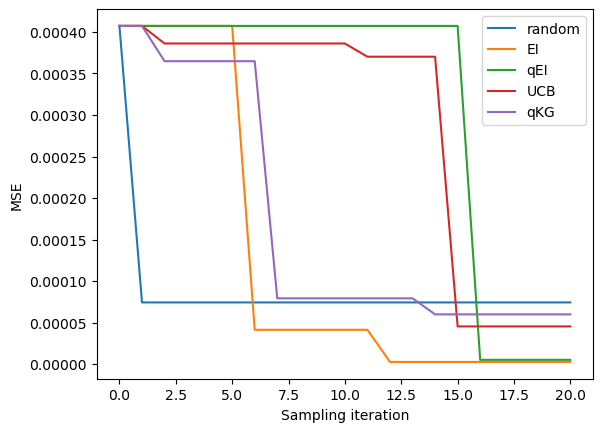

In [68]:
iters = np.arange(N_ROUND + 1) * BATCH_SIZE
plt.plot(iters, np.array(best_random)*-1, label='random')
plt.plot(iters, np.array(best_observed_ei)*-1, label='EI')
plt.plot(iters, np.array(best_observed_qei)*-1, label='qEI')
plt.plot(iters, np.array(best_observed_ucb)*-1, label='UCB')
plt.plot(iters, np.array(best_observed_qkg)*-1, label='qKG')
plt.legend()
plt.xlabel("Sampling iteration")
plt.ylabel("MSE")
plt.show()

[[ 3.16657379e+02  6.98481900e+06  3.11621393e+02  3.14225235e+02
   1.86138805e+01  1.47602912e+01  3.51505377e+01  2.00286170e+01
   5.41273219e+01  4.87753270e+01 -5.23933676e+00 -4.89469974e+00
   3.43627376e+02  3.11621393e+02  2.79615409e+02]
 [ 2.99203094e+02  5.64676600e+06  3.05879596e+02  3.12304036e+02
   1.96981925e+01  1.54228019e+01  3.55356410e+01  2.04501537e+01
   4.05185177e+01  4.20204894e+01 -6.00347866e+00 -5.11645553e+00
   3.34226945e+02  3.05879596e+02  2.77532247e+02]
 [ 2.99203094e+02  3.69597700e+06  3.00404858e+02  3.10709848e+02
   1.79522648e+01  1.51046414e+01  3.64875393e+01  2.09514870e+01
   4.05185177e+01  4.20204894e+01 -6.53374962e+00 -5.39991434e+00
   3.19812149e+02  3.00404858e+02  2.80997568e+02]
 [ 3.12174591e+02  3.51443100e+06  3.05612537e+02  3.10750724e+02
   1.74215633e+01  1.51185068e+01  3.00138117e+01  2.04302350e+01
   5.39599912e+01  4.82031508e+01 -5.83998213e+00 -5.48792790e+00
   3.20313178e+02  3.05612537e+02  2.90911895e+02]
 [ 3

2023-10-26 00:33:38.032827: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:33:38.033037: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 1s 14ms/step - loss: 0.8360
Epoch 2/30
7/7 [==============================] - 0s 13ms/step - loss: 0.2867
Epoch 3/30
7/7 [==============================] - 0s 15ms/step - loss: 0.1258
Epoch 4/30
7/7 [==============================] - 0s 17ms/step - loss: 0.0487
Epoch 5/30
7/7 [==============================] - 0s 19ms/step - loss: 0.0325
Epoch 6/30
7/7 [==============================] - 0s 18ms/step - loss: 0.0260
Epoch 7/30
7/7 [==============================] - 0s 16ms/step - loss: 0.0233
Epoch 8/30
7/7 [==============================] - 0s 16ms/step - loss: 0.0212
Epoch 9/30
7/7 [==============================] - 0s 16ms/step - loss: 0.0198
Epoch 10/30
7/7 [==============================] - 0s 16ms/step - loss: 0.0187
Epoch 11/30
7/7 [==============================] - 0s 18ms/step - loss: 0.0185
Epoch 12/30
7/7 [==============================] - 0s 18ms/step - loss: 0.0177
Epoch 13/30
7/7 [==============================] - 0s 19ms/step - loss: 

2023-10-26 00:33:42.667155: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:33:42.667335: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


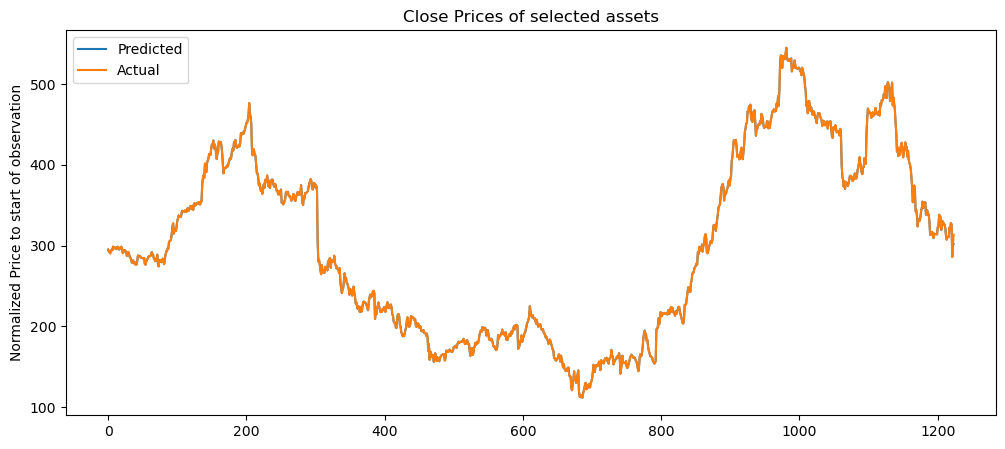

In [74]:
# qKG
mse_list = []
x_list = [[int(x) for x in row.tolist()] for row in train_x_qkg]

qkg_data = {'x':x_list[:21],'mse':best_observed_qkg}
qkg_final = pd.DataFrame(qkg_data)

qkg_test = qkg_final.loc[qkg_final['mse']== (qkg_final['mse'].max()),'x'].values[0]

model1_optimized_qkg = LSTM_predictor(X[0], Y[0])
model1_optimized_qkg.prepare_data(train_test_split = 0.8, timestep = 3, look_forward = 3, inplace = True)
model1_optimized_qkg.init_model(optimizer='adam', loss='mean_squared_error', num_lstm_units = qkg_test[0] ,num_lstm_units_2 = qkg_test[1], num_dense_units = qkg_test[2], learning_rate = qkg_test[4])
model1_optimized_qkg.fit_model_train(epochs=30,batch_size=qkg_test[3])
model1_optimized_qkg.predict()
model1_optimized_qkg.key_metrics()
model1_optimized_qkg.plot_prediction()

In [83]:
model1_optimized_qkg.key_metrics()

(313.7006530761719,
 array([301.84326], dtype=float32),
 0.011138513792767427,
 0.10553915762771383,
 1.0)

[[ 3.16657379e+02  6.98481900e+06  3.11621393e+02  3.14225235e+02
   1.86138805e+01  1.47602912e+01  3.51505377e+01  2.00286170e+01
   5.41273219e+01  4.87753270e+01 -5.23933676e+00 -4.89469974e+00
   3.43627376e+02  3.11621393e+02  2.79615409e+02]
 [ 2.99203094e+02  5.64676600e+06  3.05879596e+02  3.12304036e+02
   1.96981925e+01  1.54228019e+01  3.55356410e+01  2.04501537e+01
   4.05185177e+01  4.20204894e+01 -6.00347866e+00 -5.11645553e+00
   3.34226945e+02  3.05879596e+02  2.77532247e+02]
 [ 2.99203094e+02  3.69597700e+06  3.00404858e+02  3.10709848e+02
   1.79522648e+01  1.51046414e+01  3.64875393e+01  2.09514870e+01
   4.05185177e+01  4.20204894e+01 -6.53374962e+00 -5.39991434e+00
   3.19812149e+02  3.00404858e+02  2.80997568e+02]
 [ 3.12174591e+02  3.51443100e+06  3.05612537e+02  3.10750724e+02
   1.74215633e+01  1.51185068e+01  3.00138117e+01  2.04302350e+01
   5.39599912e+01  4.82031508e+01 -5.83998213e+00 -5.48792790e+00
   3.20313178e+02  3.05612537e+02  2.90911895e+02]
 [ 3

2023-10-26 00:34:44.094708: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:34:44.094910: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 13ms/step - loss: 0.8360
Epoch 2/30
7/7 [==============================] - 0s 13ms/step - loss: 0.2867
Epoch 3/30
7/7 [==============================] - 0s 12ms/step - loss: 0.1258
Epoch 4/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0487
Epoch 5/30
7/7 [==============================] - 0s 19ms/step - loss: 0.0325
Epoch 6/30
7/7 [==============================] - 0s 19ms/step - loss: 0.0260
Epoch 7/30
7/7 [==============================] - 0s 17ms/step - loss: 0.0233
Epoch 8/30
7/7 [==============================] - 0s 16ms/step - loss: 0.0212
Epoch 9/30
7/7 [==============================] - 0s 19ms/step - loss: 0.0198
Epoch 10/30
7/7 [==============================] - 0s 15ms/step - loss: 0.0187
Epoch 11/30
7/7 [==============================] - 0s 16ms/step - loss: 0.0185
Epoch 12/30
7/7 [==============================] - 0s 16ms/step - loss: 0.0177
Epoch 13/30
7/7 [==============================] - 0s 17ms/step - loss: 

2023-10-26 00:34:49.511363: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:34:49.511551: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


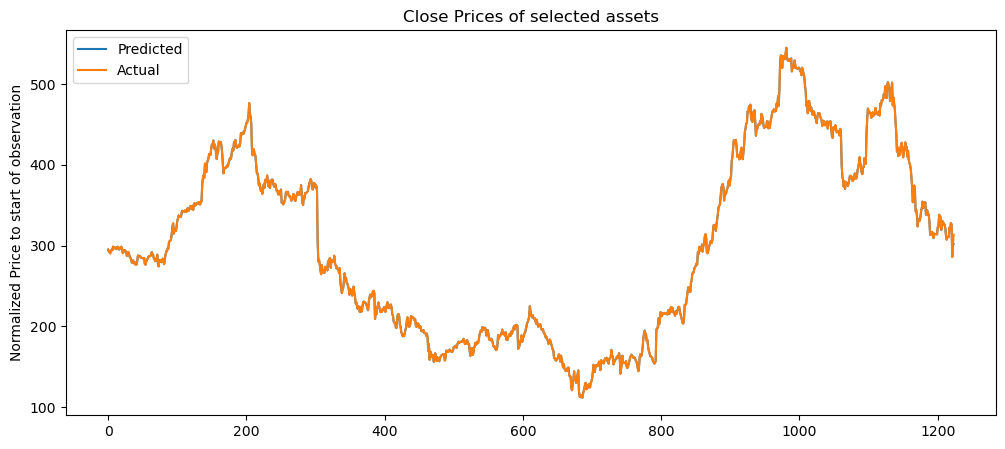

In [76]:
# UCB
mse_list = []
x_list = [[int(x) for x in row.tolist()] for row in train_x_ucb]

ucb_data = {'x':x_list[:21],'mse':best_observed_ucb}
ucb_final = pd.DataFrame(ucb_data)

ucb_test = ucb_final.loc[ucb_final['mse']== (ucb_final['mse'].max()),'x'].values[0]

model1_optimized_ucb = LSTM_predictor(X[0], Y[0])
model1_optimized_ucb.prepare_data(train_test_split = 0.8, timestep = 3, look_forward = 3, inplace = True)
model1_optimized_ucb.init_model(optimizer='adam', loss='mean_squared_error', num_lstm_units = qkg_test[0] ,num_lstm_units_2 = qkg_test[1], num_dense_units = qkg_test[2], learning_rate = qkg_test[4])
model1_optimized_ucb.fit_model_train(epochs=30,batch_size=qkg_test[3])
model1_optimized_ucb.predict()
model1_optimized_ucb.key_metrics()
model1_optimized_ucb.plot_prediction()

In [82]:
model1_optimized_ucb.key_metrics()

(313.7006530761719,
 array([301.84326], dtype=float32),
 0.011138513792767427,
 0.10553915762771383,
 1.0)

[[ 3.16657379e+02  6.98481900e+06  3.11621393e+02  3.14225235e+02
   1.86138805e+01  1.47602912e+01  3.51505377e+01  2.00286170e+01
   5.41273219e+01  4.87753270e+01 -5.23933676e+00 -4.89469974e+00
   3.43627376e+02  3.11621393e+02  2.79615409e+02]
 [ 2.99203094e+02  5.64676600e+06  3.05879596e+02  3.12304036e+02
   1.96981925e+01  1.54228019e+01  3.55356410e+01  2.04501537e+01
   4.05185177e+01  4.20204894e+01 -6.00347866e+00 -5.11645553e+00
   3.34226945e+02  3.05879596e+02  2.77532247e+02]
 [ 2.99203094e+02  3.69597700e+06  3.00404858e+02  3.10709848e+02
   1.79522648e+01  1.51046414e+01  3.64875393e+01  2.09514870e+01
   4.05185177e+01  4.20204894e+01 -6.53374962e+00 -5.39991434e+00
   3.19812149e+02  3.00404858e+02  2.80997568e+02]
 [ 3.12174591e+02  3.51443100e+06  3.05612537e+02  3.10750724e+02
   1.74215633e+01  1.51185068e+01  3.00138117e+01  2.04302350e+01
   5.39599912e+01  4.82031508e+01 -5.83998213e+00 -5.48792790e+00
   3.20313178e+02  3.05612537e+02  2.90911895e+02]
 [ 3

2023-10-26 00:35:27.802426: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:35:27.802624: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 1s 13ms/step - loss: 0.8360
Epoch 2/30
7/7 [==============================] - 0s 12ms/step - loss: 0.2867
Epoch 3/30
7/7 [==============================] - 0s 12ms/step - loss: 0.1258
Epoch 4/30
7/7 [==============================] - 0s 12ms/step - loss: 0.0487
Epoch 5/30
7/7 [==============================] - 0s 12ms/step - loss: 0.0325
Epoch 6/30
7/7 [==============================] - 0s 14ms/step - loss: 0.0260
Epoch 7/30
7/7 [==============================] - 0s 14ms/step - loss: 0.0233
Epoch 8/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0212
Epoch 9/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0198
Epoch 10/30
7/7 [==============================] - 0s 14ms/step - loss: 0.0187
Epoch 11/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0185
Epoch 12/30
7/7 [==============================] - 0s 14ms/step - loss: 0.0177
Epoch 13/30
7/7 [==============================] - 0s 14ms/step - loss: 

2023-10-26 00:35:32.144209: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:35:32.144388: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


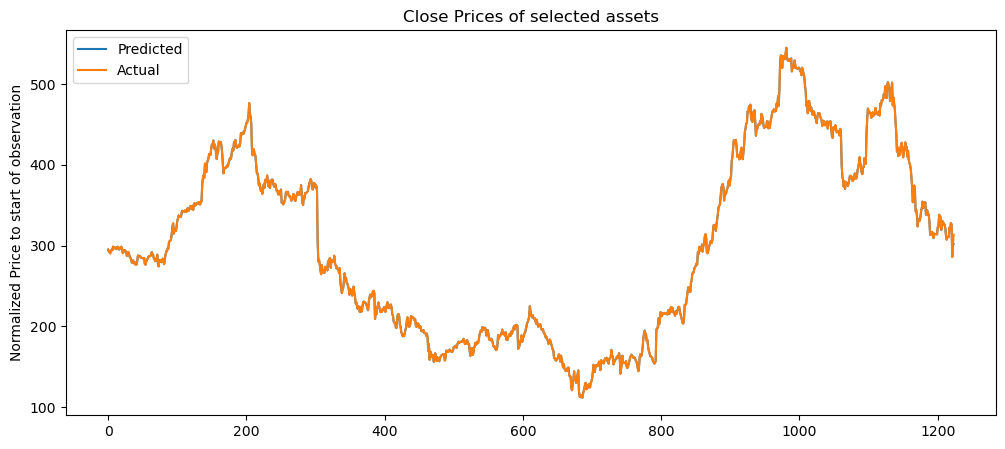

In [78]:
# qEI
mse_list = []
x_list = [[int(x) for x in row.tolist()] for row in train_x_qei]

qei_data = {'x':x_list[:21],'mse':best_observed_qei}
qei_final = pd.DataFrame(qei_data)

qei_test = qei_final.loc[qei_final['mse']== (qei_final['mse'].max()),'x'].values[0]

model1_optimized_qei = LSTM_predictor(X[0], Y[0])
model1_optimized_qei.prepare_data(train_test_split = 0.8, timestep = 3, look_forward = 3, inplace = True)
model1_optimized_qei.init_model(optimizer='adam', loss='mean_squared_error', num_lstm_units = qkg_test[0] ,num_lstm_units_2 = qkg_test[1], num_dense_units = qkg_test[2], learning_rate = qkg_test[4])
model1_optimized_qei.fit_model_train(epochs=30,batch_size=qkg_test[3])
model1_optimized_qei.predict()
model1_optimized_qei.key_metrics()
model1_optimized_qei.plot_prediction()

In [81]:
model1_optimized_qei.key_metrics()

(313.7006530761719,
 array([301.84326], dtype=float32),
 0.011138513792767427,
 0.10553915762771383,
 1.0)

[[ 3.16657379e+02  6.98481900e+06  3.11621393e+02  3.14225235e+02
   1.86138805e+01  1.47602912e+01  3.51505377e+01  2.00286170e+01
   5.41273219e+01  4.87753270e+01 -5.23933676e+00 -4.89469974e+00
   3.43627376e+02  3.11621393e+02  2.79615409e+02]
 [ 2.99203094e+02  5.64676600e+06  3.05879596e+02  3.12304036e+02
   1.96981925e+01  1.54228019e+01  3.55356410e+01  2.04501537e+01
   4.05185177e+01  4.20204894e+01 -6.00347866e+00 -5.11645553e+00
   3.34226945e+02  3.05879596e+02  2.77532247e+02]
 [ 2.99203094e+02  3.69597700e+06  3.00404858e+02  3.10709848e+02
   1.79522648e+01  1.51046414e+01  3.64875393e+01  2.09514870e+01
   4.05185177e+01  4.20204894e+01 -6.53374962e+00 -5.39991434e+00
   3.19812149e+02  3.00404858e+02  2.80997568e+02]
 [ 3.12174591e+02  3.51443100e+06  3.05612537e+02  3.10750724e+02
   1.74215633e+01  1.51185068e+01  3.00138117e+01  2.04302350e+01
   5.39599912e+01  4.82031508e+01 -5.83998213e+00 -5.48792790e+00
   3.20313178e+02  3.05612537e+02  2.90911895e+02]
 [ 3

2023-10-26 00:35:51.476628: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:35:51.476815: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 1s 12ms/step - loss: 0.8360
Epoch 2/30
7/7 [==============================] - 0s 12ms/step - loss: 0.2867
Epoch 3/30
7/7 [==============================] - 0s 12ms/step - loss: 0.1258
Epoch 4/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0487
Epoch 5/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0325
Epoch 6/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0260
Epoch 7/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0233
Epoch 8/30
7/7 [==============================] - 0s 13ms/step - loss: 0.0212
Epoch 9/30
7/7 [==============================] - 0s 14ms/step - loss: 0.0198
Epoch 10/30
7/7 [==============================] - 0s 14ms/step - loss: 0.0187
Epoch 11/30
7/7 [==============================] - 0s 14ms/step - loss: 0.0185
Epoch 12/30
7/7 [==============================] - 0s 14ms/step - loss: 0.0177
Epoch 13/30
7/7 [==============================] - 0s 13ms/step - loss: 

2023-10-26 00:35:55.805740: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:35:55.805950: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


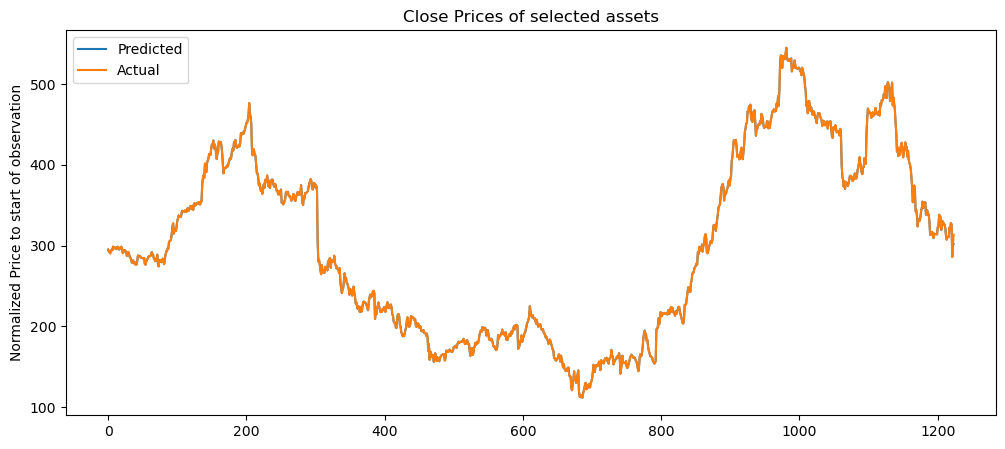

In [79]:
# EI
mse_list = []
x_list = [[int(x) for x in row.tolist()] for row in train_x_ei]

ei_data = {'x':x_list[:21],'mse':best_observed_ei}
ei_final = pd.DataFrame(ei_data)

ei_test = ei_final.loc[ei_final['mse']== (ei_final['mse'].max()),'x'].values[0]

model1_optimized_ei = LSTM_predictor(X[0], Y[0])
model1_optimized_ei.prepare_data(train_test_split = 0.8, timestep = 3, look_forward = 3, inplace = True)
model1_optimized_ei.init_model(optimizer='adam', loss='mean_squared_error', num_lstm_units = qkg_test[0] ,num_lstm_units_2 = qkg_test[1], num_dense_units = qkg_test[2], learning_rate = qkg_test[4])
model1_optimized_ei.fit_model_train(epochs=30,batch_size=qkg_test[3])
model1_optimized_ei.predict()
model1_optimized_ei.key_metrics()
model1_optimized_ei.plot_prediction()

In [80]:
model1_optimized_ei.key_metrics()

(313.7006530761719,
 array([301.84326], dtype=float32),
 0.011138513792767427,
 0.10553915762771383,
 1.0)

In [84]:
# multiple trials
# number of runs to assess std of different BO loops
N_TRIALS = 4
# indicator to print diagnostics
verbose = True
# number of steps in the outer BO loop
N_ROUND = 20
best_random_all, best_observed_ei_all, best_observed_qei_all, best_observed_ucb_all, best_observed_qkg_all = [], [], [], [], []

# average over multiple trials
for trial in range(1, N_TRIALS + 1):
    
    best_random, best_observed_ei, best_observed_qei, best_observed_ucb, best_observed_qkg  = [], [], [], [], []
    
    # call helper functions to generate initial training data and initialize model
#     train_x, train_y, best_observed_value = generate_initial_data(n=3)
    train_x_ei = train_x
    train_x_qei = train_x
    train_x_ucb = train_x
    train_x_qkg = train_x
    train_y_ei = train_y
    train_y_qei = train_y
    train_y_ucb = train_y
    train_y_qkg = train_y

    mll_ei, model_ei = initialize_model(train_x_ei, train_y_ei)
    mll_qei, model_qei = initialize_model(train_x_qei, train_y_qei)
    mll_ucb, model_ucb = initialize_model(train_x_ucb, train_y_ucb)
    mll_qkg, model_qkg = initialize_model(train_x_qkg, train_y_qkg)

    best_random.append(best_observed_value)
    best_observed_ei.append(best_observed_value)
    best_observed_qei.append(best_observed_value)
    best_observed_ucb.append(best_observed_value)
    best_observed_qkg.append(best_observed_value)

    # run N_ROUND rounds of BayesOpt after the initial random batch
    for iteration in range(1, N_ROUND + 1):    
        t0 = time.monotonic()
        # fit the models
        fit_gpytorch_mll(mll_ei)
        fit_gpytorch_mll(mll_qei)
        fit_gpytorch_mll(mll_ucb)
        fit_gpytorch_mll(mll_qkg)

        # for best_f, we use the best observed exact values
        EI = ExpectedImprovement(model=model_ei, best_f=train_y_ei.max())
        qEI = qExpectedImprovement(model=model_qei, 
                                  best_f=train_y_ei.max(),
                                  num_samples=1024
                                  )
        UCB = UpperConfidenceBound(model=model_ucb, beta=beta)
        qKG = qKnowledgeGradient(
            model=model_qkg,
            num_fantasies=64,
            objective=None,
            X_baseline=train_x_qkg,
        )
        
        # optimize and get new observation
        new_x_ei, new_y_ei = optimize_acqf_and_get_observation(EI)
        new_x_qei, new_y_qei = optimize_acqf_and_get_observation(qEI)
        new_x_ucb, new_y_ucb = optimize_acqf_and_get_observation(UCB)
        new_x_qkg, new_y_qkg = optimize_acqf_and_get_observation(qKG)
                
        # update training points
        train_x_ei = torch.cat([train_x_ei, new_x_ei], dim=0)
        train_x_qei = torch.cat([train_x_qei, new_x_qei], dim=0)
        train_x_ucb = torch.cat([train_x_ucb, new_x_ucb], dim=0)
        train_x_qkg = torch.cat([train_x_qkg, new_x_qkg], dim=0)
        train_y_ei = torch.cat([train_y_ei, new_y_ei], dim=0)
        train_y_qei = torch.cat([train_y_qei, new_y_qei], dim=0)
        train_y_ucb = torch.cat([train_y_ucb, new_y_ucb], dim=0)
        train_y_qkg = torch.cat([train_y_qkg, new_y_qkg], dim=0)

        # update progress
        best_random = update_random_observations(best_random)
        best_value_ei = max(best_observed_ei[-1], new_y_ei.item())  
        best_value_qei = max(best_observed_qei[-1], new_y_qei.item())  
        best_value_ucb = max(best_observed_ucb[-1], new_y_ucb.item())  
        best_value_qkg = max(best_observed_qkg[-1], new_y_qkg.item())  

        best_observed_ei.append(best_value_ei)
        best_observed_qei.append(best_value_qei)
        best_observed_ucb.append(best_value_ucb)
        best_observed_qkg.append(best_value_qkg)

        # reinitialize the models so they are ready for fitting on next iteration
        mll_ei, model_ei = initialize_model(
            train_x_ei, 
            train_y_ei
        )
        mll_qei, model_qei = initialize_model(
            train_x_qei, 
            train_y_qei
        )
        mll_ucb, model_ucb = initialize_model(
            train_x_ucb, 
            train_y_ucb
        )
        mll_qkg, model_qkg = initialize_model(
            train_x_qkg, 
            train_y_qkg
        )

        t1 = time.monotonic()
   
    best_observed_ei_all.append(best_observed_ei)
    best_observed_qei_all.append(best_observed_qei)
    best_observed_ucb_all.append(best_observed_ucb)
    best_observed_qkg_all.append(best_observed_qkg)
    best_random_all.append(best_random)

/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:37:23.695011: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:23.695231: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


13/13 [==============================] - 2s 9ms/step - loss: 0.2438
Epoch 2/5
13/13 [==============================] - 0s 10ms/step - loss: 0.0468
Epoch 3/5
13/13 [==============================] - 0s 12ms/step - loss: 0.0269
Epoch 4/5
13/13 [==============================] - 0s 14ms/step - loss: 0.0211
Epoch 5/5
13/13 [==============================] - 0s 12ms/step - loss: 0.0193


2023-10-26 00:37:26.037430: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:26.037610: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 364ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:37:26.688427: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:26.688634: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 19ms/step - loss: 0.3704
Epoch 2/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0754
Epoch 3/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0425
Epoch 4/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0325
Epoch 5/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0245


2023-10-26 00:37:29.075686: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:29.075889: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:37:29.777352: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:29.777543: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 25ms/step - loss: 0.3395
Epoch 2/5
8/8 [==============================] - 0s 47ms/step - loss: 0.0635
Epoch 3/5
8/8 [==============================] - 0s 37ms/step - loss: 0.0389
Epoch 4/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0281
Epoch 5/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0226


2023-10-26 00:37:33.403081: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:33.403303: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 390ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:37:34.337897: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:34.338087: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 25ms/step - loss: 0.3467
Epoch 2/5
7/7 [==============================] - 0s 47ms/step - loss: 0.0715
Epoch 3/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0405
Epoch 4/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0314
Epoch 5/5
7/7 [==============================] - 0s 34ms/step - loss: 0.0250


2023-10-26 00:37:37.112810: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:37.113059: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 397ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:37:37.766714: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:37.766907: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 11ms/step - loss: 0.4549
Epoch 2/5
8/8 [==============================] - 0s 12ms/step - loss: 0.1070
Epoch 3/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0586
Epoch 4/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0326
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0255


2023-10-26 00:37:39.848503: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:39.848710: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:37:41.175157: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:41.175361: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 5ms/step - loss: 0.8289
Epoch 2/5
7/7 [==============================] - 0s 5ms/step - loss: 0.3523
Epoch 3/5
7/7 [==============================] - 0s 5ms/step - loss: 0.1065
Epoch 4/5
7/7 [==============================] - 0s 5ms/step - loss: 0.0851
Epoch 5/5
7/7 [==============================] - 0s 5ms/step - loss: 0.0440


2023-10-26 00:37:42.908302: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:42.908460: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 357ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:37:43.581397: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:43.581599: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 18ms/step - loss: 0.2951
Epoch 2/5
10/10 [==============================] - 0s 20ms/step - loss: 0.0553
Epoch 3/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0362
Epoch 4/5
10/10 [==============================] - 0s 23ms/step - loss: 0.0236
Epoch 5/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0212


2023-10-26 00:37:46.298807: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:46.299017: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:37:47.029601: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:47.029795: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 3s 33ms/step - loss: 0.2141
Epoch 2/5
12/12 [==============================] - 0s 35ms/step - loss: 0.0429
Epoch 3/5
12/12 [==============================] - 0s 32ms/step - loss: 0.0239
Epoch 4/5
12/12 [==============================] - 0s 32ms/step - loss: 0.0207
Epoch 5/5
12/12 [==============================] - 0s 33ms/step - loss: 0.0247


2023-10-26 00:37:51.244741: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:51.245064: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:37:52.047734: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:52.047935: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 21ms/step - loss: 0.4071
Epoch 2/5
8/8 [==============================] - 0s 28ms/step - loss: 0.0824
Epoch 3/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0441
Epoch 4/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0318
Epoch 5/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0245


2023-10-26 00:37:54.687648: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:54.687861: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:37:55.308488: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:55.308724: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 7ms/step - loss: 0.4051
Epoch 2/5
10/10 [==============================] - 0s 7ms/step - loss: 0.0813
Epoch 3/5
10/10 [==============================] - 0s 7ms/step - loss: 0.0424
Epoch 4/5
10/10 [==============================] - 0s 8ms/step - loss: 0.0293
Epoch 5/5
10/10 [==============================] - 0s 10ms/step - loss: 0.0224


2023-10-26 00:37:57.338664: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:37:57.338856: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 364ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:37:58.196253: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:37:58.196446: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 10ms/step - loss: 0.4313
Epoch 2/5
11/11 [==============================] - 0s 6ms/step - loss: 0.0981
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0473
Epoch 4/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0298
Epoch 5/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0239


2023-10-26 00:38:00.336787: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:00.337007: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 414ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:01.324402: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:01.324589: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 35ms/step - loss: 0.2356
Epoch 2/5
10/10 [==============================] - 0s 42ms/step - loss: 0.0478
Epoch 3/5
10/10 [==============================] - 0s 41ms/step - loss: 0.0265
Epoch 4/5
10/10 [==============================] - 0s 39ms/step - loss: 0.0219
Epoch 5/5
10/10 [==============================] - 0s 39ms/step - loss: 0.0185


2023-10-26 00:38:04.971519: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:04.971747: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 389ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:38:06.698918: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:06.699138: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 11ms/step - loss: 0.2925
Epoch 2/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0489
Epoch 3/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0323
Epoch 4/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0246
Epoch 5/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0214


2023-10-26 00:38:08.856992: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:08.857152: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 358ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:09.682021: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:09.682214: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 37ms/step - loss: 0.2627
Epoch 2/5
9/9 [==============================] - 0s 41ms/step - loss: 0.0677
Epoch 3/5
9/9 [==============================] - 0s 40ms/step - loss: 0.0305
Epoch 4/5
9/9 [==============================] - 0s 41ms/step - loss: 0.0238
Epoch 5/5
9/9 [==============================] - 0s 35ms/step - loss: 0.0203


2023-10-26 00:38:13.073483: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:13.073699: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:13.847619: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:13.847807: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 56ms/step - loss: 0.2934
Epoch 2/5
7/7 [==============================] - 1s 75ms/step - loss: 0.0848
Epoch 3/5
7/7 [==============================] - 0s 68ms/step - loss: 0.0479
Epoch 4/5
7/7 [==============================] - 1s 79ms/step - loss: 0.0281
Epoch 5/5
7/7 [==============================] - 0s 66ms/step - loss: 0.0239


2023-10-26 00:38:17.934562: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:17.934782: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 396ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:38:19.001838: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:19.002032: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 13ms/step - loss: 0.2784
Epoch 2/5
11/11 [==============================] - 0s 13ms/step - loss: 0.0530
Epoch 3/5
11/11 [==============================] - 0s 14ms/step - loss: 0.0333
Epoch 4/5
11/11 [==============================] - 0s 16ms/step - loss: 0.0221
Epoch 5/5
11/11 [==============================] - 0s 15ms/step - loss: 0.0196


2023-10-26 00:38:21.405548: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:21.405726: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:22.074334: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:22.074525: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 17ms/step - loss: 0.3896
Epoch 2/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0940
Epoch 3/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0581
Epoch 4/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0366
Epoch 5/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0267


2023-10-26 00:38:24.406610: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:24.406815: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:25.962835: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:25.963037: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 22ms/step - loss: 0.2307
Epoch 2/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0422
Epoch 3/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0240
Epoch 4/5
12/12 [==============================] - 0s 26ms/step - loss: 0.0192
Epoch 5/5
12/12 [==============================] - 0s 26ms/step - loss: 0.0186


2023-10-26 00:38:29.098023: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:29.098238: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:30.019753: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:30.019945: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.2946
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0636
Epoch 3/5
8/8 [==============================] - 0s 12ms/step - loss: 0.0421
Epoch 4/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0293
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0232


2023-10-26 00:38:32.166865: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:32.167079: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:32.789401: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:32.789588: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 9ms/step - loss: 0.5925
Epoch 2/5
8/8 [==============================] - 0s 9ms/step - loss: 0.1030
Epoch 3/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0509
Epoch 4/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0337
Epoch 5/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0283


2023-10-26 00:38:34.743661: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:34.743850: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 363ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:38:35.523461: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:35.523648: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 22ms/step - loss: 0.3244
Epoch 2/5
7/7 [==============================] - 0s 22ms/step - loss: 0.0654
Epoch 3/5
7/7 [==============================] - 0s 23ms/step - loss: 0.0443
Epoch 4/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0308
Epoch 5/5
7/7 [==============================] - 0s 23ms/step - loss: 0.0244


2023-10-26 00:38:37.978978: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:37.979204: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:38.627968: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:38.628155: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 8ms/step - loss: 0.5829
Epoch 2/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0982
Epoch 3/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0574
Epoch 4/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0493
Epoch 5/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0293


2023-10-26 00:38:40.489533: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:40.489697: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 356ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:41.132042: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:41.132231: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 3s 17ms/step - loss: 0.2666
Epoch 2/5
10/10 [==============================] - 0s 17ms/step - loss: 0.0590
Epoch 3/5
10/10 [==============================] - 0s 21ms/step - loss: 0.0401
Epoch 4/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0261
Epoch 5/5
10/10 [==============================] - 0s 20ms/step - loss: 0.0227


2023-10-26 00:38:44.610212: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:44.610407: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:45.562041: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:45.562230: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 48ms/step - loss: 0.2512
Epoch 2/5
9/9 [==============================] - 1s 61ms/step - loss: 0.0538
Epoch 3/5
9/9 [==============================] - 1s 58ms/step - loss: 0.0304
Epoch 4/5
9/9 [==============================] - 1s 58ms/step - loss: 0.0242
Epoch 5/5
9/9 [==============================] - 1s 58ms/step - loss: 0.0211


2023-10-26 00:38:49.746274: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:49.746519: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:50.471021: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:50.471215: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 36ms/step - loss: 0.2651
Epoch 2/5
8/8 [==============================] - 0s 51ms/step - loss: 0.0657
Epoch 3/5
8/8 [==============================] - 0s 43ms/step - loss: 0.0359
Epoch 4/5
8/8 [==============================] - 0s 43ms/step - loss: 0.0242
Epoch 5/5
8/8 [==============================] - 0s 43ms/step - loss: 0.0217


2023-10-26 00:38:53.792112: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:53.792314: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:38:54.940999: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:54.941189: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 61ms/step - loss: 0.2994
Epoch 2/5
7/7 [==============================] - 0s 59ms/step - loss: 0.0794
Epoch 3/5
7/7 [==============================] - 0s 56ms/step - loss: 0.0484
Epoch 4/5
7/7 [==============================] - 0s 57ms/step - loss: 0.0293
Epoch 5/5
7/7 [==============================] - 0s 56ms/step - loss: 0.0248


2023-10-26 00:38:58.585861: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:38:58.586072: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 387ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:38:59.321083: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:38:59.321277: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 30ms/step - loss: 0.2768
Epoch 2/5
8/8 [==============================] - 0s 42ms/step - loss: 0.0634
Epoch 3/5
8/8 [==============================] - 0s 37ms/step - loss: 0.0423
Epoch 4/5
8/8 [==============================] - 0s 38ms/step - loss: 0.0274
Epoch 5/5
8/8 [==============================] - 0s 37ms/step - loss: 0.0222


2023-10-26 00:39:02.417649: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:02.417897: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:39:04.052375: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:04.052563: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 24ms/step - loss: 0.3744
Epoch 2/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0845
Epoch 3/5
7/7 [==============================] - 0s 35ms/step - loss: 0.0487
Epoch 4/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0349
Epoch 5/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0276


2023-10-26 00:39:06.667884: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:06.668093: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:39:07.611588: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:07.611793: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 44ms/step - loss: 0.2545
Epoch 2/5
8/8 [==============================] - 0s 58ms/step - loss: 0.0694
Epoch 3/5
8/8 [==============================] - 0s 53ms/step - loss: 0.0386
Epoch 4/5
8/8 [==============================] - 0s 54ms/step - loss: 0.0246
Epoch 5/5
8/8 [==============================] - 0s 54ms/step - loss: 0.0210


2023-10-26 00:39:11.306264: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:11.306471: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:39:11.947548: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:11.947742: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 12ms/step - loss: 0.2767
Epoch 2/5
11/11 [==============================] - 0s 13ms/step - loss: 0.0494
Epoch 3/5
11/11 [==============================] - 0s 13ms/step - loss: 0.0331
Epoch 4/5
11/11 [==============================] - 0s 15ms/step - loss: 0.0226
Epoch 5/5
11/11 [==============================] - 0s 15ms/step - loss: 0.0204


2023-10-26 00:39:14.273647: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:14.273854: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:39:15.278877: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:15.279061: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 31ms/step - loss: 0.2252
Epoch 2/5
10/10 [==============================] - 0s 42ms/step - loss: 0.0477
Epoch 3/5
10/10 [==============================] - 0s 37ms/step - loss: 0.0281
Epoch 4/5
10/10 [==============================] - 0s 38ms/step - loss: 0.0230
Epoch 5/5
10/10 [==============================] - 0s 38ms/step - loss: 0.0202


2023-10-26 00:39:18.736741: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:18.736949: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:39:19.431792: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:19.431979: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 25ms/step - loss: 0.2721
Epoch 2/5
8/8 [==============================] - 0s 29ms/step - loss: 0.0620
Epoch 3/5
8/8 [==============================] - 0s 34ms/step - loss: 0.0393
Epoch 4/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0251
Epoch 5/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0220


2023-10-26 00:39:22.210363: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:22.210587: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:39:23.797860: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:23.798051: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 23ms/step - loss: 0.4159
Epoch 2/5
8/8 [==============================] - 0s 28ms/step - loss: 0.0891
Epoch 3/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0493
Epoch 4/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0329
Epoch 5/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0263


2023-10-26 00:39:26.564586: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:26.564795: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 395ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:39:27.472035: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:27.472228: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 23ms/step - loss: 0.3153
Epoch 2/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0540
Epoch 3/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0366
Epoch 4/5
8/8 [==============================] - 0s 39ms/step - loss: 0.0271
Epoch 5/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0225


2023-10-26 00:39:30.261139: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:30.261353: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 403ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:39:30.989405: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:30.989599: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 22ms/step - loss: 0.3339
Epoch 2/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0685
Epoch 3/5
8/8 [==============================] - 0s 37ms/step - loss: 0.0386
Epoch 4/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0299
Epoch 5/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0244


2023-10-26 00:39:33.730522: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:33.730730: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:39:34.863926: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:34.864121: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 45ms/step - loss: 0.2438
Epoch 2/5
8/8 [==============================] - 0s 49ms/step - loss: 0.0636
Epoch 3/5
8/8 [==============================] - 0s 49ms/step - loss: 0.0376
Epoch 4/5
8/8 [==============================] - 0s 43ms/step - loss: 0.0252
Epoch 5/5
8/8 [==============================] - 0s 43ms/step - loss: 0.0204


2023-10-26 00:39:38.463896: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:38.464156: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:39:39.227266: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:39.227453: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 41ms/step - loss: 0.2598
Epoch 2/5
8/8 [==============================] - 0s 57ms/step - loss: 0.0662
Epoch 3/5
8/8 [==============================] - 0s 56ms/step - loss: 0.0358
Epoch 4/5
8/8 [==============================] - 0s 49ms/step - loss: 0.0243
Epoch 5/5
8/8 [==============================] - 1s 88ms/step - loss: 0.0217


2023-10-26 00:39:43.543348: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:43.543604: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 537ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:39:44.449165: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:44.449353: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 3s 23ms/step - loss: 0.2759
Epoch 2/5
10/10 [==============================] - 0s 39ms/step - loss: 0.0595
Epoch 3/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0278
Epoch 4/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0225
Epoch 5/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0196


2023-10-26 00:39:48.639027: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:48.639255: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 391ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:39:49.532660: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:49.532851: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 17ms/step - loss: 0.2936
Epoch 2/5
10/10 [==============================] - 0s 17ms/step - loss: 0.0632
Epoch 3/5
10/10 [==============================] - 0s 17ms/step - loss: 0.0331
Epoch 4/5
10/10 [==============================] - 0s 18ms/step - loss: 0.0231
Epoch 5/5
10/10 [==============================] - 0s 18ms/step - loss: 0.0203


2023-10-26 00:39:52.120832: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:52.120999: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:39:52.799957: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:52.800144: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 28ms/step - loss: 0.2244
Epoch 2/5
10/10 [==============================] - 0s 43ms/step - loss: 0.0563
Epoch 3/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0292
Epoch 4/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0202
Epoch 5/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0191


2023-10-26 00:39:55.949384: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:39:55.949606: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 418ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:39:57.148694: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:39:57.148890: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 19ms/step - loss: 0.2742
Epoch 2/5
11/11 [==============================] - 0s 18ms/step - loss: 0.0634
Epoch 3/5
11/11 [==============================] - 0s 19ms/step - loss: 0.0281
Epoch 4/5
11/11 [==============================] - 0s 31ms/step - loss: 0.0218
Epoch 5/5
11/11 [==============================] - 0s 23ms/step - loss: 0.0194


2023-10-26 00:40:00.038163: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:00.038379: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:40:00.732022: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:00.732210: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 26ms/step - loss: 0.2983
Epoch 2/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0566
Epoch 3/5
7/7 [==============================] - 0s 38ms/step - loss: 0.0360
Epoch 4/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0267
Epoch 5/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0229


2023-10-26 00:40:03.452485: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:03.452699: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:40:05.108119: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:05.108319: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 18ms/step - loss: 0.4272
Epoch 2/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0909
Epoch 3/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0503
Epoch 4/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0332
Epoch 5/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0258


2023-10-26 00:40:07.569507: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:07.569686: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:40:08.445877: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:08.446077: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 18ms/step - loss: 0.2352
Epoch 2/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0455
Epoch 3/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0253
Epoch 4/5
12/12 [==============================] - 0s 21ms/step - loss: 0.0211
Epoch 5/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0190


2023-10-26 00:40:11.314588: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:11.314792: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:40:12.006016: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:12.006207: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 26ms/step - loss: 0.2372
Epoch 2/5
9/9 [==============================] - 0s 34ms/step - loss: 0.0618
Epoch 3/5
9/9 [==============================] - 0s 34ms/step - loss: 0.0328
Epoch 4/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0229
Epoch 5/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0208


2023-10-26 00:40:15.040894: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:15.041097: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:40:16.247895: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:16.248091: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 25ms/step - loss: 0.3389
Epoch 2/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0614
Epoch 3/5
7/7 [==============================] - 0s 27ms/step - loss: 0.0392
Epoch 4/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0295
Epoch 5/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0229


2023-10-26 00:40:18.919070: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:18.919308: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 382ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:40:19.713880: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:19.714069: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 50ms/step - loss: 0.2657
Epoch 2/5
8/8 [==============================] - 1s 61ms/step - loss: 0.0623
Epoch 3/5
8/8 [==============================] - 0s 59ms/step - loss: 0.0339
Epoch 4/5
8/8 [==============================] - 0s 58ms/step - loss: 0.0285
Epoch 5/5
8/8 [==============================] - 0s 59ms/step - loss: 0.0220


2023-10-26 00:40:23.617833: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:23.618076: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:40:25.205434: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:25.205637: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 23ms/step - loss: 0.2482
Epoch 2/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0541
Epoch 3/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0271
Epoch 4/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0220
Epoch 5/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0191


2023-10-26 00:40:28.248779: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:28.249029: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 420ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:40:29.255545: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:29.255735: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 25ms/step - loss: 0.2528
Epoch 2/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0543
Epoch 3/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0267
Epoch 4/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0228
Epoch 5/5
10/10 [==============================] - 0s 39ms/step - loss: 0.0197


2023-10-26 00:40:32.498672: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:32.498929: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 387ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:40:33.258142: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:33.258411: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 23ms/step - loss: 0.2879
Epoch 2/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0593
Epoch 3/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0405
Epoch 4/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0255
Epoch 5/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0212


2023-10-26 00:40:36.035906: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:36.036064: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:40:37.264724: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:37.264913: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 20ms/step - loss: 0.2179
Epoch 2/5
11/11 [==============================] - 0s 23ms/step - loss: 0.0507
Epoch 3/5
11/11 [==============================] - 0s 26ms/step - loss: 0.0245
Epoch 4/5
11/11 [==============================] - 0s 23ms/step - loss: 0.0227
Epoch 5/5
11/11 [==============================] - 0s 24ms/step - loss: 0.0192


2023-10-26 00:40:40.170559: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:40.170762: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:40:40.839308: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:40.839496: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.3382
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0819
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0506
Epoch 4/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0301
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0256


2023-10-26 00:40:43.033569: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:43.033816: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:40:43.752865: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:43.753053: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 27ms/step - loss: 0.3246
Epoch 2/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0674
Epoch 3/5
7/7 [==============================] - 0s 38ms/step - loss: 0.0404
Epoch 4/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0322
Epoch 5/5
7/7 [==============================] - 0s 34ms/step - loss: 0.0249


2023-10-26 00:40:47.408095: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:47.408321: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:40:48.259412: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:48.259602: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 14ms/step - loss: 0.3340
Epoch 2/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0630
Epoch 3/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0375
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0296
Epoch 5/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0228


2023-10-26 00:40:50.494639: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:50.494848: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:40:51.154155: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:51.154346: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 23ms/step - loss: 0.2902
Epoch 2/5
8/8 [==============================] - 0s 25ms/step - loss: 0.0580
Epoch 3/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0395
Epoch 4/5
8/8 [==============================] - 0s 27ms/step - loss: 0.0253
Epoch 5/5
8/8 [==============================] - 0s 27ms/step - loss: 0.0218


2023-10-26 00:40:53.804459: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:53.804670: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 399ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:40:55.108242: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:40:55.108434: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 53ms/step - loss: 0.2046
Epoch 2/5
11/11 [==============================] - 1s 56ms/step - loss: 0.0427
Epoch 3/5
11/11 [==============================] - 1s 53ms/step - loss: 0.0247
Epoch 4/5
11/11 [==============================] - 1s 50ms/step - loss: 0.0209
Epoch 5/5
11/11 [==============================] - 1s 49ms/step - loss: 0.0186


2023-10-26 00:40:59.635085: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:40:59.635315: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 395ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:00.380524: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:00.380709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 23ms/step - loss: 0.3394
Epoch 2/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0717
Epoch 3/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0438
Epoch 4/5
7/7 [==============================] - 0s 50ms/step - loss: 0.0339
Epoch 5/5
7/7 [==============================] - 0s 43ms/step - loss: 0.0263


2023-10-26 00:41:03.592579: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:03.592842: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 395ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:05.367577: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:05.367782: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 9ms/step - loss: 0.3722
Epoch 2/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0513
Epoch 3/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0320
Epoch 4/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0230
Epoch 5/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0195


2023-10-26 00:41:07.474548: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:07.474732: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:08.335008: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:08.335202: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 15ms/step - loss: 0.4307
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.1044
Epoch 3/5
7/7 [==============================] - 0s 23ms/step - loss: 0.0606
Epoch 4/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0354
Epoch 5/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0248


2023-10-26 00:41:10.770537: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:10.770757: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 414ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:11.447722: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:11.447918: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 9ms/step - loss: 0.3538
Epoch 2/5
10/10 [==============================] - 0s 9ms/step - loss: 0.0561
Epoch 3/5
10/10 [==============================] - 0s 10ms/step - loss: 0.0339
Epoch 4/5
10/10 [==============================] - 0s 10ms/step - loss: 0.0247
Epoch 5/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0210


2023-10-26 00:41:13.538082: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:13.538267: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 384ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:41:14.526704: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:14.526903: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 10ms/step - loss: 0.6451
Epoch 2/5
7/7 [==============================] - 0s 10ms/step - loss: 0.1054
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0596
Epoch 4/5
7/7 [==============================] - 0s 10ms/step - loss: 0.0491
Epoch 5/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0309


2023-10-26 00:41:16.489691: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:16.489875: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:17.129558: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:17.129746: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 6ms/step - loss: 0.4781
Epoch 2/5
10/10 [==============================] - 0s 6ms/step - loss: 0.0996
Epoch 3/5
10/10 [==============================] - 0s 6ms/step - loss: 0.0526
Epoch 4/5
10/10 [==============================] - 0s 7ms/step - loss: 0.0310
Epoch 5/5
10/10 [==============================] - 0s 8ms/step - loss: 0.0246


2023-10-26 00:41:19.067773: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:19.067936: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:20.540132: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:20.540326: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 19ms/step - loss: 0.2131
Epoch 2/5
12/12 [==============================] - 0s 31ms/step - loss: 0.0435
Epoch 3/5
12/12 [==============================] - 0s 30ms/step - loss: 0.0244
Epoch 4/5
12/12 [==============================] - 0s 26ms/step - loss: 0.0206
Epoch 5/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0185


2023-10-26 00:41:23.694339: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:23.694560: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 428ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:41:24.635543: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:24.635739: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 14ms/step - loss: 0.2847
Epoch 2/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0565
Epoch 3/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0394
Epoch 4/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0260
Epoch 5/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0214


2023-10-26 00:41:26.987592: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:26.987775: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 413ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:27.753087: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:27.753280: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 29ms/step - loss: 0.3300
Epoch 2/5
8/8 [==============================] - 0s 29ms/step - loss: 0.0525
Epoch 3/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0414
Epoch 4/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0264
Epoch 5/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0220


2023-10-26 00:41:30.626337: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:30.626608: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 497ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:41:31.999562: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:31.999761: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 46ms/step - loss: 0.3135
Epoch 2/5
7/7 [==============================] - 0s 47ms/step - loss: 0.0682
Epoch 3/5
7/7 [==============================] - 0s 62ms/step - loss: 0.0433
Epoch 4/5
7/7 [==============================] - 0s 49ms/step - loss: 0.0299
Epoch 5/5
7/7 [==============================] - 0s 57ms/step - loss: 0.0229


2023-10-26 00:41:35.481672: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:35.481921: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:36.219976: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:36.220163: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 35ms/step - loss: 0.3540
Epoch 2/5
7/7 [==============================] - 0s 59ms/step - loss: 0.0666
Epoch 3/5
7/7 [==============================] - 0s 54ms/step - loss: 0.0394
Epoch 4/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0305
Epoch 5/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0246


2023-10-26 00:41:39.423637: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:39.423879: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 382ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:40.162287: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:40.162480: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 3s 27ms/step - loss: 0.2371
Epoch 2/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0563
Epoch 3/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0272
Epoch 4/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0210
Epoch 5/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0189


2023-10-26 00:41:44.275175: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:44.275384: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:45.172219: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:45.172405: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 8ms/step - loss: 0.4622
Epoch 2/5
10/10 [==============================] - 0s 8ms/step - loss: 0.0941
Epoch 3/5
10/10 [==============================] - 0s 8ms/step - loss: 0.0424
Epoch 4/5
10/10 [==============================] - 0s 9ms/step - loss: 0.0285
Epoch 5/5
10/10 [==============================] - 0s 9ms/step - loss: 0.0224


2023-10-26 00:41:47.172793: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:47.172972: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:47.821208: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:47.821398: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 12ms/step - loss: 0.3363
Epoch 2/5
10/10 [==============================] - 0s 13ms/step - loss: 0.0499
Epoch 3/5
10/10 [==============================] - 0s 21ms/step - loss: 0.0369
Epoch 4/5
10/10 [==============================] - 0s 20ms/step - loss: 0.0262
Epoch 5/5
10/10 [==============================] - 0s 15ms/step - loss: 0.0211


2023-10-26 00:41:50.244297: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:50.244481: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:41:51.324229: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:41:51.324423: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 26ms/step - loss: 0.2230
Epoch 2/5
9/9 [==============================] - 0s 24ms/step - loss: 0.0592
Epoch 3/5
9/9 [==============================] - 0s 24ms/step - loss: 0.0300
Epoch 4/5
9/9 [==============================] - 0s 28ms/step - loss: 0.0227
Epoch 5/5
9/9 [==============================] - 0s 35ms/step - loss: 0.0201


2023-10-26 00:41:54.206099: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:54.206344: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 381ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:41:54.965954: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:54.966141: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 33ms/step - loss: 0.2130
Epoch 2/5
12/12 [==============================] - 1s 44ms/step - loss: 0.0499
Epoch 3/5
12/12 [==============================] - 0s 37ms/step - loss: 0.0285
Epoch 4/5
12/12 [==============================] - 0s 36ms/step - loss: 0.0207
Epoch 5/5
12/12 [==============================] - 0s 36ms/step - loss: 0.0185


2023-10-26 00:41:58.830697: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:41:58.830941: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:42:00.351827: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:00.352023: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 10ms/step - loss: 0.3185
Epoch 2/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0543
Epoch 3/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0306
Epoch 4/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0233
Epoch 5/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0207


2023-10-26 00:42:02.489674: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:02.489836: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:42:03.626980: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:03.627177: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 19ms/step - loss: 0.2292
Epoch 2/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0549
Epoch 3/5
12/12 [==============================] - 0s 22ms/step - loss: 0.0246
Epoch 4/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0226
Epoch 5/5
12/12 [==============================] - 0s 21ms/step - loss: 0.0218


2023-10-26 00:42:06.452932: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:06.453116: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:42:07.148094: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:07.148285: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 29ms/step - loss: 0.2416
Epoch 2/5
9/9 [==============================] - 0s 49ms/step - loss: 0.0636
Epoch 3/5
9/9 [==============================] - 0s 39ms/step - loss: 0.0317
Epoch 4/5
9/9 [==============================] - 0s 40ms/step - loss: 0.0220
Epoch 5/5
9/9 [==============================] - 0s 42ms/step - loss: 0.0198


2023-10-26 00:42:10.527495: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:10.527741: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:42:11.929655: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:11.929844: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 12ms/step - loss: 0.2912
Epoch 2/5
12/12 [==============================] - 0s 12ms/step - loss: 0.0553
Epoch 3/5
12/12 [==============================] - 0s 13ms/step - loss: 0.0289
Epoch 4/5
12/12 [==============================] - 0s 14ms/step - loss: 0.0222
Epoch 5/5
12/12 [==============================] - 0s 14ms/step - loss: 0.0196


2023-10-26 00:42:14.340058: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:14.340223: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:42:15.006722: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:15.006907: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 23ms/step - loss: 0.3260
Epoch 2/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0544
Epoch 3/5
8/8 [==============================] - 0s 38ms/step - loss: 0.0404
Epoch 4/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0276
Epoch 5/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0223


2023-10-26 00:42:17.871857: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:17.872066: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:42:19.286242: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:19.286440: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 48ms/step - loss: 0.2742
Epoch 2/5
7/7 [==============================] - 0s 71ms/step - loss: 0.0942
Epoch 3/5
7/7 [==============================] - 0s 63ms/step - loss: 0.0484
Epoch 4/5
7/7 [==============================] - 0s 65ms/step - loss: 0.0291
Epoch 5/5
7/7 [==============================] - 0s 65ms/step - loss: 0.0226


2023-10-26 00:42:23.112014: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:23.112255: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:42:24.129793: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:24.129985: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 14ms/step - loss: 0.3179
Epoch 2/5
10/10 [==============================] - 0s 16ms/step - loss: 0.0473
Epoch 3/5
10/10 [==============================] - 0s 18ms/step - loss: 0.0317
Epoch 4/5
10/10 [==============================] - 0s 15ms/step - loss: 0.0236
Epoch 5/5
10/10 [==============================] - 0s 12ms/step - loss: 0.0199


2023-10-26 00:42:26.463536: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:26.463723: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:42:27.222918: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:27.223112: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 41ms/step - loss: 0.3035
Epoch 2/5
7/7 [==============================] - 0s 70ms/step - loss: 0.0799
Epoch 3/5
7/7 [==============================] - 0s 56ms/step - loss: 0.0501
Epoch 4/5
7/7 [==============================] - 0s 60ms/step - loss: 0.0309
Epoch 5/5
7/7 [==============================] - 0s 65ms/step - loss: 0.0248


2023-10-26 00:42:30.935487: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:30.935806: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:42:32.244180: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:32.244380: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 12ms/step - loss: 0.4001
Epoch 2/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0971
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0501
Epoch 4/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0322
Epoch 5/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0245


2023-10-26 00:42:34.423165: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:34.423405: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:42:35.057889: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:35.058077: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 7ms/step - loss: 0.6920
Epoch 2/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0992
Epoch 3/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0742
Epoch 4/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0455
Epoch 5/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0293


2023-10-26 00:42:36.896625: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:36.896786: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 360ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:42:37.550615: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:37.550806: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 11ms/step - loss: 0.4339
Epoch 2/5
10/10 [==============================] - 0s 12ms/step - loss: 0.0910
Epoch 3/5
10/10 [==============================] - 0s 12ms/step - loss: 0.0433
Epoch 4/5
10/10 [==============================] - 0s 13ms/step - loss: 0.0291
Epoch 5/5
10/10 [==============================] - 0s 15ms/step - loss: 0.0232


2023-10-26 00:42:40.404113: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:40.404297: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:42:42.108328: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:42.108541: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 15ms/step - loss: 0.3369
Epoch 2/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0563
Epoch 3/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0349
Epoch 4/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0256
Epoch 5/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0214


2023-10-26 00:42:44.475584: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:44.475834: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 385ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:42:45.174748: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:45.174947: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 16ms/step - loss: 0.2785
Epoch 2/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0479
Epoch 3/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0354
Epoch 4/5
12/12 [==============================] - 0s 18ms/step - loss: 0.0245
Epoch 5/5
12/12 [==============================] - 0s 18ms/step - loss: 0.0210


2023-10-26 00:42:47.847651: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:47.847841: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:42:49.273255: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:49.273530: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 44ms/step - loss: 0.2991
Epoch 2/5
7/7 [==============================] - 1s 78ms/step - loss: 0.0849
Epoch 3/5
7/7 [==============================] - 0s 65ms/step - loss: 0.0496
Epoch 4/5
7/7 [==============================] - 0s 60ms/step - loss: 0.0288
Epoch 5/5
7/7 [==============================] - 0s 60ms/step - loss: 0.0228


2023-10-26 00:42:52.987541: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:52.987750: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 390ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:42:53.678272: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:53.678467: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 15ms/step - loss: 0.3877
Epoch 2/5
10/10 [==============================] - 0s 14ms/step - loss: 0.0718
Epoch 3/5
10/10 [==============================] - 0s 16ms/step - loss: 0.0382
Epoch 4/5
10/10 [==============================] - 0s 21ms/step - loss: 0.0280
Epoch 5/5
10/10 [==============================] - 0s 17ms/step - loss: 0.0235


2023-10-26 00:42:56.091062: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:42:56.091245: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:42:57.575597: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:42:57.575786: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 46ms/step - loss: 0.2446
Epoch 2/5
8/8 [==============================] - 0s 55ms/step - loss: 0.0677
Epoch 3/5
8/8 [==============================] - 0s 53ms/step - loss: 0.0350
Epoch 4/5
8/8 [==============================] - 0s 53ms/step - loss: 0.0239
Epoch 5/5
8/8 [==============================] - 0s 54ms/step - loss: 0.0207


2023-10-26 00:43:01.250986: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:01.251230: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:03.034854: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:03.035055: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 21ms/step - loss: 0.2571
Epoch 2/5
11/11 [==============================] - 0s 29ms/step - loss: 0.0514
Epoch 3/5
11/11 [==============================] - 0s 30ms/step - loss: 0.0280
Epoch 4/5
11/11 [==============================] - 0s 30ms/step - loss: 0.0230
Epoch 5/5
11/11 [==============================] - 0s 36ms/step - loss: 0.0199


2023-10-26 00:43:06.208020: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:06.208263: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 410ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:06.915910: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:06.916102: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 19ms/step - loss: 0.3847
Epoch 2/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0826
Epoch 3/5
8/8 [==============================] - 0s 27ms/step - loss: 0.0525
Epoch 4/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0343
Epoch 5/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0320


2023-10-26 00:43:09.435132: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:09.435426: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 387ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:43:10.816956: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:10.817143: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 10ms/step - loss: 0.3880
Epoch 2/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0728
Epoch 3/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0366
Epoch 4/5
10/10 [==============================] - 0s 14ms/step - loss: 0.0272
Epoch 5/5
10/10 [==============================] - 0s 15ms/step - loss: 0.0213


2023-10-26 00:43:13.031100: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:13.031306: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:13.748934: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:13.749145: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 34ms/step - loss: 0.2944
Epoch 2/5
7/7 [==============================] - 0s 58ms/step - loss: 0.0783
Epoch 3/5
7/7 [==============================] - 0s 46ms/step - loss: 0.0455
Epoch 4/5
7/7 [==============================] - 0s 48ms/step - loss: 0.0283
Epoch 5/5
7/7 [==============================] - 0s 50ms/step - loss: 0.0230


2023-10-26 00:43:17.023756: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:17.023984: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:17.678964: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:17.679150: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 3s 19ms/step - loss: 0.3413
Epoch 2/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0600
Epoch 3/5
8/8 [==============================] - 0s 28ms/step - loss: 0.0347
Epoch 4/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0272
Epoch 5/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0226


2023-10-26 00:43:21.033214: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:21.033423: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:22.138181: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:22.138424: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.4444
Epoch 2/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0995
Epoch 3/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0545
Epoch 4/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0332
Epoch 5/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0238


2023-10-26 00:43:24.370591: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:24.370835: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:25.127529: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:25.127725: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 52ms/step - loss: 0.2274
Epoch 2/5
10/10 [==============================] - 0s 46ms/step - loss: 0.0472
Epoch 3/5
10/10 [==============================] - 0s 49ms/step - loss: 0.0280
Epoch 4/5
10/10 [==============================] - 0s 49ms/step - loss: 0.0230
Epoch 5/5
10/10 [==============================] - 0s 50ms/step - loss: 0.0196


2023-10-26 00:43:29.176012: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:29.176266: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:43:30.489283: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:30.489468: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 16ms/step - loss: 0.3376
Epoch 2/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0639
Epoch 3/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0383
Epoch 4/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0288
Epoch 5/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0235


2023-10-26 00:43:32.799040: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:32.799252: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:33.485258: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:33.485445: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 21ms/step - loss: 0.4674
Epoch 2/5
7/7 [==============================] - 0s 24ms/step - loss: 0.1016
Epoch 3/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0568
Epoch 4/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0334
Epoch 5/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0266


2023-10-26 00:43:35.998323: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:35.998531: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:37.467976: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:37.468174: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 46ms/step - loss: 0.2429
Epoch 2/5
9/9 [==============================] - 0s 45ms/step - loss: 0.0594
Epoch 3/5
9/9 [==============================] - 1s 65ms/step - loss: 0.0311
Epoch 4/5
9/9 [==============================] - 1s 62ms/step - loss: 0.0220
Epoch 5/5
9/9 [==============================] - 1s 62ms/step - loss: 0.0192


2023-10-26 00:43:41.598547: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:41.598791: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:42.804694: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:42.804887: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 47ms/step - loss: 0.3019
Epoch 2/5
7/7 [==============================] - 0s 67ms/step - loss: 0.0787
Epoch 3/5
7/7 [==============================] - 0s 59ms/step - loss: 0.0428
Epoch 4/5
7/7 [==============================] - 0s 60ms/step - loss: 0.0297
Epoch 5/5
7/7 [==============================] - 0s 60ms/step - loss: 0.0237


2023-10-26 00:43:46.441898: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:46.442156: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:47.149903: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:47.150093: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 30ms/step - loss: 0.2422
Epoch 2/5
10/10 [==============================] - 0s 41ms/step - loss: 0.0562
Epoch 3/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0275
Epoch 4/5
10/10 [==============================] - 0s 37ms/step - loss: 0.0239
Epoch 5/5
10/10 [==============================] - 0s 37ms/step - loss: 0.0190


2023-10-26 00:43:50.554246: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:50.554487: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:43:51.546405: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:51.546595: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 27ms/step - loss: 0.3236
Epoch 2/5
7/7 [==============================] - 0s 39ms/step - loss: 0.0609
Epoch 3/5
7/7 [==============================] - 0s 35ms/step - loss: 0.0376
Epoch 4/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0281
Epoch 5/5
7/7 [==============================] - 0s 34ms/step - loss: 0.0240


2023-10-26 00:43:54.323150: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:54.323398: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:55.047266: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:55.047460: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 33ms/step - loss: 0.2239
Epoch 2/5
10/10 [==============================] - 0s 43ms/step - loss: 0.0488
Epoch 3/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0277
Epoch 4/5
10/10 [==============================] - 0s 38ms/step - loss: 0.0232
Epoch 5/5
10/10 [==============================] - 0s 37ms/step - loss: 0.0194


2023-10-26 00:43:58.513210: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:43:58.513424: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:43:59.920712: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:43:59.920908: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 10ms/step - loss: 0.3527
Epoch 2/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0573
Epoch 3/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0364
Epoch 4/5
10/10 [==============================] - 0s 12ms/step - loss: 0.0268
Epoch 5/5
10/10 [==============================] - 0s 15ms/step - loss: 0.0213


2023-10-26 00:44:02.055453: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:02.055663: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 363ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:03.045085: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:03.045276: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 16ms/step - loss: 0.2658
Epoch 2/5
10/10 [==============================] - 0s 17ms/step - loss: 0.0643
Epoch 3/5
10/10 [==============================] - 0s 19ms/step - loss: 0.0359
Epoch 4/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0247
Epoch 5/5
10/10 [==============================] - 0s 20ms/step - loss: 0.0220


2023-10-26 00:44:05.590519: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:05.590729: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:06.211275: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:06.211469: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 15ms/step - loss: 0.3956
Epoch 2/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0976
Epoch 3/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0598
Epoch 4/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0348
Epoch 5/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0248


2023-10-26 00:44:08.396735: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:08.396943: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:44:09.558418: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:09.558607: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 5ms/step - loss: 0.5499
Epoch 2/5
10/10 [==============================] - 0s 5ms/step - loss: 0.0941
Epoch 3/5
10/10 [==============================] - 0s 5ms/step - loss: 0.0428
Epoch 4/5
10/10 [==============================] - 0s 6ms/step - loss: 0.0280
Epoch 5/5
10/10 [==============================] - 0s 6ms/step - loss: 0.0223


2023-10-26 00:44:11.403610: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:11.403771: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 356ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:12.044564: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:12.044761: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 18ms/step - loss: 0.3921
Epoch 2/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0891
Epoch 3/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0480
Epoch 4/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0339
Epoch 5/5
7/7 [==============================] - 0s 23ms/step - loss: 0.0267


2023-10-26 00:44:14.950474: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:14.950686: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:15.614589: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:15.614778: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 23ms/step - loss: 0.3907
Epoch 2/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0782
Epoch 3/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0438
Epoch 4/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0341
Epoch 5/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0257


2023-10-26 00:44:18.149483: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:18.149690: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:19.059780: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:19.059972: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 28ms/step - loss: 0.2240
Epoch 2/5
11/11 [==============================] - 0s 37ms/step - loss: 0.0501
Epoch 3/5
11/11 [==============================] - 0s 32ms/step - loss: 0.0264
Epoch 4/5
11/11 [==============================] - 0s 32ms/step - loss: 0.0209
Epoch 5/5
11/11 [==============================] - 0s 33ms/step - loss: 0.0230


2023-10-26 00:44:22.431156: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:22.431372: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:23.067453: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:23.067641: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 16ms/step - loss: 0.3882
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0803
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0449
Epoch 4/5
8/8 [==============================] - 0s 57ms/step - loss: 0.0324
Epoch 5/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0239


2023-10-26 00:44:25.660638: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:25.660854: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:44:26.616196: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:26.616388: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 30ms/step - loss: 0.2866
Epoch 2/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0660
Epoch 3/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0412
Epoch 4/5
7/7 [==============================] - 0s 39ms/step - loss: 0.0294
Epoch 5/5
7/7 [==============================] - 0s 39ms/step - loss: 0.0227


2023-10-26 00:44:29.550145: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:29.550383: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:30.187616: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:30.187805: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 7ms/step - loss: 0.4027
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0812
Epoch 3/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0362
Epoch 4/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0253
Epoch 5/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0218


2023-10-26 00:44:32.879633: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:32.879813: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 354ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:33.497286: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:33.497490: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 13ms/step - loss: 0.3146
Epoch 2/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0604
Epoch 3/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0369
Epoch 4/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0286
Epoch 5/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0219


2023-10-26 00:44:35.692591: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:35.692771: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:36.444166: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:36.444411: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 9ms/step - loss: 0.2899
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0452
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0312
Epoch 4/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0227
Epoch 5/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0199


2023-10-26 00:44:38.557320: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:38.557480: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 355ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:39.248481: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:39.248672: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 28ms/step - loss: 0.2287
Epoch 2/5
11/11 [==============================] - 0s 44ms/step - loss: 0.0453
Epoch 3/5
11/11 [==============================] - 0s 43ms/step - loss: 0.0253
Epoch 4/5
11/11 [==============================] - 0s 41ms/step - loss: 0.0205
Epoch 5/5
11/11 [==============================] - 0s 39ms/step - loss: 0.0182


2023-10-26 00:44:43.012613: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:43.012866: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:44:44.038799: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:44.038987: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 22ms/step - loss: 0.2952
Epoch 2/5
9/9 [==============================] - 0s 26ms/step - loss: 0.0742
Epoch 3/5
9/9 [==============================] - 0s 30ms/step - loss: 0.0426
Epoch 4/5
9/9 [==============================] - 0s 26ms/step - loss: 0.0252
Epoch 5/5
9/9 [==============================] - 0s 26ms/step - loss: 0.0216


2023-10-26 00:44:46.804056: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:46.804260: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:47.465723: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:47.465910: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 17ms/step - loss: 0.2498
Epoch 2/5
10/10 [==============================] - 0s 21ms/step - loss: 0.0606
Epoch 3/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0280
Epoch 4/5
10/10 [==============================] - 0s 21ms/step - loss: 0.0235
Epoch 5/5
10/10 [==============================] - 0s 20ms/step - loss: 0.0194


2023-10-26 00:44:50.807715: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:50.807907: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 356ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:51.484933: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:51.485126: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 28ms/step - loss: 0.2787
Epoch 2/5
8/8 [==============================] - 0s 38ms/step - loss: 0.0589
Epoch 3/5
8/8 [==============================] - 0s 37ms/step - loss: 0.0362
Epoch 4/5
8/8 [==============================] - 0s 35ms/step - loss: 0.0250
Epoch 5/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0208


2023-10-26 00:44:54.473828: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:54.474044: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:55.235358: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:55.235549: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 10ms/step - loss: 0.5544
Epoch 2/5
9/9 [==============================] - 0s 6ms/step - loss: 0.1058
Epoch 3/5
9/9 [==============================] - 0s 6ms/step - loss: 0.0443
Epoch 4/5
9/9 [==============================] - 0s 7ms/step - loss: 0.0305
Epoch 5/5
9/9 [==============================] - 0s 7ms/step - loss: 0.0223


2023-10-26 00:44:57.128187: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:44:57.128372: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 361ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:44:57.803965: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:44:57.804154: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 23ms/step - loss: 0.2261
Epoch 2/5
12/12 [==============================] - 0s 33ms/step - loss: 0.0426
Epoch 3/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0241
Epoch 4/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0205
Epoch 5/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0181


2023-10-26 00:45:01.064478: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:01.064687: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:45:01.919672: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:01.919859: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 30ms/step - loss: 0.2602
Epoch 2/5
9/9 [==============================] - 0s 43ms/step - loss: 0.0759
Epoch 3/5
9/9 [==============================] - 0s 37ms/step - loss: 0.0369
Epoch 4/5
9/9 [==============================] - 0s 37ms/step - loss: 0.0246
Epoch 5/5
9/9 [==============================] - 0s 37ms/step - loss: 0.0216


2023-10-26 00:45:05.170623: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:05.170863: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:05.847709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:05.847902: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 24ms/step - loss: 0.3728
Epoch 2/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0747
Epoch 3/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0413
Epoch 4/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0302
Epoch 5/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0246


2023-10-26 00:45:08.479889: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:08.480095: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:10.027038: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:10.027234: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 26ms/step - loss: 0.2188
Epoch 2/5
10/10 [==============================] - 0s 32ms/step - loss: 0.0532
Epoch 3/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0297
Epoch 4/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0214
Epoch 5/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0192


2023-10-26 00:45:13.047966: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:13.048174: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:13.829961: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:13.830158: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.3652
Epoch 2/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0839
Epoch 3/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0494
Epoch 4/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0327
Epoch 5/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0255


2023-10-26 00:45:16.001848: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:16.002051: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:16.701351: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:16.701537: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 29ms/step - loss: 0.2393
Epoch 2/5
11/11 [==============================] - 0s 37ms/step - loss: 0.0471
Epoch 3/5
11/11 [==============================] - 0s 32ms/step - loss: 0.0254
Epoch 4/5
11/11 [==============================] - 0s 34ms/step - loss: 0.0216
Epoch 5/5
11/11 [==============================] - 0s 33ms/step - loss: 0.0188


2023-10-26 00:45:20.117893: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:20.118098: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:45:21.139515: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:21.139704: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 25ms/step - loss: 0.2223
Epoch 2/5
11/11 [==============================] - 0s 36ms/step - loss: 0.0437
Epoch 3/5
11/11 [==============================] - 0s 31ms/step - loss: 0.0244
Epoch 4/5
11/11 [==============================] - 0s 31ms/step - loss: 0.0195
Epoch 5/5
11/11 [==============================] - 0s 31ms/step - loss: 0.0182


2023-10-26 00:45:24.434452: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:24.434659: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:25.073761: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:25.073953: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 10ms/step - loss: 0.3435
Epoch 2/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0759
Epoch 3/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0428
Epoch 4/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0296
Epoch 5/5
9/9 [==============================] - 0s 13ms/step - loss: 0.0236


2023-10-26 00:45:27.184520: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:27.184707: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:28.612083: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:28.612278: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 49ms/step - loss: 0.2782
Epoch 2/5
8/8 [==============================] - 1s 62ms/step - loss: 0.0808
Epoch 3/5
8/8 [==============================] - 0s 59ms/step - loss: 0.0328
Epoch 4/5
8/8 [==============================] - 0s 60ms/step - loss: 0.0249
Epoch 5/5
8/8 [==============================] - 0s 59ms/step - loss: 0.0212


2023-10-26 00:45:32.562818: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:32.563070: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:33.399214: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:33.399409: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 42ms/step - loss: 0.2748
Epoch 2/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0670
Epoch 3/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0299
Epoch 4/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0223
Epoch 5/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0197


2023-10-26 00:45:36.570224: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:36.570432: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:37.249458: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:37.249646: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 25ms/step - loss: 0.2133
Epoch 2/5
11/11 [==============================] - 0s 33ms/step - loss: 0.0440
Epoch 3/5
11/11 [==============================] - 0s 29ms/step - loss: 0.0250
Epoch 4/5
11/11 [==============================] - 0s 30ms/step - loss: 0.0211
Epoch 5/5
11/11 [==============================] - 0s 29ms/step - loss: 0.0188


2023-10-26 00:45:40.455123: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:40.455329: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:45:41.419400: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:41.419587: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 8ms/step - loss: 0.5325
Epoch 2/5
7/7 [==============================] - 0s 8ms/step - loss: 0.1042
Epoch 3/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0549
Epoch 4/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0342
Epoch 5/5
7/7 [==============================] - 0s 9ms/step - loss: 0.0266


2023-10-26 00:45:43.275634: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:43.275821: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 357ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:43.964298: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:43.964487: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 21ms/step - loss: 0.3604
Epoch 2/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0608
Epoch 3/5
8/8 [==============================] - 0s 33ms/step - loss: 0.0413
Epoch 4/5
8/8 [==============================] - 0s 27ms/step - loss: 0.0297
Epoch 5/5
8/8 [==============================] - 0s 28ms/step - loss: 0.0235


2023-10-26 00:45:46.619697: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:46.619904: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:47.270706: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:47.270897: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 19ms/step - loss: 0.3233
Epoch 2/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0790
Epoch 3/5
7/7 [==============================] - 0s 23ms/step - loss: 0.0502
Epoch 4/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0336
Epoch 5/5
7/7 [==============================] - 0s 23ms/step - loss: 0.0252


2023-10-26 00:45:50.342982: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:50.343200: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:51.121449: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:51.121644: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 7ms/step - loss: 0.5144
Epoch 2/5
8/8 [==============================] - 0s 7ms/step - loss: 0.0969
Epoch 3/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0543
Epoch 4/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0292
Epoch 5/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0238


2023-10-26 00:45:52.984182: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:52.984350: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 353ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:45:53.649969: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:53.650157: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 26ms/step - loss: 0.2212
Epoch 2/5
12/12 [==============================] - 0s 33ms/step - loss: 0.0430
Epoch 3/5
12/12 [==============================] - 0s 32ms/step - loss: 0.0251
Epoch 4/5
12/12 [==============================] - 0s 31ms/step - loss: 0.0192
Epoch 5/5
12/12 [==============================] - 0s 34ms/step - loss: 0.0176


2023-10-26 00:45:57.121498: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:45:57.121766: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:45:58.124154: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:45:58.124340: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 27ms/step - loss: 0.2736
Epoch 2/5
9/9 [==============================] - 0s 37ms/step - loss: 0.0720
Epoch 3/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0426
Epoch 4/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0265
Epoch 5/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0209


2023-10-26 00:46:01.158351: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:01.158566: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:01.794489: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:01.794684: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 6ms/step - loss: 0.4782
Epoch 2/5
11/11 [==============================] - 0s 6ms/step - loss: 0.0723
Epoch 3/5
11/11 [==============================] - 0s 6ms/step - loss: 0.0428
Epoch 4/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0290
Epoch 5/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0243


2023-10-26 00:46:03.722695: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:03.722867: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 356ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:04.327454: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:04.327639: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 7ms/step - loss: 0.7098
Epoch 2/5
7/7 [==============================] - 0s 7ms/step - loss: 0.1141
Epoch 3/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0703
Epoch 4/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0558
Epoch 5/5
7/7 [==============================] - 0s 7ms/step - loss: 0.0305


2023-10-26 00:46:06.771816: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:06.771990: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 353ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:07.759959: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:07.760153: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 32ms/step - loss: 0.3145
Epoch 2/5
7/7 [==============================] - 0s 42ms/step - loss: 0.0622
Epoch 3/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0373
Epoch 4/5
7/7 [==============================] - 0s 38ms/step - loss: 0.0290
Epoch 5/5
7/7 [==============================] - 0s 37ms/step - loss: 0.0235


2023-10-26 00:46:10.697060: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:10.697268: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:11.317300: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:11.317488: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 13ms/step - loss: 0.4522
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 0.1061
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0622
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0357
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0255


2023-10-26 00:46:13.359825: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:13.360034: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:46:14.423149: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:14.423339: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 11ms/step - loss: 0.3776
Epoch 2/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0734
Epoch 3/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0367
Epoch 4/5
10/10 [==============================] - 0s 13ms/step - loss: 0.0267
Epoch 5/5
10/10 [==============================] - 0s 16ms/step - loss: 0.0231


2023-10-26 00:46:16.614617: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:16.614796: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:17.341133: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:17.341323: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 34ms/step - loss: 0.2709
Epoch 2/5
9/9 [==============================] - 0s 50ms/step - loss: 0.0648
Epoch 3/5
9/9 [==============================] - 0s 43ms/step - loss: 0.0308
Epoch 4/5
9/9 [==============================] - 0s 43ms/step - loss: 0.0246
Epoch 5/5
9/9 [==============================] - 0s 44ms/step - loss: 0.0209


2023-10-26 00:46:20.865607: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:20.865813: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:22.374148: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:22.374348: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 61ms/step - loss: 0.2723
Epoch 2/5
7/7 [==============================] - 1s 76ms/step - loss: 0.0702
Epoch 3/5
7/7 [==============================] - 0s 68ms/step - loss: 0.0448
Epoch 4/5
7/7 [==============================] - 0s 69ms/step - loss: 0.0289
Epoch 5/5
7/7 [==============================] - 0s 69ms/step - loss: 0.0237


2023-10-26 00:46:26.425245: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:26.425489: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:27.436059: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:27.436258: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 15ms/step - loss: 0.3722
Epoch 2/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0673
Epoch 3/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0409
Epoch 4/5
9/9 [==============================] - 0s 25ms/step - loss: 0.0308
Epoch 5/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0238


2023-10-26 00:46:29.903658: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:29.903864: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 364ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:30.604254: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:30.604443: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 26ms/step - loss: 0.2117
Epoch 2/5
12/12 [==============================] - 0s 36ms/step - loss: 0.0438
Epoch 3/5
12/12 [==============================] - 0s 31ms/step - loss: 0.0261
Epoch 4/5
12/12 [==============================] - 0s 31ms/step - loss: 0.0198
Epoch 5/5
12/12 [==============================] - 0s 32ms/step - loss: 0.0179


2023-10-26 00:46:34.062829: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:34.063043: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:46:35.197377: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:35.197572: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 15ms/step - loss: 0.3030
Epoch 2/5
9/9 [==============================] - 0s 16ms/step - loss: 0.0531
Epoch 3/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0359
Epoch 4/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0251
Epoch 5/5
9/9 [==============================] - 0s 19ms/step - loss: 0.0210


2023-10-26 00:46:37.597991: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:37.598198: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:38.297947: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:38.298136: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 26ms/step - loss: 0.2649
Epoch 2/5
9/9 [==============================] - 0s 38ms/step - loss: 0.0712
Epoch 3/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0326
Epoch 4/5
9/9 [==============================] - 0s 34ms/step - loss: 0.0249
Epoch 5/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0206


2023-10-26 00:46:41.357334: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:41.357590: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:42.001224: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:42.001411: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 11ms/step - loss: 0.2641
Epoch 2/5
12/12 [==============================] - 0s 12ms/step - loss: 0.0532
Epoch 3/5
12/12 [==============================] - 0s 12ms/step - loss: 0.0312
Epoch 4/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0210
Epoch 5/5
12/12 [==============================] - 0s 14ms/step - loss: 0.0192


2023-10-26 00:46:44.959996: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:44.960204: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 363ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:45.821402: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:45.821591: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 30ms/step - loss: 0.2507
Epoch 2/5
10/10 [==============================] - 0s 39ms/step - loss: 0.0529
Epoch 3/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0324
Epoch 4/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0223
Epoch 5/5
10/10 [==============================] - 0s 35ms/step - loss: 0.0202


2023-10-26 00:46:49.119123: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:49.119331: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:49.861232: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:49.861422: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 37ms/step - loss: 0.2109
Epoch 2/5
11/11 [==============================] - 1s 46ms/step - loss: 0.0435
Epoch 3/5
11/11 [==============================] - 0s 44ms/step - loss: 0.0251
Epoch 4/5
11/11 [==============================] - 0s 44ms/step - loss: 0.0211
Epoch 5/5
11/11 [==============================] - 0s 44ms/step - loss: 0.0182


2023-10-26 00:46:53.835848: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:53.836094: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:46:54.995964: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:46:54.996158: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 18ms/step - loss: 0.4703
Epoch 2/5
7/7 [==============================] - 0s 28ms/step - loss: 0.1096
Epoch 3/5
7/7 [==============================] - 0s 31ms/step - loss: 0.0573
Epoch 4/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0332
Epoch 5/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0273


2023-10-26 00:46:57.451136: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:57.451347: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:46:58.173424: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:46:58.173617: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 28ms/step - loss: 0.2321
Epoch 2/5
10/10 [==============================] - 0s 40ms/step - loss: 0.0476
Epoch 3/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0282
Epoch 4/5
10/10 [==============================] - 0s 35ms/step - loss: 0.0233
Epoch 5/5
10/10 [==============================] - 0s 35ms/step - loss: 0.0199


2023-10-26 00:47:01.512399: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:01.512642: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:02.916761: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:02.916955: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 21ms/step - loss: 0.3145
Epoch 2/5
9/9 [==============================] - 0s 25ms/step - loss: 0.0513
Epoch 3/5
9/9 [==============================] - 0s 30ms/step - loss: 0.0336
Epoch 4/5
9/9 [==============================] - 0s 26ms/step - loss: 0.0248
Epoch 5/5
9/9 [==============================] - 0s 27ms/step - loss: 0.0202


2023-10-26 00:47:05.661921: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:05.662129: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:06.500197: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:06.500396: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 16ms/step - loss: 0.2484
Epoch 2/5
10/10 [==============================] - 0s 16ms/step - loss: 0.0502
Epoch 3/5
10/10 [==============================] - 0s 18ms/step - loss: 0.0339
Epoch 4/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0228
Epoch 5/5
10/10 [==============================] - 0s 18ms/step - loss: 0.0204


2023-10-26 00:47:09.003160: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:09.003340: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:09.648587: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:09.648779: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 16ms/step - loss: 0.4161
Epoch 2/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0987
Epoch 3/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0492
Epoch 4/5
8/8 [==============================] - 0s 25ms/step - loss: 0.0342
Epoch 5/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0260


2023-10-26 00:47:12.047453: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:12.047665: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:47:13.281751: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:13.281943: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 27ms/step - loss: 0.2326
Epoch 2/5
10/10 [==============================] - 0s 38ms/step - loss: 0.0525
Epoch 3/5
10/10 [==============================] - 0s 33ms/step - loss: 0.0270
Epoch 4/5
10/10 [==============================] - 0s 33ms/step - loss: 0.0243
Epoch 5/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0200


2023-10-26 00:47:16.525810: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:16.526015: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:17.203649: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:17.203841: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 20ms/step - loss: 0.2500
Epoch 2/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0563
Epoch 3/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0299
Epoch 4/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0216
Epoch 5/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0197


2023-10-26 00:47:20.022199: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:20.022410: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:21.327449: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:21.327640: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 16ms/step - loss: 0.3036
Epoch 2/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0540
Epoch 3/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0350
Epoch 4/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0249
Epoch 5/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0209


2023-10-26 00:47:23.716817: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:23.716998: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 363ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:24.592213: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:24.592403: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 25ms/step - loss: 0.3379
Epoch 2/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0631
Epoch 3/5
8/8 [==============================] - 0s 35ms/step - loss: 0.0395
Epoch 4/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0288
Epoch 5/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0232


2023-10-26 00:47:27.437291: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:27.437509: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:28.066293: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:28.066482: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 12ms/step - loss: 0.4335
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.1062
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0562
Epoch 4/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0323
Epoch 5/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0249


2023-10-26 00:47:30.216646: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:30.216854: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:47:31.241050: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:31.241246: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 43ms/step - loss: 0.2957
Epoch 2/5
7/7 [==============================] - 0s 60ms/step - loss: 0.0809
Epoch 3/5
7/7 [==============================] - 0s 50ms/step - loss: 0.0485
Epoch 4/5
7/7 [==============================] - 0s 53ms/step - loss: 0.0303
Epoch 5/5
7/7 [==============================] - 0s 53ms/step - loss: 0.0235


2023-10-26 00:47:34.660792: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:34.661005: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:35.351678: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:35.351867: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 30ms/step - loss: 0.3760
Epoch 2/5
7/7 [==============================] - 0s 43ms/step - loss: 0.0890
Epoch 3/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0473
Epoch 4/5
7/7 [==============================] - 0s 31ms/step - loss: 0.0330
Epoch 5/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0265


2023-10-26 00:47:38.172952: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:38.173168: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 381ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:38.888638: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:38.888835: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 17ms/step - loss: 0.3111
Epoch 2/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0511
Epoch 3/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0364
Epoch 4/5
10/10 [==============================] - 0s 20ms/step - loss: 0.0263
Epoch 5/5
10/10 [==============================] - 0s 21ms/step - loss: 0.0216


2023-10-26 00:47:42.369227: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:42.369446: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:47:43.517750: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:43.517951: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 24ms/step - loss: 0.3392
Epoch 2/5
7/7 [==============================] - 0s 35ms/step - loss: 0.0638
Epoch 3/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0382
Epoch 4/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0295
Epoch 5/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0237


2023-10-26 00:47:46.193001: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:46.193246: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:46.869657: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:46.869845: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 21ms/step - loss: 0.2221
Epoch 2/5
11/11 [==============================] - 0s 27ms/step - loss: 0.0461
Epoch 3/5
11/11 [==============================] - 0s 29ms/step - loss: 0.0265
Epoch 4/5
11/11 [==============================] - 0s 26ms/step - loss: 0.0218
Epoch 5/5
11/11 [==============================] - 0s 27ms/step - loss: 0.0194


2023-10-26 00:47:49.893087: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:49.893295: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:47:51.115688: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:51.115878: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 38ms/step - loss: 0.3270
Epoch 2/5
7/7 [==============================] - 0s 55ms/step - loss: 0.0637
Epoch 3/5
7/7 [==============================] - 0s 46ms/step - loss: 0.0412
Epoch 4/5
7/7 [==============================] - 0s 48ms/step - loss: 0.0282
Epoch 5/5
7/7 [==============================] - 0s 47ms/step - loss: 0.0233


2023-10-26 00:47:54.358481: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:54.358728: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:55.065883: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:55.066074: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 37ms/step - loss: 0.3405
Epoch 2/5
8/8 [==============================] - 0s 45ms/step - loss: 0.0654
Epoch 3/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0438
Epoch 4/5
8/8 [==============================] - 0s 37ms/step - loss: 0.0285
Epoch 5/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0238


2023-10-26 00:47:58.214622: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:47:58.214868: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:47:59.493074: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:47:59.493277: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 14ms/step - loss: 0.4804
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.1074
Epoch 3/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0662
Epoch 4/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0356
Epoch 5/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0266


2023-10-26 00:48:01.691864: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:01.692076: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:02.594656: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:02.594880: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 24ms/step - loss: 0.2275
Epoch 2/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0519
Epoch 3/5
10/10 [==============================] - 0s 30ms/step - loss: 0.0284
Epoch 4/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0238
Epoch 5/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0203


2023-10-26 00:48:05.725604: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:05.725816: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:06.442995: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:06.443184: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 30ms/step - loss: 0.2240
Epoch 2/5
10/10 [==============================] - 0s 39ms/step - loss: 0.0497
Epoch 3/5
10/10 [==============================] - 0s 33ms/step - loss: 0.0260
Epoch 4/5
10/10 [==============================] - 0s 35ms/step - loss: 0.0229
Epoch 5/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0198


2023-10-26 00:48:09.749869: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:09.750076: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:48:10.826231: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:10.826423: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


13/13 [==============================] - 2s 20ms/step - loss: 0.2210
Epoch 2/5
13/13 [==============================] - 0s 27ms/step - loss: 0.0398
Epoch 3/5
13/13 [==============================] - 0s 22ms/step - loss: 0.0235
Epoch 4/5
13/13 [==============================] - 0s 23ms/step - loss: 0.0192
Epoch 5/5
13/13 [==============================] - 0s 23ms/step - loss: 0.0181


2023-10-26 00:48:13.934674: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:13.934889: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:14.635952: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:14.636146: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 26ms/step - loss: 0.2756
Epoch 2/5
9/9 [==============================] - 0s 38ms/step - loss: 0.0732
Epoch 3/5
9/9 [==============================] - 0s 31ms/step - loss: 0.0313
Epoch 4/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0243
Epoch 5/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0205


2023-10-26 00:48:17.697089: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:17.697330: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:19.055481: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:19.055672: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 15ms/step - loss: 0.3369
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0627
Epoch 3/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0367
Epoch 4/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0292
Epoch 5/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0234


2023-10-26 00:48:21.358837: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:21.359024: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:22.406630: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:22.406819: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 15ms/step - loss: 0.2343
Epoch 2/5
11/11 [==============================] - 0s 16ms/step - loss: 0.0532
Epoch 3/5
11/11 [==============================] - 0s 22ms/step - loss: 0.0292
Epoch 4/5
11/11 [==============================] - 0s 20ms/step - loss: 0.0200
Epoch 5/5
11/11 [==============================] - 0s 18ms/step - loss: 0.0189


2023-10-26 00:48:24.995475: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:24.995692: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:25.603371: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:25.603567: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 6ms/step - loss: 0.5236
Epoch 2/5
10/10 [==============================] - 0s 6ms/step - loss: 0.0974
Epoch 3/5
10/10 [==============================] - 0s 6ms/step - loss: 0.0497
Epoch 4/5
10/10 [==============================] - 0s 7ms/step - loss: 0.0289
Epoch 5/5
10/10 [==============================] - 0s 7ms/step - loss: 0.0230


2023-10-26 00:48:27.495698: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:27.495867: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 355ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:48:28.798461: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:28.798648: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.4367
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0870
Epoch 3/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0476
Epoch 4/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0323
Epoch 5/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0254


2023-10-26 00:48:30.963017: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:30.963258: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:31.684007: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:31.684205: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 35ms/step - loss: 0.3199
Epoch 2/5
7/7 [==============================] - 0s 51ms/step - loss: 0.0751
Epoch 3/5
7/7 [==============================] - 0s 44ms/step - loss: 0.0477
Epoch 4/5
7/7 [==============================] - 0s 47ms/step - loss: 0.0292
Epoch 5/5
7/7 [==============================] - 0s 45ms/step - loss: 0.0235


2023-10-26 00:48:34.840886: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:34.841133: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:35.514974: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:35.515165: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 3s 27ms/step - loss: 0.2942
Epoch 2/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0669
Epoch 3/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0429
Epoch 4/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0273
Epoch 5/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0216


2023-10-26 00:48:39.103055: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:39.103270: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:40.219330: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:40.219523: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 37ms/step - loss: 0.2960
Epoch 2/5
8/8 [==============================] - 0s 55ms/step - loss: 0.0744
Epoch 3/5
8/8 [==============================] - 0s 48ms/step - loss: 0.0456
Epoch 4/5
8/8 [==============================] - 0s 49ms/step - loss: 0.0348
Epoch 5/5
8/8 [==============================] - 0s 50ms/step - loss: 0.0244


2023-10-26 00:48:43.735429: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:43.735666: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:44.388535: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:44.388728: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 17ms/step - loss: 0.3563
Epoch 2/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0728
Epoch 3/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0403
Epoch 4/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0305
Epoch 5/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0236


2023-10-26 00:48:46.839203: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:46.839417: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:48:48.159077: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:48.159264: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 40ms/step - loss: 0.3212
Epoch 2/5
7/7 [==============================] - 0s 59ms/step - loss: 0.0790
Epoch 3/5
7/7 [==============================] - 0s 50ms/step - loss: 0.0480
Epoch 4/5
7/7 [==============================] - 0s 51ms/step - loss: 0.0292
Epoch 5/5
7/7 [==============================] - 0s 54ms/step - loss: 0.0238


2023-10-26 00:48:51.536979: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:51.537222: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:52.232698: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:52.232890: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 20ms/step - loss: 0.3171
Epoch 2/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0622
Epoch 3/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0354
Epoch 4/5
8/8 [==============================] - 0s 27ms/step - loss: 0.0287
Epoch 5/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0224


2023-10-26 00:48:54.834283: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:54.834496: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:48:55.525425: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:48:55.525617: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 3s 21ms/step - loss: 0.3682
Epoch 2/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0853
Epoch 3/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0479
Epoch 4/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0340
Epoch 5/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0265


2023-10-26 00:48:58.756870: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:48:58.757034: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:00.468756: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:00.468949: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 36ms/step - loss: 0.3285
Epoch 2/5
7/7 [==============================] - 0s 53ms/step - loss: 0.0712
Epoch 3/5
7/7 [==============================] - 0s 46ms/step - loss: 0.0401
Epoch 4/5
7/7 [==============================] - 0s 47ms/step - loss: 0.0294
Epoch 5/5
7/7 [==============================] - 0s 48ms/step - loss: 0.0241


2023-10-26 00:49:03.660299: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:03.660540: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:04.348412: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:04.348634: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 26ms/step - loss: 0.2532
Epoch 2/5
10/10 [==============================] - 0s 35ms/step - loss: 0.0582
Epoch 3/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0264
Epoch 4/5
10/10 [==============================] - 0s 30ms/step - loss: 0.0217
Epoch 5/5
10/10 [==============================] - 0s 30ms/step - loss: 0.0193


2023-10-26 00:49:07.431956: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:07.432164: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:49:08.782362: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:08.782555: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 11ms/step - loss: 0.4205
Epoch 2/5
8/8 [==============================] - 0s 11ms/step - loss: 0.1007
Epoch 3/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0609
Epoch 4/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0352
Epoch 5/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0260


2023-10-26 00:49:10.845892: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:10.846102: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:11.527596: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:11.527787: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 23ms/step - loss: 0.3450
Epoch 2/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0574
Epoch 3/5
8/8 [==============================] - 0s 33ms/step - loss: 0.0442
Epoch 4/5
8/8 [==============================] - 0s 28ms/step - loss: 0.0273
Epoch 5/5
8/8 [==============================] - 0s 28ms/step - loss: 0.0221


2023-10-26 00:49:14.236348: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:14.236560: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:14.867265: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:14.867452: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 7ms/step - loss: 0.6621
Epoch 2/5
8/8 [==============================] - 0s 7ms/step - loss: 0.0954
Epoch 3/5
8/8 [==============================] - 0s 7ms/step - loss: 0.0527
Epoch 4/5
8/8 [==============================] - 0s 7ms/step - loss: 0.0408
Epoch 5/5
8/8 [==============================] - 0s 7ms/step - loss: 0.0306


2023-10-26 00:49:17.503703: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:17.503871: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 354ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:18.587132: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:18.587320: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 26ms/step - loss: 0.3085
Epoch 2/5
7/7 [==============================] - 0s 42ms/step - loss: 0.0577
Epoch 3/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0371
Epoch 4/5
7/7 [==============================] - 0s 31ms/step - loss: 0.0280
Epoch 5/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0230


2023-10-26 00:49:21.307395: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:21.307610: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:22.009618: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:22.009809: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 30ms/step - loss: 0.2679
Epoch 2/5
8/8 [==============================] - 0s 43ms/step - loss: 0.0692
Epoch 3/5
8/8 [==============================] - 0s 34ms/step - loss: 0.0416
Epoch 4/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0261
Epoch 5/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0216


2023-10-26 00:49:25.021186: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:25.021438: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:49:26.371134: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:26.371331: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 18ms/step - loss: 0.3757
Epoch 2/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0646
Epoch 3/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0411
Epoch 4/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0282
Epoch 5/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0238


2023-10-26 00:49:28.837845: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:28.838075: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:29.522219: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:29.522419: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 24ms/step - loss: 0.2345
Epoch 2/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0597
Epoch 3/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0294
Epoch 4/5
9/9 [==============================] - 0s 31ms/step - loss: 0.0252
Epoch 5/5
9/9 [==============================] - 0s 31ms/step - loss: 0.0205


2023-10-26 00:49:32.464739: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:32.464944: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:33.099999: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:33.100188: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 10ms/step - loss: 0.5531
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 0.1105
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0572
Epoch 4/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0387
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0321


2023-10-26 00:49:35.714043: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:35.714252: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:36.830098: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:36.830290: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 16ms/step - loss: 0.4626
Epoch 2/5
7/7 [==============================] - 0s 17ms/step - loss: 0.1150
Epoch 3/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0749
Epoch 4/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0385
Epoch 5/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0285


2023-10-26 00:49:39.098294: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:39.098539: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:39.737732: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:39.737919: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 20ms/step - loss: 0.3332
Epoch 2/5
7/7 [==============================] - 0s 27ms/step - loss: 0.0598
Epoch 3/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0387
Epoch 4/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0287
Epoch 5/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0234


2023-10-26 00:49:42.219454: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:42.219661: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:49:43.549743: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:43.549936: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 20ms/step - loss: 0.2174
Epoch 2/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0413
Epoch 3/5
12/12 [==============================] - 0s 25ms/step - loss: 0.0237
Epoch 4/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0201
Epoch 5/5
12/12 [==============================] - 0s 25ms/step - loss: 0.0185


2023-10-26 00:49:46.609760: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:46.609971: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:47.240774: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:47.240960: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 6ms/step - loss: 0.4960
Epoch 2/5
9/9 [==============================] - 0s 6ms/step - loss: 0.1015
Epoch 3/5
9/9 [==============================] - 0s 6ms/step - loss: 0.0529
Epoch 4/5
9/9 [==============================] - 0s 7ms/step - loss: 0.0307
Epoch 5/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0239


2023-10-26 00:49:49.137495: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:49.137676: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 355ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:49.785786: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:49.785977: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 23ms/step - loss: 0.4082
Epoch 2/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0932
Epoch 3/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0536
Epoch 4/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0351
Epoch 5/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0272


2023-10-26 00:49:53.151114: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:53.151324: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:54.343388: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:54.343581: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 40ms/step - loss: 0.3256
Epoch 2/5
7/7 [==============================] - 0s 55ms/step - loss: 0.0757
Epoch 3/5
7/7 [==============================] - 0s 54ms/step - loss: 0.0433
Epoch 4/5
7/7 [==============================] - 0s 49ms/step - loss: 0.0296
Epoch 5/5
7/7 [==============================] - 0s 49ms/step - loss: 0.0230


2023-10-26 00:49:57.664711: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:49:57.664952: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:49:58.283869: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:49:58.284062: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 7ms/step - loss: 0.6315
Epoch 2/5
7/7 [==============================] - 0s 7ms/step - loss: 0.1092
Epoch 3/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0521
Epoch 4/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0398
Epoch 5/5
7/7 [==============================] - 0s 9ms/step - loss: 0.0322


2023-10-26 00:50:00.159138: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:00.159326: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:50:01.103068: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:01.103257: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 15ms/step - loss: 0.3799
Epoch 2/5
9/9 [==============================] - 0s 16ms/step - loss: 0.0725
Epoch 3/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0379
Epoch 4/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0274
Epoch 5/5
9/9 [==============================] - 0s 19ms/step - loss: 0.0232


2023-10-26 00:50:03.486732: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:03.486939: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:04.185424: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:04.185614: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 24ms/step - loss: 0.2252
Epoch 2/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0551
Epoch 3/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0278
Epoch 4/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0216
Epoch 5/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0192


2023-10-26 00:50:07.296042: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:07.296247: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:08.016282: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:08.016468: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 3s 26ms/step - loss: 0.2040
Epoch 2/5
12/12 [==============================] - 0s 34ms/step - loss: 0.0428
Epoch 3/5
12/12 [==============================] - 0s 30ms/step - loss: 0.0238
Epoch 4/5
12/12 [==============================] - 0s 30ms/step - loss: 0.0202
Epoch 5/5
12/12 [==============================] - 0s 30ms/step - loss: 0.0186


2023-10-26 00:50:12.054065: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:12.054278: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:12.824419: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:12.824614: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 13ms/step - loss: 0.3764
Epoch 2/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0821
Epoch 3/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0424
Epoch 4/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0291
Epoch 5/5
9/9 [==============================] - 0s 19ms/step - loss: 0.0235


2023-10-26 00:50:15.139712: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:15.139923: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:15.911398: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:15.911587: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 54ms/step - loss: 0.2833
Epoch 2/5
7/7 [==============================] - 1s 75ms/step - loss: 0.0812
Epoch 3/5
7/7 [==============================] - 0s 69ms/step - loss: 0.0411
Epoch 4/5
7/7 [==============================] - 0s 68ms/step - loss: 0.0279
Epoch 5/5
7/7 [==============================] - 0s 68ms/step - loss: 0.0233


2023-10-26 00:50:19.884065: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:19.884311: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:50:20.914102: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:20.914290: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 13ms/step - loss: 0.2544
Epoch 2/5
11/11 [==============================] - 0s 14ms/step - loss: 0.0615
Epoch 3/5
11/11 [==============================] - 0s 17ms/step - loss: 0.0269
Epoch 4/5
11/11 [==============================] - 0s 19ms/step - loss: 0.0222
Epoch 5/5
11/11 [==============================] - 0s 17ms/step - loss: 0.0192


2023-10-26 00:50:23.373859: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:23.374076: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:24.089880: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:24.090075: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 32ms/step - loss: 0.2452
Epoch 2/5
10/10 [==============================] - 0s 41ms/step - loss: 0.0573
Epoch 3/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0263
Epoch 4/5
10/10 [==============================] - 0s 37ms/step - loss: 0.0209
Epoch 5/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0187


2023-10-26 00:50:27.533086: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:27.533330: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:28.179071: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:28.179258: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 15ms/step - loss: 0.3414
Epoch 2/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0668
Epoch 3/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0385
Epoch 4/5
9/9 [==============================] - 0s 19ms/step - loss: 0.0297
Epoch 5/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0222


2023-10-26 00:50:31.296620: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:31.296831: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 364ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:32.064114: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:32.064307: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 21ms/step - loss: 0.2810
Epoch 2/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0611
Epoch 3/5
9/9 [==============================] - 0s 30ms/step - loss: 0.0440
Epoch 4/5
9/9 [==============================] - 0s 27ms/step - loss: 0.0282
Epoch 5/5
9/9 [==============================] - 0s 25ms/step - loss: 0.0231


2023-10-26 00:50:34.803677: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:34.803885: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:35.420553: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:35.420745: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 8ms/step - loss: 0.3653
Epoch 2/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0842
Epoch 3/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0436
Epoch 4/5
9/9 [==============================] - 0s 10ms/step - loss: 0.0294
Epoch 5/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0230


2023-10-26 00:50:37.409048: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:37.409212: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 354ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:50:38.383182: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:38.383379: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 26ms/step - loss: 0.2272
Epoch 2/5
11/11 [==============================] - 0s 38ms/step - loss: 0.0449
Epoch 3/5
11/11 [==============================] - 0s 32ms/step - loss: 0.0251
Epoch 4/5
11/11 [==============================] - 0s 33ms/step - loss: 0.0207
Epoch 5/5
11/11 [==============================] - 0s 33ms/step - loss: 0.0187


2023-10-26 00:50:41.766152: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:41.766358: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:42.460386: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:42.460574: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 22ms/step - loss: 0.2469
Epoch 2/5
10/10 [==============================] - 0s 33ms/step - loss: 0.0572
Epoch 3/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0270
Epoch 4/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0222
Epoch 5/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0199


2023-10-26 00:50:45.481685: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:45.481894: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:46.112803: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:46.112995: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 8ms/step - loss: 0.3982
Epoch 2/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0984
Epoch 3/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0542
Epoch 4/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0316
Epoch 5/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0246


2023-10-26 00:50:48.673462: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:48.673648: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 355ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:49.558281: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:49.558475: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 47ms/step - loss: 0.2372
Epoch 2/5
11/11 [==============================] - 1s 51ms/step - loss: 0.0594
Epoch 3/5
11/11 [==============================] - 1s 51ms/step - loss: 0.0325
Epoch 4/5
11/11 [==============================] - 1s 52ms/step - loss: 0.0211
Epoch 5/5
11/11 [==============================] - 1s 51ms/step - loss: 0.0214


2023-10-26 00:50:53.934425: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:53.934667: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:50:54.595070: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:50:54.595261: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 21ms/step - loss: 0.4273
Epoch 2/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0898
Epoch 3/5
7/7 [==============================] - 0s 32ms/step - loss: 0.0533
Epoch 4/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0350
Epoch 5/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0246


2023-10-26 00:50:57.170575: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:57.170795: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:50:58.239992: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:50:58.240183: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 14ms/step - loss: 0.4444
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0943
Epoch 3/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0514
Epoch 4/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0294
Epoch 5/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0240


2023-10-26 00:51:00.403396: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:00.403608: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:01.084496: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:01.084690: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 22ms/step - loss: 0.2346
Epoch 2/5
11/11 [==============================] - 0s 31ms/step - loss: 0.0455
Epoch 3/5
11/11 [==============================] - 0s 25ms/step - loss: 0.0245
Epoch 4/5
11/11 [==============================] - 0s 28ms/step - loss: 0.0199
Epoch 5/5
11/11 [==============================] - 0s 26ms/step - loss: 0.0185


2023-10-26 00:51:04.124599: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:04.124811: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:04.783687: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:04.783885: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 18ms/step - loss: 0.4278
Epoch 2/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0975
Epoch 3/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0565
Epoch 4/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0371
Epoch 5/5
7/7 [==============================] - 0s 23ms/step - loss: 0.0282


2023-10-26 00:51:07.202739: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:07.202946: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:08.814809: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:08.815005: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 21ms/step - loss: 0.2166
Epoch 2/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0444
Epoch 3/5
12/12 [==============================] - 0s 22ms/step - loss: 0.0241
Epoch 4/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0211
Epoch 5/5
12/12 [==============================] - 0s 21ms/step - loss: 0.0189


2023-10-26 00:51:11.700860: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:11.701071: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 364ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:12.407295: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:12.407499: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 32ms/step - loss: 0.2661
Epoch 2/5
9/9 [==============================] - 0s 44ms/step - loss: 0.0658
Epoch 3/5
9/9 [==============================] - 0s 38ms/step - loss: 0.0409
Epoch 4/5
9/9 [==============================] - 0s 39ms/step - loss: 0.0263
Epoch 5/5
9/9 [==============================] - 0s 39ms/step - loss: 0.0218


2023-10-26 00:51:15.732243: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:15.732456: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:51:16.531209: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:16.531398: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 18ms/step - loss: 0.3014
Epoch 2/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0555
Epoch 3/5
9/9 [==============================] - 0s 27ms/step - loss: 0.0394
Epoch 4/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0256
Epoch 5/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0208


2023-10-26 00:51:19.130292: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:19.130499: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:19.790337: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:19.790525: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 13ms/step - loss: 0.3898
Epoch 2/5
9/9 [==============================] - 0s 13ms/step - loss: 0.0802
Epoch 3/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0436
Epoch 4/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0289
Epoch 5/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0228


2023-10-26 00:51:22.049364: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:22.049577: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:22.715911: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:22.716100: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 24ms/step - loss: 0.2807
Epoch 2/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0570
Epoch 3/5
8/8 [==============================] - 0s 34ms/step - loss: 0.0336
Epoch 4/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0261
Epoch 5/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0215


2023-10-26 00:51:25.506477: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:25.506690: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:51:26.397795: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:26.397984: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 32ms/step - loss: 0.3035
Epoch 2/5
7/7 [==============================] - 0s 45ms/step - loss: 0.0695
Epoch 3/5
7/7 [==============================] - 0s 42ms/step - loss: 0.0417
Epoch 4/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0295
Epoch 5/5
7/7 [==============================] - 0s 42ms/step - loss: 0.0234


2023-10-26 00:51:30.163658: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:30.163905: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:30.874629: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:30.874823: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 32ms/step - loss: 0.2517
Epoch 2/5
10/10 [==============================] - 0s 35ms/step - loss: 0.0539
Epoch 3/5
10/10 [==============================] - 0s 33ms/step - loss: 0.0282
Epoch 4/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0246
Epoch 5/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0203


2023-10-26 00:51:34.208383: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:34.208624: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:51:35.284868: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:35.285052: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 31ms/step - loss: 0.3333
Epoch 2/5
7/7 [==============================] - 0s 45ms/step - loss: 0.0648
Epoch 3/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0390
Epoch 4/5
7/7 [==============================] - 0s 39ms/step - loss: 0.0294
Epoch 5/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0238


2023-10-26 00:51:38.246324: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:38.246534: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:38.972807: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:38.972996: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 35ms/step - loss: 0.2487
Epoch 2/5
8/8 [==============================] - 0s 52ms/step - loss: 0.0653
Epoch 3/5
8/8 [==============================] - 0s 43ms/step - loss: 0.0365
Epoch 4/5
8/8 [==============================] - 0s 46ms/step - loss: 0.0241
Epoch 5/5
8/8 [==============================] - 0s 45ms/step - loss: 0.0207


2023-10-26 00:51:42.332313: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:42.332553: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:51:43.013382: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:43.013568: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 18ms/step - loss: 0.2552
Epoch 2/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0615
Epoch 3/5
9/9 [==============================] - 0s 27ms/step - loss: 0.0375
Epoch 4/5
9/9 [==============================] - 0s 25ms/step - loss: 0.0258
Epoch 5/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0209


2023-10-26 00:51:45.617514: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:45.617721: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:51:46.446250: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:46.446441: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 12ms/step - loss: 0.4162
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 0.1057
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0636
Epoch 4/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0363
Epoch 5/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0269


2023-10-26 00:51:49.324207: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:49.324422: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 382ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:49.958309: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:49.958504: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 10ms/step - loss: 0.5614
Epoch 2/5
9/9 [==============================] - 0s 10ms/step - loss: 0.1086
Epoch 3/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0533
Epoch 4/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0326
Epoch 5/5
9/9 [==============================] - 0s 13ms/step - loss: 0.0254


2023-10-26 00:51:52.031450: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:52.031663: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:51:53.211021: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:53.211211: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 33ms/step - loss: 0.2386
Epoch 2/5
9/9 [==============================] - 0s 48ms/step - loss: 0.0579
Epoch 3/5
9/9 [==============================] - 0s 41ms/step - loss: 0.0275
Epoch 4/5
9/9 [==============================] - 0s 42ms/step - loss: 0.0232
Epoch 5/5
9/9 [==============================] - 0s 42ms/step - loss: 0.0195


2023-10-26 00:51:56.655961: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:51:56.656212: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 422ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:51:57.398221: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:51:57.398417: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 16ms/step - loss: 0.3705
Epoch 2/5
11/11 [==============================] - 0s 16ms/step - loss: 0.0634
Epoch 3/5
11/11 [==============================] - 0s 22ms/step - loss: 0.0381
Epoch 4/5
11/11 [==============================] - 0s 20ms/step - loss: 0.0283
Epoch 5/5
11/11 [==============================] - 0s 19ms/step - loss: 0.0232


2023-10-26 00:52:00.011660: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:00.011840: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:52:00.711935: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:00.712123: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 24ms/step - loss: 0.2795
Epoch 2/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0754
Epoch 3/5
10/10 [==============================] - 0s 30ms/step - loss: 0.0284
Epoch 4/5
10/10 [==============================] - 0s 30ms/step - loss: 0.0231
Epoch 5/5
10/10 [==============================] - 0s 30ms/step - loss: 0.0201


2023-10-26 00:52:03.798992: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:03.799205: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:04.598036: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:04.598236: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 13ms/step - loss: 0.6061
Epoch 2/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0977
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0460
Epoch 4/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0412
Epoch 5/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0311


2023-10-26 00:52:07.506475: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:07.506764: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 397ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:08.323587: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:08.323782: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 61ms/step - loss: 0.2446
Epoch 2/5
9/9 [==============================] - 1s 60ms/step - loss: 0.0518
Epoch 3/5
9/9 [==============================] - 1s 62ms/step - loss: 0.0288
Epoch 4/5
9/9 [==============================] - 1s 62ms/step - loss: 0.0236
Epoch 5/5
9/9 [==============================] - 1s 61ms/step - loss: 0.0208


2023-10-26 00:52:12.665773: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:12.666021: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:52:13.678443: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:13.678634: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 33ms/step - loss: 0.3173
Epoch 2/5
7/7 [==============================] - 0s 46ms/step - loss: 0.0613
Epoch 3/5
7/7 [==============================] - 0s 42ms/step - loss: 0.0371
Epoch 4/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0288
Epoch 5/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0238


2023-10-26 00:52:16.695948: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:16.696157: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:17.376941: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:17.377130: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 20ms/step - loss: 0.3259
Epoch 2/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0628
Epoch 3/5
8/8 [==============================] - 0s 29ms/step - loss: 0.0384
Epoch 4/5
8/8 [==============================] - 0s 27ms/step - loss: 0.0284
Epoch 5/5
8/8 [==============================] - 0s 25ms/step - loss: 0.0223


2023-10-26 00:52:19.975057: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:19.975268: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:20.709749: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:20.709940: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 42ms/step - loss: 0.2965
Epoch 2/5
7/7 [==============================] - 0s 66ms/step - loss: 0.0791
Epoch 3/5
7/7 [==============================] - 0s 53ms/step - loss: 0.0405
Epoch 4/5
7/7 [==============================] - 0s 54ms/step - loss: 0.0293
Epoch 5/5
7/7 [==============================] - 0s 54ms/step - loss: 0.0233


2023-10-26 00:52:24.180438: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:24.180683: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:25.218628: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:25.218828: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


13/13 [==============================] - 3s 21ms/step - loss: 0.2084
Epoch 2/5
13/13 [==============================] - 0s 27ms/step - loss: 0.0394
Epoch 3/5
13/13 [==============================] - 0s 22ms/step - loss: 0.0229
Epoch 4/5
13/13 [==============================] - 0s 23ms/step - loss: 0.0192
Epoch 5/5
13/13 [==============================] - 0s 24ms/step - loss: 0.0181


2023-10-26 00:52:29.095893: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:29.096105: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:29.850972: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:29.851163: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 34ms/step - loss: 0.2129
Epoch 2/5
12/12 [==============================] - 1s 44ms/step - loss: 0.0520
Epoch 3/5
12/12 [==============================] - 0s 41ms/step - loss: 0.0304
Epoch 4/5
12/12 [==============================] - 0s 41ms/step - loss: 0.0228
Epoch 5/5
12/12 [==============================] - 0s 41ms/step - loss: 0.0184


2023-10-26 00:52:33.850741: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:33.850987: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:52:34.897743: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:34.897932: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 26ms/step - loss: 0.2961
Epoch 2/5
8/8 [==============================] - 0s 35ms/step - loss: 0.0697
Epoch 3/5
8/8 [==============================] - 0s 35ms/step - loss: 0.0424
Epoch 4/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0270
Epoch 5/5
8/8 [==============================] - 0s 33ms/step - loss: 0.0229


2023-10-26 00:52:37.793934: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:37.794172: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:38.438942: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:38.439140: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 8ms/step - loss: 0.3194
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0451
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0348
Epoch 4/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0231
Epoch 5/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0210


2023-10-26 00:52:40.544187: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:40.544366: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:52:41.227229: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:41.227420: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 18ms/step - loss: 0.3867
Epoch 2/5
7/7 [==============================] - 0s 20ms/step - loss: 0.0951
Epoch 3/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0584
Epoch 4/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0370
Epoch 5/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0274


2023-10-26 00:52:43.640475: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:43.640684: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:44.479816: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:44.480006: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 23ms/step - loss: 0.3381
Epoch 2/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0658
Epoch 3/5
7/7 [==============================] - 0s 34ms/step - loss: 0.0422
Epoch 4/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0288
Epoch 5/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0245


2023-10-26 00:52:47.838492: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:47.838709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:48.465432: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:48.465633: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 9ms/step - loss: 0.3705
Epoch 2/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0843
Epoch 3/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0422
Epoch 4/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0283
Epoch 5/5
11/11 [==============================] - 0s 10ms/step - loss: 0.0226


2023-10-26 00:52:50.557091: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:50.557280: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 364ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:52:51.644299: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:51.644492: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 14ms/step - loss: 0.3897
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0967
Epoch 3/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0547
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0370
Epoch 5/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0279


2023-10-26 00:52:53.799896: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:53.800142: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:52:54.438629: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:54.438824: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 9ms/step - loss: 0.3694
Epoch 2/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0991
Epoch 3/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0573
Epoch 4/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0346
Epoch 5/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0244


2023-10-26 00:52:56.403878: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:52:56.404060: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:52:57.176807: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:52:57.177042: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 31ms/step - loss: 0.2559
Epoch 2/5
9/9 [==============================] - 0s 46ms/step - loss: 0.0617
Epoch 3/5
9/9 [==============================] - 0s 39ms/step - loss: 0.0296
Epoch 4/5
9/9 [==============================] - 0s 41ms/step - loss: 0.0239
Epoch 5/5
9/9 [==============================] - 0s 40ms/step - loss: 0.0209


2023-10-26 00:53:00.553042: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:00.553396: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:53:01.475447: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:01.475646: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 3s 30ms/step - loss: 0.2913
Epoch 2/5
8/8 [==============================] - 0s 45ms/step - loss: 0.0641
Epoch 3/5
8/8 [==============================] - 0s 38ms/step - loss: 0.0400
Epoch 4/5
8/8 [==============================] - 0s 39ms/step - loss: 0.0256
Epoch 5/5
8/8 [==============================] - 0s 39ms/step - loss: 0.0216


2023-10-26 00:53:05.457425: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:05.457674: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:06.163571: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:06.163770: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 35ms/step - loss: 0.2546
Epoch 2/5
9/9 [==============================] - 0s 46ms/step - loss: 0.0659
Epoch 3/5
9/9 [==============================] - 0s 41ms/step - loss: 0.0314
Epoch 4/5
9/9 [==============================] - 0s 42ms/step - loss: 0.0228
Epoch 5/5
9/9 [==============================] - 0s 41ms/step - loss: 0.0198


2023-10-26 00:53:09.608246: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:09.608491: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:53:10.880801: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:10.880991: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 37ms/step - loss: 0.2101
Epoch 2/5
11/11 [==============================] - 0s 43ms/step - loss: 0.0459
Epoch 3/5
11/11 [==============================] - 0s 43ms/step - loss: 0.0285
Epoch 4/5
11/11 [==============================] - 0s 41ms/step - loss: 0.0203
Epoch 5/5
11/11 [==============================] - 0s 41ms/step - loss: 0.0181


2023-10-26 00:53:14.730970: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:14.731213: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:15.363139: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:15.363333: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 9ms/step - loss: 0.4218
Epoch 2/5
8/8 [==============================] - 0s 10ms/step - loss: 0.1024
Epoch 3/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0565
Epoch 4/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0302
Epoch 5/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0230


2023-10-26 00:53:17.348337: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:17.348514: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:18.046192: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:18.046384: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 26ms/step - loss: 0.2071
Epoch 2/5
12/12 [==============================] - 0s 36ms/step - loss: 0.0452
Epoch 3/5
12/12 [==============================] - 0s 32ms/step - loss: 0.0266
Epoch 4/5
12/12 [==============================] - 0s 32ms/step - loss: 0.0196
Epoch 5/5
12/12 [==============================] - 0s 32ms/step - loss: 0.0178


2023-10-26 00:53:21.550252: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:21.550473: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:53:22.489618: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:22.489828: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 3s 22ms/step - loss: 0.2580
Epoch 2/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0560
Epoch 3/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0265
Epoch 4/5
10/10 [==============================] - 0s 28ms/step - loss: 0.0222
Epoch 5/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0193


2023-10-26 00:53:26.308630: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:26.308842: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:27.028143: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:27.028329: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 31ms/step - loss: 0.2079
Epoch 2/5
11/11 [==============================] - 0s 42ms/step - loss: 0.0460
Epoch 3/5
11/11 [==============================] - 0s 38ms/step - loss: 0.0260
Epoch 4/5
11/11 [==============================] - 0s 38ms/step - loss: 0.0196
Epoch 5/5
11/11 [==============================] - 0s 38ms/step - loss: 0.0181


2023-10-26 00:53:30.662652: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:30.662865: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 391ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:53:31.886311: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:31.886500: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 25ms/step - loss: 0.2799
Epoch 2/5
9/9 [==============================] - 0s 35ms/step - loss: 0.0783
Epoch 3/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0409
Epoch 4/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0263
Epoch 5/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0233


2023-10-26 00:53:34.889958: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:34.890183: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:35.597524: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:35.597713: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 48ms/step - loss: 0.2630
Epoch 2/5
8/8 [==============================] - 0s 49ms/step - loss: 0.0612
Epoch 3/5
8/8 [==============================] - 0s 47ms/step - loss: 0.0370
Epoch 4/5
8/8 [==============================] - 0s 39ms/step - loss: 0.0246
Epoch 5/5
8/8 [==============================] - 0s 37ms/step - loss: 0.0214


2023-10-26 00:53:38.990803: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:38.991016: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 389ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:39.709976: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:39.710167: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 21ms/step - loss: 0.2697
Epoch 2/5
9/9 [==============================] - 0s 26ms/step - loss: 0.0502
Epoch 3/5
9/9 [==============================] - 0s 30ms/step - loss: 0.0343
Epoch 4/5
9/9 [==============================] - 0s 26ms/step - loss: 0.0263
Epoch 5/5
9/9 [==============================] - 0s 27ms/step - loss: 0.0228


2023-10-26 00:53:42.501097: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:42.501305: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:43.368357: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:43.368548: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 15ms/step - loss: 0.2837
Epoch 2/5
11/11 [==============================] - 0s 17ms/step - loss: 0.0605
Epoch 3/5
11/11 [==============================] - 0s 24ms/step - loss: 0.0283
Epoch 4/5
11/11 [==============================] - 0s 20ms/step - loss: 0.0214
Epoch 5/5
11/11 [==============================] - 0s 19ms/step - loss: 0.0192


2023-10-26 00:53:46.023304: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:46.023515: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:47.630852: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:47.631043: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 20ms/step - loss: 0.3105
Epoch 2/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0512
Epoch 3/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0352
Epoch 4/5
10/10 [==============================] - 0s 23ms/step - loss: 0.0241
Epoch 5/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0202


2023-10-26 00:53:50.424313: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:50.424530: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:53:51.368780: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:51.368967: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 11ms/step - loss: 0.4428
Epoch 2/5
7/7 [==============================] - 0s 11ms/step - loss: 0.1023
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0452
Epoch 4/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0357
Epoch 5/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0299


2023-10-26 00:53:53.361375: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:53.361586: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:53.997298: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:53.997486: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 6ms/step - loss: 0.4272
Epoch 2/5
10/10 [==============================] - 0s 6ms/step - loss: 0.0911
Epoch 3/5
10/10 [==============================] - 0s 7ms/step - loss: 0.0445
Epoch 4/5
10/10 [==============================] - 0s 8ms/step - loss: 0.0290
Epoch 5/5
10/10 [==============================] - 0s 8ms/step - loss: 0.0232


2023-10-26 00:53:55.915237: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:53:55.915409: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 356ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:53:56.686547: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:53:56.686733: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 56ms/step - loss: 0.2653
Epoch 2/5
8/8 [==============================] - 1s 67ms/step - loss: 0.0721
Epoch 3/5
8/8 [==============================] - 1s 65ms/step - loss: 0.0335
Epoch 4/5
8/8 [==============================] - 1s 65ms/step - loss: 0.0245
Epoch 5/5
8/8 [==============================] - 1s 64ms/step - loss: 0.0209


2023-10-26 00:54:00.918388: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:00.918645: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:54:02.120684: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:02.120875: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 21ms/step - loss: 0.2469
Epoch 2/5
12/12 [==============================] - 0s 31ms/step - loss: 0.0497
Epoch 3/5
12/12 [==============================] - 0s 26ms/step - loss: 0.0252
Epoch 4/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0212
Epoch 5/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0184


2023-10-26 00:54:05.310844: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:05.311048: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:05.994587: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:05.994774: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 3s 20ms/step - loss: 0.2238
Epoch 2/5
11/11 [==============================] - 0s 27ms/step - loss: 0.0527
Epoch 3/5
11/11 [==============================] - 0s 28ms/step - loss: 0.0263
Epoch 4/5
11/11 [==============================] - 0s 29ms/step - loss: 0.0227
Epoch 5/5
11/11 [==============================] - 0s 27ms/step - loss: 0.0188


2023-10-26 00:54:10.049416: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:10.049625: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:54:11.253304: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:11.253499: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 40ms/step - loss: 0.2207
Epoch 2/5
9/9 [==============================] - 0s 51ms/step - loss: 0.0566
Epoch 3/5
9/9 [==============================] - 0s 48ms/step - loss: 0.0289
Epoch 4/5
9/9 [==============================] - 0s 47ms/step - loss: 0.0211
Epoch 5/5
9/9 [==============================] - 0s 47ms/step - loss: 0.0191


2023-10-26 00:54:14.959538: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:14.959778: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:15.595056: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:15.595245: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 11ms/step - loss: 0.4926
Epoch 2/5
7/7 [==============================] - 0s 12ms/step - loss: 0.1041
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0563
Epoch 4/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0327
Epoch 5/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0278


2023-10-26 00:54:17.582989: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:17.583200: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 381ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:18.297322: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:18.297517: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 82ms/step - loss: 0.3116
Epoch 2/5
7/7 [==============================] - 0s 50ms/step - loss: 0.0748
Epoch 3/5
7/7 [==============================] - 0s 52ms/step - loss: 0.0449
Epoch 4/5
7/7 [==============================] - 0s 50ms/step - loss: 0.0301
Epoch 5/5
7/7 [==============================] - 0s 47ms/step - loss: 0.0235


2023-10-26 00:54:21.921383: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:21.921638: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:22.828865: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:22.829053: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 18ms/step - loss: 0.3408
Epoch 2/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0573
Epoch 3/5
9/9 [==============================] - 0s 29ms/step - loss: 0.0394
Epoch 4/5
9/9 [==============================] - 0s 25ms/step - loss: 0.0276
Epoch 5/5
9/9 [==============================] - 0s 23ms/step - loss: 0.0221


2023-10-26 00:54:25.493057: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:25.493262: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:26.105709: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:26.105903: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 3s 5ms/step - loss: 0.4426
Epoch 2/5
12/12 [==============================] - 0s 5ms/step - loss: 0.0827
Epoch 3/5
12/12 [==============================] - 0s 5ms/step - loss: 0.0395
Epoch 4/5
12/12 [==============================] - 0s 5ms/step - loss: 0.0271
Epoch 5/5
12/12 [==============================] - 0s 5ms/step - loss: 0.0217


2023-10-26 00:54:29.025482: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:29.025645: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 363ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:54:30.054535: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:30.054729: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 19ms/step - loss: 0.3179
Epoch 2/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0521
Epoch 3/5
9/9 [==============================] - 0s 29ms/step - loss: 0.0372
Epoch 4/5
9/9 [==============================] - 0s 25ms/step - loss: 0.0260
Epoch 5/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0215


2023-10-26 00:54:32.691067: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:32.691322: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:33.407959: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:33.408151: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 37ms/step - loss: 0.2915
Epoch 2/5
7/7 [==============================] - 0s 56ms/step - loss: 0.0801
Epoch 3/5
7/7 [==============================] - 0s 44ms/step - loss: 0.0491
Epoch 4/5
7/7 [==============================] - 0s 46ms/step - loss: 0.0310
Epoch 5/5
7/7 [==============================] - 0s 46ms/step - loss: 0.0239


2023-10-26 00:54:36.605400: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:36.605643: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:37.389263: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:37.389457: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 49ms/step - loss: 0.2612
Epoch 2/5
8/8 [==============================] - 1s 65ms/step - loss: 0.0679
Epoch 3/5
8/8 [==============================] - 0s 61ms/step - loss: 0.0331
Epoch 4/5
8/8 [==============================] - 0s 62ms/step - loss: 0.0259
Epoch 5/5
8/8 [==============================] - 0s 61ms/step - loss: 0.0208


2023-10-26 00:54:41.372788: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:41.373032: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:43.946898: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:43.947096: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 42ms/step - loss: 0.2386
Epoch 2/5
10/10 [==============================] - 1s 52ms/step - loss: 0.0485
Epoch 3/5
10/10 [==============================] - 1s 51ms/step - loss: 0.0276
Epoch 4/5
10/10 [==============================] - 1s 51ms/step - loss: 0.0223
Epoch 5/5
10/10 [==============================] - 1s 51ms/step - loss: 0.0187


2023-10-26 00:54:48.035984: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:48.036228: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:48.695644: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:48.695841: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 21ms/step - loss: 0.4197
Epoch 2/5
7/7 [==============================] - 0s 29ms/step - loss: 0.1017
Epoch 3/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0560
Epoch 4/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0297
Epoch 5/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0249


2023-10-26 00:54:52.266251: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:52.266519: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 424ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:54:53.736142: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:53.736343: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 22ms/step - loss: 0.2776
Epoch 2/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0655
Epoch 3/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0309
Epoch 4/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0226
Epoch 5/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0198


2023-10-26 00:54:56.702388: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:56.702605: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 406ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:54:57.400335: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:54:57.400526: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 18ms/step - loss: 0.3479
Epoch 2/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0590
Epoch 3/5
8/8 [==============================] - 0s 28ms/step - loss: 0.0369
Epoch 4/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0263
Epoch 5/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0221


2023-10-26 00:54:59.949411: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:54:59.949629: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:00.627510: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:00.627698: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 19ms/step - loss: 0.2308
Epoch 2/5
12/12 [==============================] - 0s 26ms/step - loss: 0.0434
Epoch 3/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0245
Epoch 4/5
12/12 [==============================] - 0s 22ms/step - loss: 0.0205
Epoch 5/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0188


2023-10-26 00:55:03.574379: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:03.574648: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:04.624102: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:04.624295: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 13ms/step - loss: 0.2863
Epoch 2/5
10/10 [==============================] - 0s 14ms/step - loss: 0.0560
Epoch 3/5
10/10 [==============================] - 0s 19ms/step - loss: 0.0357
Epoch 4/5
10/10 [==============================] - 0s 19ms/step - loss: 0.0233
Epoch 5/5
10/10 [==============================] - 0s 16ms/step - loss: 0.0202


2023-10-26 00:55:07.038781: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:07.038971: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:07.700594: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:07.700789: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 3s 19ms/step - loss: 0.2120
Epoch 2/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0412
Epoch 3/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0240
Epoch 4/5
12/12 [==============================] - 0s 21ms/step - loss: 0.0190
Epoch 5/5
12/12 [==============================] - 0s 22ms/step - loss: 0.0178


2023-10-26 00:55:11.624012: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:11.624232: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:55:12.893606: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:12.893810: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 12ms/step - loss: 0.2793
Epoch 2/5
11/11 [==============================] - 0s 13ms/step - loss: 0.0659
Epoch 3/5
11/11 [==============================] - 0s 15ms/step - loss: 0.0309
Epoch 4/5
11/11 [==============================] - 0s 18ms/step - loss: 0.0217
Epoch 5/5
11/11 [==============================] - 0s 31ms/step - loss: 0.0190


2023-10-26 00:55:15.457897: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:15.458137: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:16.125571: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:16.125765: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 14ms/step - loss: 0.3433
Epoch 2/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0856
Epoch 3/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0415
Epoch 4/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0274
Epoch 5/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0242


2023-10-26 00:55:18.376798: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:18.377012: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:19.145099: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:19.145293: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 46ms/step - loss: 0.2282
Epoch 2/5
10/10 [==============================] - 1s 51ms/step - loss: 0.0485
Epoch 3/5
10/10 [==============================] - 1s 52ms/step - loss: 0.0252
Epoch 4/5
10/10 [==============================] - 1s 53ms/step - loss: 0.0223
Epoch 5/5
10/10 [==============================] - 1s 53ms/step - loss: 0.0205


2023-10-26 00:55:23.321038: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:23.321282: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:24.421283: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:24.421481: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 8ms/step - loss: 0.4809
Epoch 2/5
8/8 [==============================] - 0s 8ms/step - loss: 0.1023
Epoch 3/5
8/8 [==============================] - 0s 8ms/step - loss: 0.0573
Epoch 4/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0298
Epoch 5/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0230


2023-10-26 00:55:26.338049: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:26.338229: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 360ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:26.997253: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:26.997445: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 3s 19ms/step - loss: 0.2814
Epoch 2/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0601
Epoch 3/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0309
Epoch 4/5
10/10 [==============================] - 0s 23ms/step - loss: 0.0220
Epoch 5/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0196


2023-10-26 00:55:30.779971: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:30.780186: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:55:32.194444: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:32.194642: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 20ms/step - loss: 0.2874
Epoch 2/5
10/10 [==============================] - 0s 31ms/step - loss: 0.0615
Epoch 3/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0315
Epoch 4/5
10/10 [==============================] - 0s 25ms/step - loss: 0.0231
Epoch 5/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0200


2023-10-26 00:55:35.081169: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:35.081379: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:35.712465: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:35.712654: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 11ms/step - loss: 0.5148
Epoch 2/5
7/7 [==============================] - 0s 11ms/step - loss: 0.1199
Epoch 3/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0640
Epoch 4/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0355
Epoch 5/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0252


2023-10-26 00:55:37.709304: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:37.709510: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:38.342308: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:38.342543: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 9ms/step - loss: 0.4644
Epoch 2/5
7/7 [==============================] - 0s 10ms/step - loss: 0.1122
Epoch 3/5
7/7 [==============================] - 0s 10ms/step - loss: 0.0649
Epoch 4/5
7/7 [==============================] - 0s 10ms/step - loss: 0.0325
Epoch 5/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0249


2023-10-26 00:55:40.264964: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:40.265156: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:55:42.061884: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:42.062089: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 6ms/step - loss: 0.4770
Epoch 2/5
9/9 [==============================] - 0s 6ms/step - loss: 0.0905
Epoch 3/5
9/9 [==============================] - 0s 7ms/step - loss: 0.0541
Epoch 4/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0279
Epoch 5/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0230


2023-10-26 00:55:43.979822: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:43.980001: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:44.580708: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:44.580907: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 6ms/step - loss: 0.3811
Epoch 2/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0765
Epoch 3/5
11/11 [==============================] - 0s 7ms/step - loss: 0.0344
Epoch 4/5
11/11 [==============================] - 0s 9ms/step - loss: 0.0246
Epoch 5/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0211


2023-10-26 00:55:46.562297: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:46.562456: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:55:48.822475: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:48.822666: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 11ms/step - loss: 0.3543
Epoch 2/5
10/10 [==============================] - 0s 10ms/step - loss: 0.0657
Epoch 3/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0347
Epoch 4/5
10/10 [==============================] - 0s 13ms/step - loss: 0.0256
Epoch 5/5
10/10 [==============================] - 0s 14ms/step - loss: 0.0224


2023-10-26 00:55:50.985513: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:50.985733: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:51.627026: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:51.627213: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 14ms/step - loss: 0.4605
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.1069
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0637
Epoch 4/5
7/7 [==============================] - 0s 16ms/step - loss: 0.0356
Epoch 5/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0244


2023-10-26 00:55:53.759934: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:53.760178: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:54.460264: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:54.460465: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 29ms/step - loss: 0.2900
Epoch 2/5
8/8 [==============================] - 0s 42ms/step - loss: 0.0737
Epoch 3/5
8/8 [==============================] - 0s 45ms/step - loss: 0.0467
Epoch 4/5
8/8 [==============================] - 0s 38ms/step - loss: 0.0280
Epoch 5/5
8/8 [==============================] - 0s 37ms/step - loss: 0.0225


2023-10-26 00:55:57.570989: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:55:57.571233: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:55:58.724502: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:55:58.724710: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 19ms/step - loss: 0.2412
Epoch 2/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0501
Epoch 3/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0257
Epoch 4/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0214
Epoch 5/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0186


2023-10-26 00:56:01.553674: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:01.553887: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:02.188776: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:02.188972: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 14ms/step - loss: 0.3910
Epoch 2/5
7/7 [==============================] - 0s 15ms/step - loss: 0.0996
Epoch 3/5
7/7 [==============================] - 0s 14ms/step - loss: 0.0601
Epoch 4/5
7/7 [==============================] - 0s 17ms/step - loss: 0.0352
Epoch 5/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0264


2023-10-26 00:56:04.372438: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:04.372678: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:56:05.716743: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:05.716931: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 19ms/step - loss: 0.4241
Epoch 2/5
7/7 [==============================] - 0s 19ms/step - loss: 0.0997
Epoch 3/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0505
Epoch 4/5
7/7 [==============================] - 0s 27ms/step - loss: 0.0301
Epoch 5/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0263


2023-10-26 00:56:09.255621: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:09.255837: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:09.944340: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:09.944535: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 26ms/step - loss: 0.2534
Epoch 2/5
9/9 [==============================] - 0s 36ms/step - loss: 0.0674
Epoch 3/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0324
Epoch 4/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0238
Epoch 5/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0206


2023-10-26 00:56:13.001542: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:13.001752: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:13.646635: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:13.646828: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 16ms/step - loss: 0.3405
Epoch 2/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0519
Epoch 3/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0379
Epoch 4/5
9/9 [==============================] - 0s 24ms/step - loss: 0.0257
Epoch 5/5
9/9 [==============================] - 0s 19ms/step - loss: 0.0213


2023-10-26 00:56:16.109966: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:16.110176: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:17.360820: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:17.361010: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 24ms/step - loss: 0.2137
Epoch 2/5
12/12 [==============================] - 0s 33ms/step - loss: 0.0413
Epoch 3/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0236
Epoch 4/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0206
Epoch 5/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0182


2023-10-26 00:56:20.641564: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:20.641770: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:21.369804: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:21.369993: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 33ms/step - loss: 0.2107
Epoch 2/5
12/12 [==============================] - 0s 37ms/step - loss: 0.0483
Epoch 3/5
12/12 [==============================] - 0s 36ms/step - loss: 0.0277
Epoch 4/5
12/12 [==============================] - 0s 36ms/step - loss: 0.0199
Epoch 5/5
12/12 [==============================] - 0s 36ms/step - loss: 0.0181


2023-10-26 00:56:25.133232: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:25.133477: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:56:26.118827: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:26.119020: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 3s 18ms/step - loss: 0.2665
Epoch 2/5
11/11 [==============================] - 0s 22ms/step - loss: 0.0653
Epoch 3/5
11/11 [==============================] - 0s 25ms/step - loss: 0.0281
Epoch 4/5
11/11 [==============================] - 0s 21ms/step - loss: 0.0228
Epoch 5/5
11/11 [==============================] - 0s 21ms/step - loss: 0.0195


2023-10-26 00:56:29.952996: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:29.953228: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:30.641449: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:30.641639: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 27ms/step - loss: 0.3513
Epoch 2/5
7/7 [==============================] - 0s 39ms/step - loss: 0.0711
Epoch 3/5
7/7 [==============================] - 0s 35ms/step - loss: 0.0432
Epoch 4/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0317
Epoch 5/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0242


2023-10-26 00:56:33.412135: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:33.412374: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:34.045215: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:34.045439: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 11ms/step - loss: 0.3543
Epoch 2/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0679
Epoch 3/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0406
Epoch 4/5
9/9 [==============================] - 0s 13ms/step - loss: 0.0282
Epoch 5/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0215


2023-10-26 00:56:36.223609: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:36.223819: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:37.405688: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:37.405880: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 16ms/step - loss: 0.3350
Epoch 2/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0613
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0345
Epoch 4/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0262
Epoch 5/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0221


2023-10-26 00:56:39.741212: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:39.741418: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:40.444817: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:40.445005: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 29ms/step - loss: 0.2178
Epoch 2/5
12/12 [==============================] - 0s 38ms/step - loss: 0.0436
Epoch 3/5
12/12 [==============================] - 0s 34ms/step - loss: 0.0273
Epoch 4/5
12/12 [==============================] - 0s 35ms/step - loss: 0.0200
Epoch 5/5
12/12 [==============================] - 0s 35ms/step - loss: 0.0241


2023-10-26 00:56:44.118819: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:44.119032: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:56:46.196677: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:46.196878: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 25ms/step - loss: 0.2958
Epoch 2/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0638
Epoch 3/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0425
Epoch 4/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0268
Epoch 5/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0220


2023-10-26 00:56:49.029367: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:49.029614: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:49.677457: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:49.677648: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.3867
Epoch 2/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0755
Epoch 3/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0416
Epoch 4/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0307
Epoch 5/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0237


2023-10-26 00:56:51.964625: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:51.964869: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:56:52.746411: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:52.746600: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 53ms/step - loss: 0.3018
Epoch 2/5
7/7 [==============================] - 1s 67ms/step - loss: 0.0762
Epoch 3/5
7/7 [==============================] - 0s 63ms/step - loss: 0.0446
Epoch 4/5
7/7 [==============================] - 0s 66ms/step - loss: 0.0278
Epoch 5/5
7/7 [==============================] - 0s 63ms/step - loss: 0.0235


2023-10-26 00:56:56.598677: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:56:56.598924: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 431ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:56:57.524235: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:56:57.524427: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 44ms/step - loss: 0.2309
Epoch 2/5
10/10 [==============================] - 0s 47ms/step - loss: 0.0504
Epoch 3/5
10/10 [==============================] - 0s 46ms/step - loss: 0.0271
Epoch 4/5
10/10 [==============================] - 0s 46ms/step - loss: 0.0224
Epoch 5/5
10/10 [==============================] - 0s 47ms/step - loss: 0.0192


2023-10-26 00:57:01.483759: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:01.484008: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:02.113820: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:02.114016: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 10ms/step - loss: 0.4842
Epoch 2/5
8/8 [==============================] - 0s 11ms/step - loss: 0.1035
Epoch 3/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0583
Epoch 4/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0326
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0263


2023-10-26 00:57:04.154132: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:04.154343: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:57:05.938122: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:05.938325: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 18ms/step - loss: 0.2761
Epoch 2/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0576
Epoch 3/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0287
Epoch 4/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0224
Epoch 5/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0193


2023-10-26 00:57:08.636144: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:08.636359: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:09.307288: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:09.307477: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 15ms/step - loss: 0.2682
Epoch 2/5
10/10 [==============================] - 0s 16ms/step - loss: 0.0474
Epoch 3/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0314
Epoch 4/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0231
Epoch 5/5
10/10 [==============================] - 0s 19ms/step - loss: 0.0198


2023-10-26 00:57:11.858821: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:11.859034: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:12.554767: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:12.554958: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 33ms/step - loss: 0.3059
Epoch 2/5
7/7 [==============================] - 0s 50ms/step - loss: 0.0683
Epoch 3/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0405
Epoch 4/5
7/7 [==============================] - 0s 42ms/step - loss: 0.0286
Epoch 5/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0228


2023-10-26 00:57:15.602681: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:15.602927: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:16.692318: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:16.692512: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 22ms/step - loss: 0.2078
Epoch 2/5
12/12 [==============================] - 0s 32ms/step - loss: 0.0441
Epoch 3/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0237
Epoch 4/5
12/12 [==============================] - 0s 27ms/step - loss: 0.0202
Epoch 5/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0185


2023-10-26 00:57:19.915199: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:19.915410: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:20.609517: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:20.609708: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 31ms/step - loss: 0.3315
Epoch 2/5
7/7 [==============================] - 0s 43ms/step - loss: 0.0616
Epoch 3/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0403
Epoch 4/5
7/7 [==============================] - 0s 38ms/step - loss: 0.0303
Epoch 5/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0233


2023-10-26 00:57:23.566575: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:23.566820: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:57:25.418907: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:25.419104: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 11ms/step - loss: 0.3542
Epoch 2/5
7/7 [==============================] - 0s 12ms/step - loss: 0.1000
Epoch 3/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0585
Epoch 4/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0304
Epoch 5/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0235


2023-10-26 00:57:27.407262: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:27.407482: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:28.059577: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:28.059773: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 9ms/step - loss: 0.4315
Epoch 2/5
9/9 [==============================] - 0s 10ms/step - loss: 0.1119
Epoch 3/5
9/9 [==============================] - 0s 10ms/step - loss: 0.0567
Epoch 4/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0357
Epoch 5/5
9/9 [==============================] - 0s 13ms/step - loss: 0.0276


2023-10-26 00:57:30.130030: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:30.130240: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:57:30.840634: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:30.840823: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 23ms/step - loss: 0.3090
Epoch 2/5
9/9 [==============================] - 0s 31ms/step - loss: 0.0675
Epoch 3/5
9/9 [==============================] - 0s 36ms/step - loss: 0.0438
Epoch 4/5
9/9 [==============================] - 0s 29ms/step - loss: 0.0273
Epoch 5/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0219


2023-10-26 00:57:33.810227: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:33.810440: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:34.708070: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:34.708260: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 10ms/step - loss: 0.4091
Epoch 2/5
10/10 [==============================] - 0s 12ms/step - loss: 0.0818
Epoch 3/5
10/10 [==============================] - 0s 11ms/step - loss: 0.0408
Epoch 4/5
10/10 [==============================] - 0s 13ms/step - loss: 0.0288
Epoch 5/5
10/10 [==============================] - 0s 13ms/step - loss: 0.0224


2023-10-26 00:57:36.886433: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:36.886615: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 365ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:37.545789: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:37.545976: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 26ms/step - loss: 0.3030
Epoch 2/5
8/8 [==============================] - 0s 26ms/step - loss: 0.0614
Epoch 3/5
8/8 [==============================] - 0s 38ms/step - loss: 0.0475
Epoch 4/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0293
Epoch 5/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0245


2023-10-26 00:57:40.434579: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:40.434800: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:57:41.214377: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:41.214574: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 3s 12ms/step - loss: 0.2719
Epoch 2/5
12/12 [==============================] - 0s 13ms/step - loss: 0.0541
Epoch 3/5
12/12 [==============================] - 0s 21ms/step - loss: 0.0261
Epoch 4/5
12/12 [==============================] - 0s 18ms/step - loss: 0.0223
Epoch 5/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0191


2023-10-26 00:57:44.678987: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:44.679175: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 363ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:45.331687: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:45.331878: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 16ms/step - loss: 0.2605
Epoch 2/5
11/11 [==============================] - 0s 17ms/step - loss: 0.0579
Epoch 3/5
11/11 [==============================] - 0s 23ms/step - loss: 0.0257
Epoch 4/5
11/11 [==============================] - 0s 21ms/step - loss: 0.0218
Epoch 5/5
11/11 [==============================] - 0s 20ms/step - loss: 0.0191


2023-10-26 00:57:47.977435: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:47.977643: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:48.597997: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:48.598186: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 10ms/step - loss: 0.3226
Epoch 2/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0610
Epoch 3/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0346
Epoch 4/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0258
Epoch 5/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0217


2023-10-26 00:57:50.720901: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:50.721116: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:57:51.591664: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:51.591851: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 20ms/step - loss: 0.2336
Epoch 2/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0516
Epoch 3/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0276
Epoch 4/5
12/12 [==============================] - 0s 23ms/step - loss: 0.0233
Epoch 5/5
12/12 [==============================] - 0s 24ms/step - loss: 0.0194


2023-10-26 00:57:54.600689: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:54.600902: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:57:55.345772: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:57:55.345958: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 50ms/step - loss: 0.2162
Epoch 2/5
11/11 [==============================] - 0s 39ms/step - loss: 0.0493
Epoch 3/5
11/11 [==============================] - 1s 48ms/step - loss: 0.0287
Epoch 4/5
11/11 [==============================] - 1s 58ms/step - loss: 0.0203
Epoch 5/5
11/11 [==============================] - 1s 46ms/step - loss: 0.0181


2023-10-26 00:57:59.628460: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:57:59.628717: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 389ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:58:00.784267: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:00.784461: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 30ms/step - loss: 0.3436
Epoch 2/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0637
Epoch 3/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0371
Epoch 4/5
7/7 [==============================] - 0s 35ms/step - loss: 0.0310
Epoch 5/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0236


2023-10-26 00:58:04.757671: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:04.757917: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:58:05.498947: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:05.499140: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 41ms/step - loss: 0.3139
Epoch 2/5
7/7 [==============================] - 0s 69ms/step - loss: 0.0768
Epoch 3/5
7/7 [==============================] - 0s 54ms/step - loss: 0.0436
Epoch 4/5
7/7 [==============================] - 0s 56ms/step - loss: 0.0298
Epoch 5/5
7/7 [==============================] - 0s 54ms/step - loss: 0.0235


2023-10-26 00:58:09.000475: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:09.000719: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:58:09.644922: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:09.645121: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 4ms/step - loss: 0.6644
Epoch 2/5
11/11 [==============================] - 0s 4ms/step - loss: 0.1330
Epoch 3/5
11/11 [==============================] - 0s 4ms/step - loss: 0.0650
Epoch 4/5
11/11 [==============================] - 0s 4ms/step - loss: 0.0377
Epoch 5/5
11/11 [==============================] - 0s 4ms/step - loss: 0.0281


2023-10-26 00:58:11.421947: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:11.422108: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 357ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:58:12.256316: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:12.256509: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 18ms/step - loss: 0.3572
Epoch 2/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0527
Epoch 3/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0384
Epoch 4/5
10/10 [==============================] - 0s 21ms/step - loss: 0.0244
Epoch 5/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0210


2023-10-26 00:58:14.967604: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:14.967820: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:58:15.608614: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:15.608816: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 17ms/step - loss: 0.2901
Epoch 2/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0585
Epoch 3/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0402
Epoch 4/5
9/9 [==============================] - 0s 24ms/step - loss: 0.0254
Epoch 5/5
9/9 [==============================] - 0s 20ms/step - loss: 0.0207


2023-10-26 00:58:18.093491: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:18.093702: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 369ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:58:19.081895: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:19.082091: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 31ms/step - loss: 0.3440
Epoch 2/5
7/7 [==============================] - 0s 51ms/step - loss: 0.0622
Epoch 3/5
7/7 [==============================] - 0s 37ms/step - loss: 0.0437
Epoch 4/5
7/7 [==============================] - 0s 38ms/step - loss: 0.0300
Epoch 5/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0236


2023-10-26 00:58:23.106667: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:23.106881: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 381ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:58:23.878443: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:23.878637: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 45ms/step - loss: 0.2363
Epoch 2/5
8/8 [==============================] - 1s 63ms/step - loss: 0.0640
Epoch 3/5
8/8 [==============================] - 0s 59ms/step - loss: 0.0330
Epoch 4/5
8/8 [==============================] - 0s 60ms/step - loss: 0.0263
Epoch 5/5
8/8 [==============================] - 0s 56ms/step - loss: 0.0208


2023-10-26 00:58:27.785806: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:27.786055: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:58:28.518954: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:28.519144: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 29ms/step - loss: 0.2234
Epoch 2/5
10/10 [==============================] - 0s 43ms/step - loss: 0.0554
Epoch 3/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0265
Epoch 4/5
10/10 [==============================] - 0s 35ms/step - loss: 0.0218
Epoch 5/5
10/10 [==============================] - 0s 36ms/step - loss: 0.0185


2023-10-26 00:58:31.896495: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:31.896736: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 385ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:58:32.738540: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:32.738730: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 23ms/step - loss: 0.3239
Epoch 2/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0579
Epoch 3/5
7/7 [==============================] - 0s 34ms/step - loss: 0.0369
Epoch 4/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0278
Epoch 5/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0229


2023-10-26 00:58:35.355610: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:35.355814: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:58:35.991483: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:35.991671: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 10ms/step - loss: 0.4784
Epoch 2/5
8/8 [==============================] - 0s 10ms/step - loss: 0.1056
Epoch 3/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0602
Epoch 4/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0328
Epoch 5/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0271


2023-10-26 00:58:38.068462: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:38.068626: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 361ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:58:39.079159: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:39.079344: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 3s 37ms/step - loss: 0.2362
Epoch 2/5
9/9 [==============================] - 0s 50ms/step - loss: 0.0507
Epoch 3/5
9/9 [==============================] - 0s 47ms/step - loss: 0.0307
Epoch 4/5
9/9 [==============================] - 0s 49ms/step - loss: 0.0241
Epoch 5/5
9/9 [==============================] - 0s 50ms/step - loss: 0.0213


2023-10-26 00:58:43.790824: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:43.791039: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 384ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:58:44.491279: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:44.491470: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 15ms/step - loss: 0.2707
Epoch 2/5
12/12 [==============================] - 0s 15ms/step - loss: 0.0519
Epoch 3/5
12/12 [==============================] - 0s 21ms/step - loss: 0.0386
Epoch 4/5
12/12 [==============================] - 0s 20ms/step - loss: 0.0257
Epoch 5/5
12/12 [==============================] - 0s 19ms/step - loss: 0.0226


2023-10-26 00:58:47.174818: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:47.175000: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:58:47.795324: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:47.795514: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 7ms/step - loss: 0.5319
Epoch 2/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0966
Epoch 3/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0449
Epoch 4/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0293
Epoch 5/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0242


2023-10-26 00:58:49.793289: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:49.793479: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:58:50.791028: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:50.791216: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 7ms/step - loss: 0.3577
Epoch 2/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0607
Epoch 3/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0312
Epoch 4/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0236
Epoch 5/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0204


2023-10-26 00:58:52.858204: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:52.858369: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 360ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:58:53.518690: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:53.518884: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 22ms/step - loss: 0.3456
Epoch 2/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0823
Epoch 3/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0490
Epoch 4/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0351
Epoch 5/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0264


2023-10-26 00:58:56.112852: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:58:56.113073: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:58:57.276472: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:58:57.276665: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 56ms/step - loss: 0.3049
Epoch 2/5
7/7 [==============================] - 0s 56ms/step - loss: 0.0764
Epoch 3/5
7/7 [==============================] - 0s 57ms/step - loss: 0.0452
Epoch 4/5
7/7 [==============================] - 0s 55ms/step - loss: 0.0288
Epoch 5/5
7/7 [==============================] - 0s 57ms/step - loss: 0.0230


2023-10-26 00:59:01.881697: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:01.881954: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:02.605400: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:59:02.605592: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 23ms/step - loss: 0.3512
Epoch 2/5
8/8 [==============================] - 0s 27ms/step - loss: 0.0771
Epoch 3/5
8/8 [==============================] - 0s 36ms/step - loss: 0.0427
Epoch 4/5
8/8 [==============================] - 0s 30ms/step - loss: 0.0307
Epoch 5/5
8/8 [==============================] - 0s 33ms/step - loss: 0.0247


2023-10-26 00:59:05.407721: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:05.407929: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:06.189563: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:59:06.189753: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 50ms/step - loss: 0.2238
Epoch 2/5
11/11 [==============================] - 1s 52ms/step - loss: 0.0421
Epoch 3/5
11/11 [==============================] - 1s 52ms/step - loss: 0.0244
Epoch 4/5
11/11 [==============================] - 1s 53ms/step - loss: 0.0211
Epoch 5/5
11/11 [==============================] - 1s 55ms/step - loss: 0.0186


2023-10-26 00:59:10.680550: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:10.680800: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 405ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:11.565966: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:11.566152: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 17ms/step - loss: 0.4198
Epoch 2/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0988
Epoch 3/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0527
Epoch 4/5
9/9 [==============================] - 0s 24ms/step - loss: 0.0342
Epoch 5/5
9/9 [==============================] - 0s 22ms/step - loss: 0.0269


2023-10-26 00:59:14.080220: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:14.080401: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:14.710390: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:59:14.710579: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 12ms/step - loss: 0.4015
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0907
Epoch 3/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0472
Epoch 4/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0310
Epoch 5/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0245


2023-10-26 00:59:16.936615: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:16.936825: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:59:18.094648: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:18.094840: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 3s 9ms/step - loss: 0.3274
Epoch 2/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0423
Epoch 3/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0340
Epoch 4/5
12/12 [==============================] - 0s 9ms/step - loss: 0.0223
Epoch 5/5
12/12 [==============================] - 0s 8ms/step - loss: 0.0203


2023-10-26 00:59:21.108263: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:21.108429: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 357ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:21.735939: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:59:21.736138: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 9ms/step - loss: 0.5935
Epoch 2/5
7/7 [==============================] - 0s 21ms/step - loss: 0.0910
Epoch 3/5
7/7 [==============================] - 0s 13ms/step - loss: 0.0547
Epoch 4/5
7/7 [==============================] - 0s 11ms/step - loss: 0.0437
Epoch 5/5
7/7 [==============================] - 0s 18ms/step - loss: 0.0297


2023-10-26 00:59:23.830378: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:23.830778: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 460ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:24.572446: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:59:24.572639: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 17ms/step - loss: 0.4687
Epoch 2/5
7/7 [==============================] - 0s 19ms/step - loss: 0.1038
Epoch 3/5
7/7 [==============================] - 0s 26ms/step - loss: 0.0593
Epoch 4/5
7/7 [==============================] - 0s 28ms/step - loss: 0.0348
Epoch 5/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0256


2023-10-26 00:59:26.936140: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:26.936353: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:27.813754: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:27.813961: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 14ms/step - loss: 0.3853
Epoch 2/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0829
Epoch 3/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0448
Epoch 4/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0323
Epoch 5/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0247


2023-10-26 00:59:30.098261: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:30.098512: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:30.741053: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:30.741251: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 13ms/step - loss: 0.3026
Epoch 2/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0550
Epoch 3/5
9/9 [==============================] - 0s 15ms/step - loss: 0.0316
Epoch 4/5
9/9 [==============================] - 0s 19ms/step - loss: 0.0254
Epoch 5/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0214


2023-10-26 00:59:33.052025: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:33.052236: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 388ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:59:34.313783: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:59:34.313971: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 3s 33ms/step - loss: 0.3012
Epoch 2/5
8/8 [==============================] - 0s 49ms/step - loss: 0.0677
Epoch 3/5
8/8 [==============================] - 0s 40ms/step - loss: 0.0430
Epoch 4/5
8/8 [==============================] - 0s 40ms/step - loss: 0.0265
Epoch 5/5
8/8 [==============================] - 0s 40ms/step - loss: 0.0218


2023-10-26 00:59:38.616234: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:38.616489: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:39.272732: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:39.272928: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.3809
Epoch 2/5
8/8 [==============================] - 0s 15ms/step - loss: 0.0971
Epoch 3/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0581
Epoch 4/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0333
Epoch 5/5
8/8 [==============================] - 0s 18ms/step - loss: 0.0252


2023-10-26 00:59:41.556570: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:41.556777: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 367ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:42.283589: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:59:42.283786: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 39ms/step - loss: 0.2249
Epoch 2/5
11/11 [==============================] - 0s 39ms/step - loss: 0.0519
Epoch 3/5
11/11 [==============================] - 0s 40ms/step - loss: 0.0292
Epoch 4/5
11/11 [==============================] - 0s 40ms/step - loss: 0.0204
Epoch 5/5
11/11 [==============================] - 0s 40ms/step - loss: 0.0183


2023-10-26 00:59:46.075168: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:46.075415: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 00:59:47.218533: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:47.218728: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 12ms/step - loss: 0.3237
Epoch 2/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0690
Epoch 3/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0389
Epoch 4/5
9/9 [==============================] - 0s 13ms/step - loss: 0.0281
Epoch 5/5
9/9 [==============================] - 0s 16ms/step - loss: 0.0223


2023-10-26 00:59:49.409328: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:49.409568: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:50.038886: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:59:50.039073: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 7ms/step - loss: 0.4137
Epoch 2/5
9/9 [==============================] - 0s 7ms/step - loss: 0.1106
Epoch 3/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0564
Epoch 4/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0349
Epoch 5/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0278


2023-10-26 00:59:51.988769: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:51.988932: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 393ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 00:59:53.161288: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 00:59:53.161482: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 3s 11ms/step - loss: 0.2923
Epoch 2/5
11/11 [==============================] - 0s 11ms/step - loss: 0.0442
Epoch 3/5
11/11 [==============================] - 0s 12ms/step - loss: 0.0326
Epoch 4/5
11/11 [==============================] - 0s 14ms/step - loss: 0.0230
Epoch 5/5
11/11 [==============================] - 0s 14ms/step - loss: 0.0204


2023-10-26 00:59:56.526322: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:56.526541: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 405ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 00:59:57.327692: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 00:59:57.327893: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 38ms/step - loss: 0.2602
Epoch 2/5
9/9 [==============================] - 1s 52ms/step - loss: 0.0653
Epoch 3/5
9/9 [==============================] - 0s 53ms/step - loss: 0.0294
Epoch 4/5
9/9 [==============================] - 0s 49ms/step - loss: 0.0265
Epoch 5/5
9/9 [==============================] - 0s 47ms/step - loss: 0.0216


2023-10-26 01:00:01.113798: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:01.114024: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 396ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:01.773001: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:01.773203: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 9ms/step - loss: 0.3132
Epoch 2/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0510
Epoch 3/5
12/12 [==============================] - 0s 10ms/step - loss: 0.0292
Epoch 4/5
12/12 [==============================] - 0s 11ms/step - loss: 0.0220
Epoch 5/5
12/12 [==============================] - 0s 14ms/step - loss: 0.0196


2023-10-26 01:00:04.010538: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:04.010723: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 363ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:04.933404: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:04.933596: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 16ms/step - loss: 0.3241
Epoch 2/5
10/10 [==============================] - 0s 17ms/step - loss: 0.0684
Epoch 3/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0409
Epoch 4/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0295
Epoch 5/5
10/10 [==============================] - 0s 19ms/step - loss: 0.0237


2023-10-26 01:00:07.486612: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:07.486820: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 382ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:08.191691: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:08.191879: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 32ms/step - loss: 0.3154
Epoch 2/5
7/7 [==============================] - 0s 49ms/step - loss: 0.0685
Epoch 3/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0434
Epoch 4/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0301
Epoch 5/5
7/7 [==============================] - 0s 42ms/step - loss: 0.0236


2023-10-26 01:00:11.250414: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:11.250657: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 388ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 01:00:12.223320: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:12.223511: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 8ms/step - loss: 0.4434
Epoch 2/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0989
Epoch 3/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0555
Epoch 4/5
9/9 [==============================] - 0s 11ms/step - loss: 0.0328
Epoch 5/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0244


2023-10-26 01:00:14.231533: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:14.231715: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:15.876118: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:15.876315: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 17ms/step - loss: 0.3465
Epoch 2/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0599
Epoch 3/5
8/8 [==============================] - 0s 21ms/step - loss: 0.0426
Epoch 4/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0301
Epoch 5/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0242


2023-10-26 01:00:18.284006: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:18.284219: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:18.907509: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:18.907722: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 7ms/step - loss: 0.4881
Epoch 2/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0979
Epoch 3/5
9/9 [==============================] - 0s 8ms/step - loss: 0.0481
Epoch 4/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0291
Epoch 5/5
9/9 [==============================] - 0s 9ms/step - loss: 0.0242


2023-10-26 01:00:20.858915: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:20.859094: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 356ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:21.779117: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:21.779308: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 31ms/step - loss: 0.2357
Epoch 2/5
9/9 [==============================] - 0s 45ms/step - loss: 0.0630
Epoch 3/5
9/9 [==============================] - 0s 37ms/step - loss: 0.0307
Epoch 4/5
9/9 [==============================] - 0s 38ms/step - loss: 0.0218
Epoch 5/5
9/9 [==============================] - 0s 38ms/step - loss: 0.0199


2023-10-26 01:00:25.066707: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:25.066955: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:25.689353: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:25.689541: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 8ms/step - loss: 0.5149
Epoch 2/5
8/8 [==============================] - 0s 8ms/step - loss: 0.1027
Epoch 3/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0584
Epoch 4/5
8/8 [==============================] - 0s 9ms/step - loss: 0.0314
Epoch 5/5
8/8 [==============================] - 0s 10ms/step - loss: 0.0236


2023-10-26 01:00:27.612317: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:27.612513: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 366ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 01:00:28.704400: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:28.704604: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


11/11 [==============================] - 2s 6ms/step - loss: 0.4697
Epoch 2/5
11/11 [==============================] - 0s 6ms/step - loss: 0.0952
Epoch 3/5
11/11 [==============================] - 0s 6ms/step - loss: 0.0468
Epoch 4/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0301
Epoch 5/5
11/11 [==============================] - 0s 8ms/step - loss: 0.0238


2023-10-26 01:00:30.661301: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:30.661464: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 355ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:31.348549: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:31.348757: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 3s 26ms/step - loss: 0.3154
Epoch 2/5
8/8 [==============================] - 0s 38ms/step - loss: 0.0556
Epoch 3/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0360
Epoch 4/5
8/8 [==============================] - 0s 29ms/step - loss: 0.0271
Epoch 5/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0225


2023-10-26 01:00:35.307203: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:35.307418: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:35.939529: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:35.939716: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 6ms/step - loss: 0.3983
Epoch 2/5
12/12 [==============================] - 0s 6ms/step - loss: 0.0794
Epoch 3/5
12/12 [==============================] - 0s 6ms/step - loss: 0.0374
Epoch 4/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0257
Epoch 5/5
12/12 [==============================] - 0s 7ms/step - loss: 0.0213


2023-10-26 01:00:37.887712: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:37.887877: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 356ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:38.837992: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:38.838182: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 43ms/step - loss: 0.2877
Epoch 2/5
8/8 [==============================] - 0s 53ms/step - loss: 0.0706
Epoch 3/5
8/8 [==============================] - 0s 49ms/step - loss: 0.0354
Epoch 4/5
8/8 [==============================] - 0s 50ms/step - loss: 0.0238
Epoch 5/5
8/8 [==============================] - 0s 49ms/step - loss: 0.0214


2023-10-26 01:00:42.384754: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:42.384966: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:43.052889: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:43.053075: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 24ms/step - loss: 0.3258
Epoch 2/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0557
Epoch 3/5
8/8 [==============================] - 0s 35ms/step - loss: 0.0397
Epoch 4/5
8/8 [==============================] - 0s 31ms/step - loss: 0.0272
Epoch 5/5
8/8 [==============================] - 0s 32ms/step - loss: 0.0221


2023-10-26 01:00:45.876557: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:45.876798: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 01:00:46.935601: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:46.935795: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 24ms/step - loss: 0.2750
Epoch 2/5
9/9 [==============================] - 0s 36ms/step - loss: 0.0688
Epoch 3/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0321
Epoch 4/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0237
Epoch 5/5
9/9 [==============================] - 0s 32ms/step - loss: 0.0209


2023-10-26 01:00:49.948893: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:49.949108: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:50.620710: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:50.620915: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 3s 20ms/step - loss: 0.2918
Epoch 2/5
9/9 [==============================] - 0s 28ms/step - loss: 0.0669
Epoch 3/5
9/9 [==============================] - 0s 27ms/step - loss: 0.0410
Epoch 4/5
9/9 [==============================] - 0s 24ms/step - loss: 0.0261
Epoch 5/5
9/9 [==============================] - 0s 24ms/step - loss: 0.0216


2023-10-26 01:00:54.402600: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:54.402816: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 378ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:55.041648: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:55.041839: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 9ms/step - loss: 0.4349
Epoch 2/5
8/8 [==============================] - 0s 9ms/step - loss: 0.1050
Epoch 3/5
8/8 [==============================] - 0s 14ms/step - loss: 0.0554
Epoch 4/5
8/8 [==============================] - 0s 12ms/step - loss: 0.0312
Epoch 5/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0241


2023-10-26 01:00:57.084677: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:00:57.084888: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:00:58.172094: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:00:58.172288: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 26ms/step - loss: 0.2829
Epoch 2/5
9/9 [==============================] - 0s 40ms/step - loss: 0.0800
Epoch 3/5
9/9 [==============================] - 0s 33ms/step - loss: 0.0344
Epoch 4/5
9/9 [==============================] - 0s 34ms/step - loss: 0.0244
Epoch 5/5
9/9 [==============================] - 0s 34ms/step - loss: 0.0216


2023-10-26 01:01:01.280345: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:01.280587: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:01.932091: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:01.932306: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 18ms/step - loss: 0.3029
Epoch 2/5
8/8 [==============================] - 0s 20ms/step - loss: 0.0599
Epoch 3/5
8/8 [==============================] - 0s 25ms/step - loss: 0.0333
Epoch 4/5
8/8 [==============================] - 0s 28ms/step - loss: 0.0275
Epoch 5/5
8/8 [==============================] - 0s 25ms/step - loss: 0.0223


2023-10-26 01:01:04.453367: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:04.453571: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 01:01:05.682676: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:05.682870: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 13ms/step - loss: 0.4331
Epoch 2/5
8/8 [==============================] - 0s 13ms/step - loss: 0.1021
Epoch 3/5
8/8 [==============================] - 0s 17ms/step - loss: 0.0598
Epoch 4/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0351
Epoch 5/5
8/8 [==============================] - 0s 19ms/step - loss: 0.0257


2023-10-26 01:01:07.933498: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:07.933711: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 370ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:08.649885: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:08.650074: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 3s 32ms/step - loss: 0.2765
Epoch 2/5
8/8 [==============================] - 0s 48ms/step - loss: 0.0672
Epoch 3/5
8/8 [==============================] - 0s 43ms/step - loss: 0.0437
Epoch 4/5
8/8 [==============================] - 0s 40ms/step - loss: 0.0269
Epoch 5/5
8/8 [==============================] - 0s 41ms/step - loss: 0.0219


2023-10-26 01:01:12.916907: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:12.917164: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 381ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:13.580784: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:13.580978: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 16ms/step - loss: 0.3293
Epoch 2/5
10/10 [==============================] - 0s 16ms/step - loss: 0.0502
Epoch 3/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0331
Epoch 4/5
10/10 [==============================] - 0s 22ms/step - loss: 0.0241
Epoch 5/5
10/10 [==============================] - 0s 19ms/step - loss: 0.0206


2023-10-26 01:01:16.119493: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:16.119675: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 368ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:17.229460: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:17.229653: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 29ms/step - loss: 0.3120
Epoch 2/5
7/7 [==============================] - 0s 40ms/step - loss: 0.0673
Epoch 3/5
7/7 [==============================] - 0s 41ms/step - loss: 0.0385
Epoch 4/5
7/7 [==============================] - 0s 37ms/step - loss: 0.0284
Epoch 5/5
7/7 [==============================] - 0s 39ms/step - loss: 0.0234


2023-10-26 01:01:20.118928: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:20.119171: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:20.828902: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:20.829094: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 43ms/step - loss: 0.3246
Epoch 2/5
7/7 [==============================] - 0s 55ms/step - loss: 0.0813
Epoch 3/5
7/7 [==============================] - 0s 48ms/step - loss: 0.0480
Epoch 4/5
7/7 [==============================] - 0s 49ms/step - loss: 0.0324
Epoch 5/5
7/7 [==============================] - 0s 49ms/step - loss: 0.0244


2023-10-26 01:01:24.147695: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:24.147908: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 01:01:25.506296: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:25.506488: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 30ms/step - loss: 0.2458
Epoch 2/5
10/10 [==============================] - 0s 38ms/step - loss: 0.0561
Epoch 3/5
10/10 [==============================] - 0s 35ms/step - loss: 0.0298
Epoch 4/5
10/10 [==============================] - 0s 34ms/step - loss: 0.0210
Epoch 5/5
10/10 [==============================] - 0s 33ms/step - loss: 0.0196


2023-10-26 01:01:28.814289: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:28.814501: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 374ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:29.459798: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:29.459987: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 3s 13ms/step - loss: 0.3250
Epoch 2/5
10/10 [==============================] - 0s 12ms/step - loss: 0.0498
Epoch 3/5
10/10 [==============================] - 0s 13ms/step - loss: 0.0340
Epoch 4/5
10/10 [==============================] - 0s 17ms/step - loss: 0.0241
Epoch 5/5
10/10 [==============================] - 0s 15ms/step - loss: 0.0201


2023-10-26 01:01:32.694437: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:32.694652: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 372ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/optim/initializers.py:403: BadInitialCandidatesWarning: Unable to find non-zero acquisition function values - initial conditions are being selected randomly.
  warnings.warn(


Epoch 1/5


2023-10-26 01:01:33.430306: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:33.430501: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 26ms/step - loss: 0.4326
Epoch 2/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0952
Epoch 3/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0529
Epoch 4/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0368
Epoch 5/5
7/7 [==============================] - 0s 33ms/step - loss: 0.0282


2023-10-26 01:01:36.166171: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:36.166417: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 381ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:37.253332: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:37.253522: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 24ms/step - loss: 0.3429
Epoch 2/5
7/7 [==============================] - 0s 30ms/step - loss: 0.0611
Epoch 3/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0405
Epoch 4/5
7/7 [==============================] - 0s 31ms/step - loss: 0.0280
Epoch 5/5
7/7 [==============================] - 0s 31ms/step - loss: 0.0230


2023-10-26 01:01:39.928362: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:39.928609: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:40.603088: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:40.603278: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 22ms/step - loss: 0.3591
Epoch 2/5
7/7 [==============================] - 0s 25ms/step - loss: 0.0829
Epoch 3/5
7/7 [==============================] - 0s 36ms/step - loss: 0.0469
Epoch 4/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0356
Epoch 5/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0270


2023-10-26 01:01:43.192114: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:43.192342: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 01:01:44.558778: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:44.558974: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 21ms/step - loss: 0.2794
Epoch 2/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0578
Epoch 3/5
10/10 [==============================] - 0s 29ms/step - loss: 0.0327
Epoch 4/5
10/10 [==============================] - 0s 27ms/step - loss: 0.0232
Epoch 5/5
10/10 [==============================] - 0s 26ms/step - loss: 0.0204


2023-10-26 01:01:47.458012: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:47.458219: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:48.136773: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:48.136966: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 24ms/step - loss: 0.3168
Epoch 2/5
7/7 [==============================] - 0s 24ms/step - loss: 0.0602
Epoch 3/5
7/7 [==============================] - 0s 34ms/step - loss: 0.0365
Epoch 4/5
7/7 [==============================] - 0s 31ms/step - loss: 0.0282
Epoch 5/5
7/7 [==============================] - 0s 29ms/step - loss: 0.0230


2023-10-26 01:01:50.743025: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:50.743258: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 1s 1s/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:52.385268: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:52.385471: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 11ms/step - loss: 0.2770
Epoch 2/5
12/12 [==============================] - 0s 12ms/step - loss: 0.0517
Epoch 3/5
12/12 [==============================] - 0s 16ms/step - loss: 0.0334
Epoch 4/5
12/12 [==============================] - 0s 14ms/step - loss: 0.0223
Epoch 5/5
12/12 [==============================] - 0s 13ms/step - loss: 0.0198


2023-10-26 01:01:54.768246: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:54.768431: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 361ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:55.833752: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:01:55.833959: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 12ms/step - loss: 0.3432
Epoch 2/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0869
Epoch 3/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0505
Epoch 4/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0349
Epoch 5/5
7/7 [==============================] - 0s 12ms/step - loss: 0.0268


2023-10-26 01:01:57.870574: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:57.870738: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 360ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:01:58.483302: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:01:58.483506: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 11ms/step - loss: 0.3743
Epoch 2/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0683
Epoch 3/5
9/9 [==============================] - 0s 12ms/step - loss: 0.0366
Epoch 4/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0276
Epoch 5/5
9/9 [==============================] - 0s 16ms/step - loss: 0.0227


2023-10-26 01:02:00.682242: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:00.682485: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 373ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 01:02:02.008686: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:02:02.008875: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 19ms/step - loss: 0.3434
Epoch 2/5
8/8 [==============================] - 0s 24ms/step - loss: 0.0592
Epoch 3/5
8/8 [==============================] - 0s 27ms/step - loss: 0.0347
Epoch 4/5
8/8 [==============================] - 0s 23ms/step - loss: 0.0262
Epoch 5/5
8/8 [==============================] - 0s 22ms/step - loss: 0.0221


2023-10-26 01:02:04.533755: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:04.533968: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 380ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:02:05.192997: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:02:05.193186: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


9/9 [==============================] - 2s 14ms/step - loss: 0.3960
Epoch 2/5
9/9 [==============================] - 0s 14ms/step - loss: 0.0697
Epoch 3/5
9/9 [==============================] - 0s 17ms/step - loss: 0.0378
Epoch 4/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0271
Epoch 5/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0227


2023-10-26 01:02:07.585628: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:07.585833: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 375ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:02:09.399004: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:09.399197: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


12/12 [==============================] - 2s 21ms/step - loss: 0.1953
Epoch 2/5
12/12 [==============================] - 0s 31ms/step - loss: 0.0422
Epoch 3/5
12/12 [==============================] - 0s 29ms/step - loss: 0.0249
Epoch 4/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0218
Epoch 5/5
12/12 [==============================] - 0s 28ms/step - loss: 0.0180


2023-10-26 01:02:12.644927: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:12.645176: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 376ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:02:14.553292: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:02:14.553490: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


10/10 [==============================] - 2s 15ms/step - loss: 0.2938
Epoch 2/5
10/10 [==============================] - 0s 17ms/step - loss: 0.0531
Epoch 3/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0366
Epoch 4/5
10/10 [==============================] - 0s 24ms/step - loss: 0.0241
Epoch 5/5
10/10 [==============================] - 0s 20ms/step - loss: 0.0208


2023-10-26 01:02:17.151735: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:17.151950: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 371ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:02:17.921571: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:17.921762: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 53ms/step - loss: 0.2788
Epoch 2/5
7/7 [==============================] - 1s 76ms/step - loss: 0.0837
Epoch 3/5
7/7 [==============================] - 0s 70ms/step - loss: 0.0407
Epoch 4/5
7/7 [==============================] - 1s 70ms/step - loss: 0.0282
Epoch 5/5
7/7 [==============================] - 0s 70ms/step - loss: 0.0232


2023-10-26 01:02:21.928568: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:21.928812: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 377ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


Epoch 1/5


2023-10-26 01:02:23.350789: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:02:23.350985: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 52ms/step - loss: 0.2703
Epoch 2/5
8/8 [==============================] - 1s 66ms/step - loss: 0.0687
Epoch 3/5
8/8 [==============================] - 1s 63ms/step - loss: 0.0316
Epoch 4/5
8/8 [==============================] - 1s 65ms/step - loss: 0.0260
Epoch 5/5
8/8 [==============================] - 1s 63ms/step - loss: 0.0206


2023-10-26 01:02:27.488042: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:27.488254: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 379ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:02:28.244215: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:02:28.244411: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 46ms/step - loss: 0.2923
Epoch 2/5
7/7 [==============================] - 0s 56ms/step - loss: 0.0694
Epoch 3/5
7/7 [==============================] - 0s 51ms/step - loss: 0.0467
Epoch 4/5
7/7 [==============================] - 0s 52ms/step - loss: 0.0312
Epoch 5/5
7/7 [==============================] - 0s 52ms/step - loss: 0.0240


2023-10-26 01:02:31.700731: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:31.700975: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 383ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:02:32.410421: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:02:32.410607: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 3s 31ms/step - loss: 0.3846
Epoch 2/5
7/7 [==============================] - 0s 45ms/step - loss: 0.0742
Epoch 3/5
7/7 [==============================] - 0s 37ms/step - loss: 0.0470
Epoch 4/5
7/7 [==============================] - 0s 37ms/step - loss: 0.0342
Epoch 5/5
7/7 [==============================] - 0s 37ms/step - loss: 0.0264


2023-10-26 01:02:36.279109: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:36.279361: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 382ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:02:38.142219: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1223,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:38.142420: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


8/8 [==============================] - 2s 11ms/step - loss: 0.5666
Epoch 2/5
8/8 [==============================] - 0s 12ms/step - loss: 0.1058
Epoch 3/5
8/8 [==============================] - 0s 11ms/step - loss: 0.0532
Epoch 4/5
8/8 [==============================] - 0s 13ms/step - loss: 0.0305
Epoch 5/5
8/8 [==============================] - 0s 16ms/step - loss: 0.0254


2023-10-26 01:02:40.242559: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:40.242804: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 381ms/step
(1,)
(1, 1)


Epoch 1/5


2023-10-26 01:02:40.866529: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]
2023-10-26 01:02:40.866721: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_11' with dtype float and shape [1223]
	 [[{{node Placeholder/_11}}]]


7/7 [==============================] - 2s 7ms/step - loss: 0.7564
Epoch 2/5
7/7 [==============================] - 0s 8ms/step - loss: 0.1323
Epoch 3/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0921
Epoch 4/5
7/7 [==============================] - 0s 8ms/step - loss: 0.0424
Epoch 5/5
7/7 [==============================] - 0s 9ms/step - loss: 0.0381


2023-10-26 01:02:42.727340: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]
2023-10-26 01:02:42.727530: I tensorflow/core/common_runtime/executor.cc:1210] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1,3,15]
	 [[{{node Placeholder/_10}}]]


1/1 [==============================] - 0s 359ms/step
(1,)
(1, 1)


/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/stevenlee/anaconda3/lib/python3.10/site-packages/botorch/models/utils/assorted.py:201: InputDataWarning: Input data is not standardized. Please consider scaling the input to zero mean and unit variance.
  warnings.warn(msg, InputDataWarning)


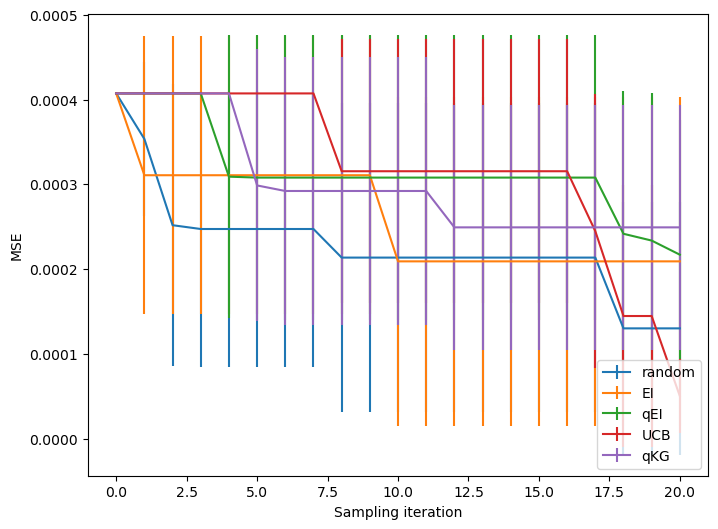

In [85]:
# plot the results
def ci(y):
    return 1.96 * y.std(axis=0) / np.sqrt(N_TRIALS)
    # return y.std(axis=0)

iters = np.arange(N_ROUND + 1) * BATCH_SIZE
y_ei = np.asarray(best_observed_ei_all)*-1
y_qei = np.asarray(best_observed_qei_all)*-1
y_ucb = np.asarray(best_observed_ucb_all)*-1
y_qkg = np.asarray(best_observed_qkg_all)*-1
y_rnd = np.asarray(best_random_all)*-1

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.errorbar(iters, y_rnd.mean(axis=0), yerr=ci(y_rnd), label="random", linewidth=1.5)
ax.errorbar(iters, y_ei.mean(axis=0), yerr=ci(y_ei), label="EI", linewidth=1.5)
ax.errorbar(iters, y_qei.mean(axis=0), yerr=ci(y_qei), label="qEI", linewidth=1.5)
ax.errorbar(iters, y_ucb.mean(axis=0), yerr=ci(y_ucb), label="UCB", linewidth=1.5)
ax.errorbar(iters, y_qkg.mean(axis=0), yerr=ci(y_qkg), label="qKG", linewidth=1.5)
# ax.set_ylim(bottom=0.5)
ax.set(xlabel='number of observations (beyond initial points)', ylabel='best objective value')
plt.xlabel("Sampling iteration")
plt.ylabel("MSE")
ax.legend(loc="lower right")


In [86]:
def extract_last_entry(x):
    tmp = []
    for i in range(4):
        tmp.append(x[i][-1])
    return tmp

In [87]:
rst_df = pd.DataFrame({
    "EI": [np.mean(extract_last_entry(best_observed_ei_all))*-1, np.std(extract_last_entry(best_observed_ei_all))],
    "qEI": [np.mean(extract_last_entry(best_observed_qei_all))*-1, np.std(extract_last_entry(best_observed_qei_all))],
    "UCB": [np.mean(extract_last_entry(best_observed_ucb_all))*-1, np.std(extract_last_entry(best_observed_ucb_all))],
    "qKG": [np.mean(extract_last_entry(best_observed_qkg_all))*-1, np.std(extract_last_entry(best_observed_qkg_all))],
    "random": [np.mean(extract_last_entry(best_random_all))*-1, np.std(extract_last_entry(best_random_all))],
}, index=["mean", "std"])
rst_df

,EI,qEI,UCB,qKG,random
mean,0.000209,0.000217,0.000050,0.000249,0.000130
std,0.000198,0.000163,0.000045,0.000147,0.000152
